# Sorting (排序法)，Fama-MacBeth 回归

## 横截面多因子回归回顾

$$R^e_{it+1} = \gamma_t + \lambda_{0t}\text{Anomaly}_{it} + \lambda_{1t} \beta_{it} + \lambda_{2t} Size_{it} + \lambda_{3t} BM_{it} + u_{it}  $$

本质：时刻t的某个证券i的Anomaly之间的差异，在控制住其他可能的影响因素之后，能否带来时刻t+1的收益率的不同

Anomaly：是否可以在证券i上直接观察到？如果不行，则需首先找到替代变量

Fama-MacBeth regression: 1. 每个时间t上，观察横截面的差异；2. 时间平均，看是否显著

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

pd.set_option('display.max_rows', 20)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import gc

In [3]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

# Data

In [4]:
START = '2008-01-01'
END = '2025-03-31'

In [5]:
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")

In [6]:
stk_info['listStatusCD'].unique()
# 上市状态：L-上市，S-暂停，DE-终止上市，UN-未上市，O-其他

array(['L', 'DE', 'O', 'UN', nan], dtype=object)

In [7]:
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
stk_info = stk_info[cond1 & cond2].copy()
stk_id = stk_info['secID'].unique()

In [8]:
len(stk_id)

5542

## ST

In [9]:
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")

In [10]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562242 entries, 0 to 562241
Data columns (total 3 columns):
secID        562242 non-null object
tradeDate    562242 non-null object
STflg        562242 non-null object
dtypes: object(3)
memory usage: 12.9+ MB


In [11]:
st_df

secID   tradeDate STflg
0       000004.XSHE  2008-01-02    ST
1       000004.XSHE  2008-01-03    ST
2       000004.XSHE  2008-01-04    ST
3       000004.XSHE  2008-01-07    ST
4       000004.XSHE  2008-01-08    ST
5       000004.XSHE  2008-01-09    ST
6       000004.XSHE  2008-01-10    ST
7       000004.XSHE  2008-01-11    ST
8       000004.XSHE  2008-01-14    ST
9       000004.XSHE  2008-01-15    ST
...             ...         ...   ...
562232  900955.XSHG  2022-06-01   *ST
562233  900955.XSHG  2022-06-02   *ST
562234  900955.XSHG  2022-06-06   *ST
562235  900955.XSHG  2022-06-07   *ST
562236  900955.XSHG  2022-06-08   *ST
562237  900955.XSHG  2022-06-09   *ST
562238  900955.XSHG  2022-06-10   *ST
562239  900955.XSHG  2022-06-13   *ST
562240  900955.XSHG  2022-06-14   *ST
562241  900955.XSHG  2022-06-15   *ST

[562242 rows x 3 columns]

In [12]:
st_df['STflg'].unique()
# ST标记，S*ST-公司经营连续三年亏损，退市预警+还没有完成股改;*ST-公司经营连续三年亏损，退市预警;ST-公司经营连续二年亏损，特别处理;SST-公司经营连续二年亏损，特别处理+还没有完成股改;S-还没有完成股改

array(['ST', '*ST', 'S', 'SST', 'S*ST', '*'], dtype=object)

In [13]:
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

## Risk free rate

In [14]:
pd.read_csv("./data/rf-monthly-2025.csv",encoding='UTF').head()

日期_Date  年份()_Year  月份_Month  月无风险收益率_MonRFRet
0  1989-02-01       1989         2            0.0063
1  1989-03-01       1989         3            0.0063
2  1989-04-01       1989         4            0.0063
3  1989-05-01       1989         5            0.0063
4  1989-06-01       1989         6            0.0063

In [15]:
rf = pd.read_csv("./data/rf-monthly-2025.csv",encoding='UTF').drop(["年份()_Year", "月份_Month"],axis=1)
rf.columns = ['Date', 'rf']
rf['Date'] = pd.to_datetime(rf["Date"])
rf['Date'] = rf['Date'].dt.to_period('M')
rf.rename(columns={'Date':'ym'},inplace=True)

In [16]:
rf

ym        rf
0    1989-02  0.006300
1    1989-03  0.006300
2    1989-04  0.006300
3    1989-05  0.006300
4    1989-06  0.006300
5    1989-07  0.006300
6    1989-08  0.006300
7    1989-09  0.006300
8    1989-10  0.006300
9    1989-11  0.006300
..       ...       ...
423  2024-05  0.002068
424  2024-06  0.002068
425  2024-07  0.002068
426  2024-08  0.002068
427  2024-09  0.002068
428  2024-10  0.002068
429  2024-11  0.002068
430  2024-12  0.002068
431  2025-01  0.002068
432  2025-02  0.002068

[433 rows x 2 columns]

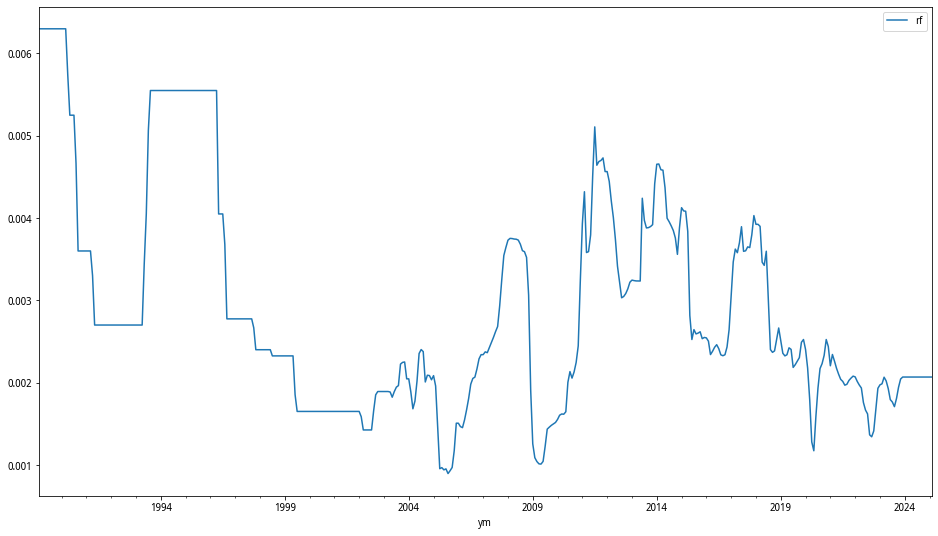

In [17]:
rf.set_index('ym').plot()

## Beta

Beta本身不是一个可以直接获取的公司特征，因此，需要计算：
- 用个股超额收益对市场超额收益回归，得到$\beta_i$的估计值
- 回归时间长度没有统一定论，有用过去一年的日收益率数据来算的，也有半年，2年，或者用月度的数据来算

计算量很大，因为涉及到几千只股票，每只个股要算比较长的一段时间（比如2008-2025有$16*12 = 216$个月，也即216个回归）。3000只股票，则回归的数目是 $216*3000 = 648,000$。
- 如果要自己用python计算，需要用到一些提速的技巧，比如用numpy array，或者参考这里：https://pandas.pydata.org/docs/user_guide/enhancingperf.html
- pandas进行大量数据操作的运算速度是一个比较重要的问题。没有统一或最好的解决方案。可以搜索以下关键词：dask, vaex, PySpark, swifter

因此，从实际操作的角度来讲，第一步的时序回归计算factor exposure本身计算量很大。因此，对于公司特征类因子，直接使用公司特征作为因子暴露，是一个经济上也合理的选择

In [18]:
# %time
# begin_ = 2008
# yesterday = dt.datetime.today() - dt.timedelta(days=1)
# yesterday.strftime('%Y%m%d')
# beta_df = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=['secID','tradeDate','Beta60','Beta120','Beta252'],pandas="1")

In [19]:
%%time
# # 从优矿下载 beta，时间较长。由于优矿的限制，每次下载1年的数据
# 优矿报错 too many calls：可能短时间不能有多于5次数据请求
# About 6mins.

# beta = {}
# year = 2008
# while year <= 2025:
#     if year == 2025:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         beta[year] = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                      beginDate=f'{year}0101',
#                                                      endDate=yesterday,
#                                                      field=['secID','tradeDate','Beta60','Beta120','Beta252'],pandas="1")
#     else:
#         beta[year] = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                          beginDate=f'{year}0101',
#                                                          endDate=f'{year}1231',
#                                                          field=['secID','tradeDate','Beta60','Beta120','Beta252'],pandas="1")
#     year += 1
    
# for i in range(len(beta)):
#     beta_df = pd.DataFrame(np.vstack([_df for _df in beta.values()]),columns=['secID','tradeDate','Beta60','Beta120','Beta252'])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.8 µs


In [20]:
# %%time
# # About 4 min 41s
# # # 从优矿下载 beta，时间较长。由于优矿的限制，每次下载3年的数据

# beta = {}
# begin_ = 2007
# end_ = 2010
# while begin_ <= 2024:
#     if begin_ == 2024:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         beta[begin_] = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=['secID','tradeDate','Beta60','Beta120','Beta252'],pandas="1")
#     else:
#         beta[begin_] = DataAPI.MktStockFactorsDateRangeProGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=['secID','tradeDate','Beta60','Beta120','Beta252'],pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(beta)):
#     beta_df = pd.DataFrame(np.vstack([_df for _df in beta.values()]),columns=['secID','tradeDate','Beta60','Beta120','Beta252'])
    


In [21]:
# beta_df.to_pickle('./data/beta_df.pkl')

In [22]:
beta_df = pd.read_pickle('./data/beta_df.pkl')

In [23]:
beta_df

secID   tradeDate  Beta60 Beta120 Beta252
0         000001.XSHE  2008-01-02  1.2063  1.2399  0.9433
1         000002.XSHE  2008-01-02  0.9363  1.0889  1.0912
2         000004.XSHE  2008-01-02  0.2562  0.5505   0.523
3         000005.XSHE  2008-01-02  0.7417  0.8581  0.6239
4         000006.XSHE  2008-01-02  1.0481  0.9951  1.0443
5         000007.XSHE  2008-01-02  0.3757  0.6156  0.5067
6         000008.XSHE  2008-01-02  0.6072  0.7102  0.6607
7         000009.XSHE  2008-01-02  0.9292  0.9433  0.8962
8         000010.XSHE  2008-01-02     NaN     NaN     NaN
9         000011.XSHE  2008-01-02  0.7808  0.7531   0.692
...               ...         ...     ...     ...     ...
13325726  688700.XSHG  2025-03-14  1.1574  2.0003  1.9071
13325727  688701.XSHG  2025-03-14  0.9171  1.5349  1.3937
13325728  688702.XSHG  2025-03-14  1.5236  1.8525  1.8662
13325729  688707.XSHG  2025-03-14  1.3776  1.7874  1.7132
13325730  688708.XSHG  2025-03-14  0.9792  0.4225  0.4291
13325731  688709.XSHG  2025-03-14  2.5297  1.8813  1.9892
13325732  688710.XSHG  2025-03-14   1.883  1.2293  1.3642
13325733  688711.XSHG  2025-03-14  1.8779  1.9532  1.9615
13325734  688716.XSHG  2025-03-14  1.8888  1.5459  1.6813
13325735  688717.XSHG  2025-03-14  1.1226  1.5987  1.5399

[13325736 rows x 5 columns]

In [24]:
beta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13325736 entries, 0 to 13325735
Data columns (total 5 columns):
secID        object
tradeDate    object
Beta60       object
Beta120      object
Beta252      object
dtypes: object(5)
memory usage: 508.3+ MB


In [25]:
beta_df.isna().sum()

secID             0
tradeDate         0
Beta60       468666
Beta120      468666
Beta252      704693
dtype: int64

In [26]:
beta_df['tradeDate'] = pd.to_datetime(beta_df['tradeDate'], format="%Y-%m-%d")

In [27]:
beta_df['ym'] = beta_df['tradeDate'].dt.to_period('M')

In [28]:
beta_df

secID  tradeDate  Beta60 Beta120 Beta252       ym
0         000001.XSHE 2008-01-02  1.2063  1.2399  0.9433  2008-01
1         000002.XSHE 2008-01-02  0.9363  1.0889  1.0912  2008-01
2         000004.XSHE 2008-01-02  0.2562  0.5505   0.523  2008-01
3         000005.XSHE 2008-01-02  0.7417  0.8581  0.6239  2008-01
4         000006.XSHE 2008-01-02  1.0481  0.9951  1.0443  2008-01
5         000007.XSHE 2008-01-02  0.3757  0.6156  0.5067  2008-01
6         000008.XSHE 2008-01-02  0.6072  0.7102  0.6607  2008-01
7         000009.XSHE 2008-01-02  0.9292  0.9433  0.8962  2008-01
8         000010.XSHE 2008-01-02     NaN     NaN     NaN  2008-01
9         000011.XSHE 2008-01-02  0.7808  0.7531   0.692  2008-01
...               ...        ...     ...     ...     ...      ...
13325726  688700.XSHG 2025-03-14  1.1574  2.0003  1.9071  2025-03
13325727  688701.XSHG 2025-03-14  0.9171  1.5349  1.3937  2025-03
13325728  688702.XSHG 2025-03-14  1.5236  1.8525  1.8662  2025-03
13325729  688707.XSHG 2025-03-14  1.3776  1.7874  1.7132  2025-03
13325730  688708.XSHG 2025-03-14  0.9792  0.4225  0.4291  2025-03
13325731  688709.XSHG 2025-03-14  2.5297  1.8813  1.9892  2025-03
13325732  688710.XSHG 2025-03-14   1.883  1.2293  1.3642  2025-03
13325733  688711.XSHG 2025-03-14  1.8779  1.9532  1.9615  2025-03
13325734  688716.XSHG 2025-03-14  1.8888  1.5459  1.6813  2025-03
13325735  688717.XSHG 2025-03-14  1.1226  1.5987  1.5399  2025-03

[13325736 rows x 6 columns]

In [29]:
beta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13325736 entries, 0 to 13325735
Data columns (total 6 columns):
secID        object
tradeDate    datetime64[ns]
Beta60       object
Beta120      object
Beta252      object
ym           period[M]
dtypes: datetime64[ns](1), object(4), period[M](1)
memory usage: 610.0+ MB


In [30]:
beta_df[['Beta60','Beta120','Beta252']] = beta_df[['Beta60','Beta120','Beta252']].apply(pd.to_numeric)

做以下观察：
1. 每月缺失值股票数占总股票数的比例
2. beta的时间序列变化是否比较大？

### ratio of available stocks

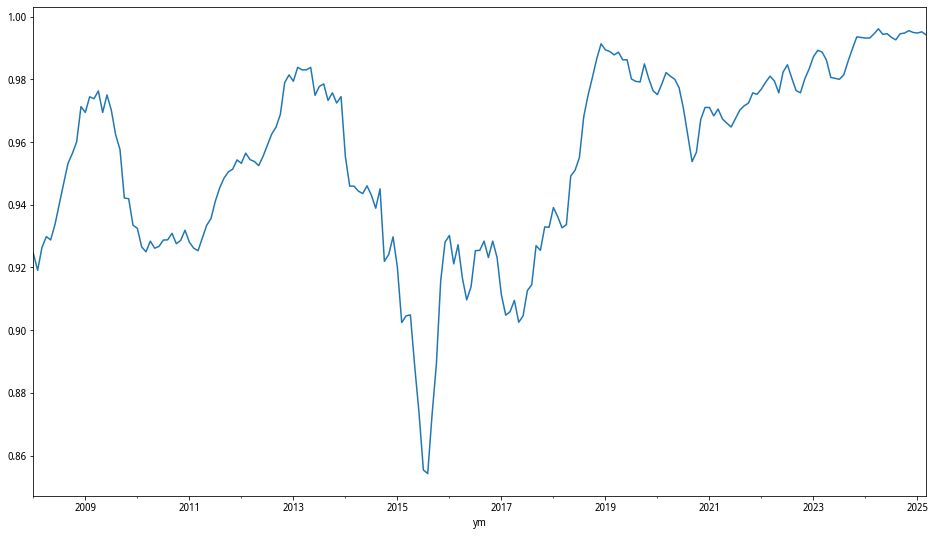

In [31]:
n_stk_avail = beta_df[['secID','tradeDate','ym','Beta252']].dropna().groupby('ym')['secID'].nunique()

n_stk = beta_df[['secID','tradeDate','ym','Beta252']].groupby('ym')['secID'].nunique()

(n_stk_avail / n_stk).plot()

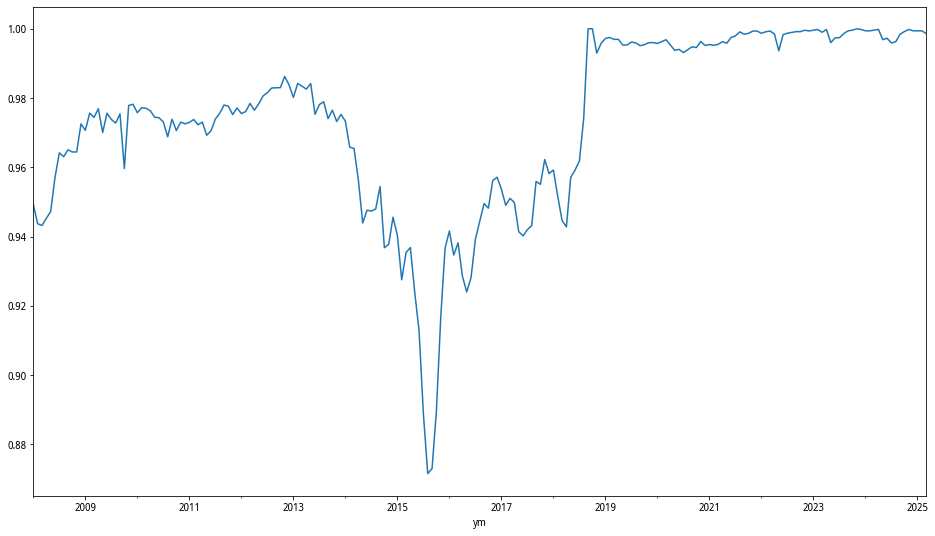

In [32]:
n_stk_avail = beta_df[['secID','tradeDate','ym','Beta60']].dropna().groupby('ym')['secID'].nunique()

n_stk = beta_df[['secID','tradeDate','ym','Beta60']].groupby('ym')['secID'].nunique()

(n_stk_avail / n_stk).plot()

### distribution of beta

#### 所有 beta 的分布

In [33]:
beta_df[['Beta60','Beta120','Beta252']].describe().round(2)

Beta60      Beta120      Beta252
count  12857070.00  12857070.00  12621043.00
mean          0.94         0.94         0.92
std          11.35        11.35         0.39
min      -13593.82    -13593.82       -33.05
25%           0.66         0.69         0.69
50%           0.95         0.95         0.94
75%           1.24         1.20         1.15
max       21632.41     21632.41        50.48

In [34]:
beta_df['Beta60'].quantile(0.99)

2.2369

In [35]:
beta_df['Beta60'].quantile(0.9999)

33.505220659995075

In [36]:
beta_df['Beta60'].quantile(1e-4)

-36.62143096

In [37]:
beta_df['Beta60'].quantile(1e-5)

-328.278782024

In [38]:
beta_df['Beta60'].nlargest(20)

11797259    21632.4094
1000790     13062.1548
1290587     10307.0733
12540523     5927.6503
2288544      5701.1917
11294932     5492.3465
12530657     4236.1103
13211783     3661.6241
5682408      3613.6436
997005       2921.0906
1000788      2895.1891
13081751     2881.1724
10130989     2580.6241
9407330      2481.2585
13087402     2416.1663
12539672     2186.7621
11960756     2094.0537
1545514      1992.2528
1545513      1495.0415
13314508     1417.5784
Name: Beta60, dtype: float64

In [39]:
beta_df['Beta60'].nsmallest(20)

9436693    -13593.8244
4662448    -11659.9526
3560786     -6530.5735
9460009     -5320.1502
5672303     -4767.6606
5244225     -4761.6744
5406870     -4760.4127
11961045    -3525.6681
11315775    -3505.4140
9009705     -3237.3332
10749482    -3164.4509
11515249    -3136.7980
1788736     -3064.6110
12537150    -3001.9229
13086040    -2921.1331
441111      -2570.3014
441158      -2398.7193
5241954     -2033.9017
5720382     -2033.0892
5680341     -2031.6253
Name: Beta60, dtype: float64

In [40]:
# beta_df[beta_df['Beta60'] == beta_df['Beta60'].min()]
beta_df.loc[[beta_df['Beta60'].idxmin()]]

secID  tradeDate      Beta60     Beta120  Beta252       ym
9436693  688112.XSHG 2021-12-02 -13593.8244 -13593.8244      NaN  2021-12

In [41]:
beta_df.loc[[beta_df['Beta60'].idxmax()]]

secID  tradeDate      Beta60     Beta120  Beta252       ym
11797259  688435.XSHG 2023-01-20  21632.4094  21632.4094      NaN  2023-01

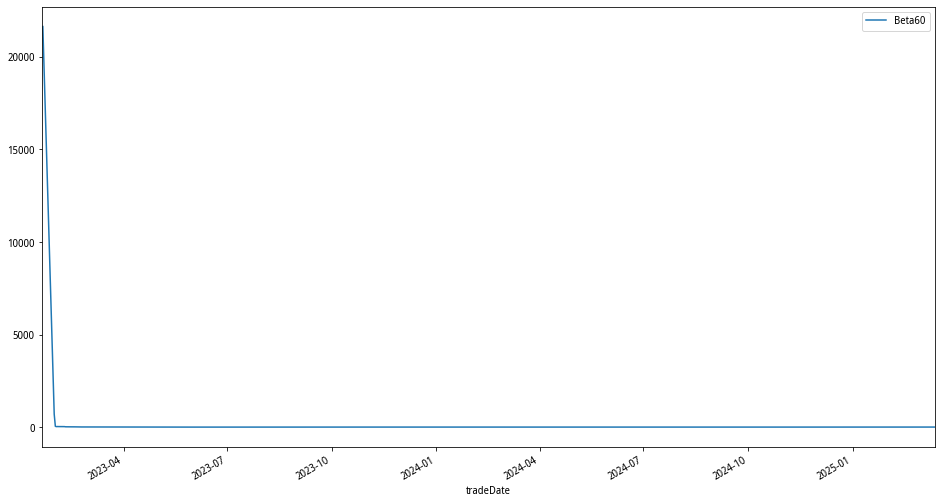

In [42]:
beta_df.loc[beta_df['secID']=='688435.XSHG',['Beta60','tradeDate']].set_index('tradeDate').plot()

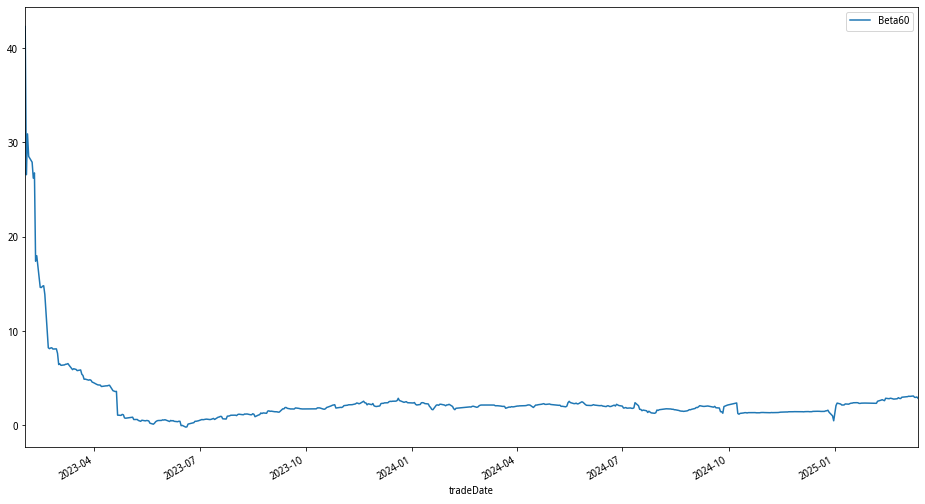

In [43]:
beta_df.loc[beta_df['secID']=='688435.XSHG',['Beta60','tradeDate']].iloc[3:,:].set_index('tradeDate').plot()

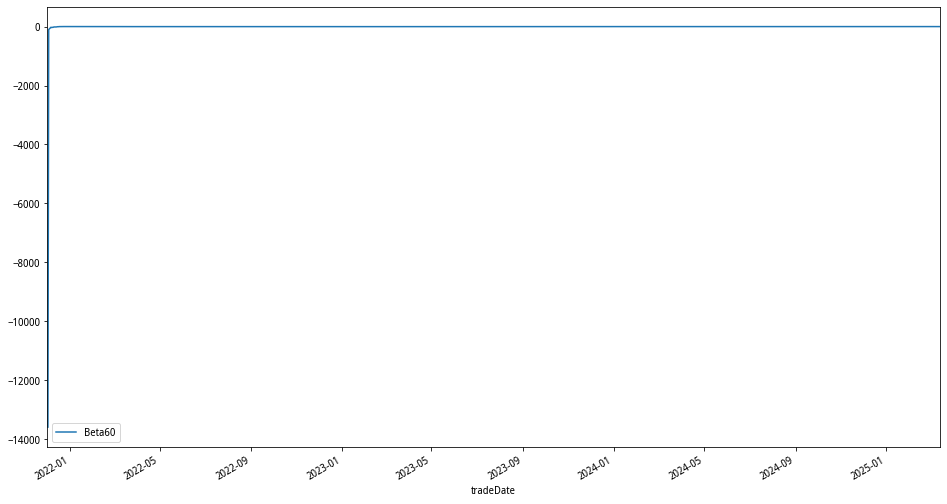

In [44]:
beta_df.loc[beta_df['secID']=='688112.XSHG',['Beta60','tradeDate']].set_index('tradeDate').plot()

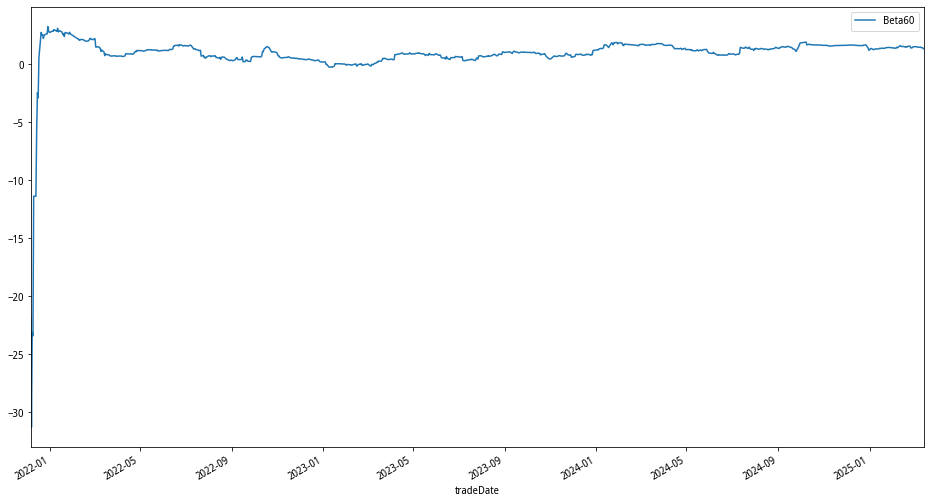

In [45]:
beta_df.loc[beta_df['secID']=='688112.XSHG',['Beta60','tradeDate']].iloc[3:,:].set_index('tradeDate').plot()

#### 个股 beta 的时间序列

##### 个股 beta 的时间序列方差

In [46]:
num_cols = beta_df.select_dtypes(np.number).columns

In [47]:
beta_df.groupby('secID')[num_cols].var().describe().round(2)

Beta60     Beta120  Beta252
count     5366.00     5366.00  5343.00
mean       840.14      839.38     0.15
std      25127.71    25127.44     0.34
min          0.00        0.00     0.00
25%          0.18        0.13     0.08
50%          0.37        0.29     0.11
75%          1.69        1.67     0.15
max    1515641.07  1515641.07    11.69

In [48]:
# # Winsorization
# beta_df.loc[beta_df['Beta60'] > beta_df['Beta60'].quantile(0.99999),'Beta60'] = beta_df['Beta60'].quantile(0.99999)
# beta_df.loc[beta_df['Beta60'] < beta_df['Beta60'].quantile(0.00001),'Beta60'] = beta_df['Beta60'].quantile(0.00001)
# beta_df.loc[beta_df['Beta120'] > beta_df['Beta120'].quantile(0.99999),'Beta120'] = beta_df['Beta120'].quantile(0.99999)
# beta_df.loc[beta_df['Beta120'] < beta_df['Beta120'].quantile(0.00001),'Beta120'] = beta_df['Beta120'].quantile(0.00001)
beta_df['Beta60_winsor'] = beta_df['Beta60'].clip(lower=beta_df['Beta60'].quantile(0.001),upper=beta_df['Beta60'].quantile(0.999))
beta_df['Beta120_winsor'] = beta_df['Beta120'].clip(lower=beta_df['Beta120'].quantile(0.001),upper=beta_df['Beta120'].quantile(0.999))
beta_df['Beta252_winsor'] = beta_df['Beta252'].clip(lower=beta_df['Beta252'].quantile(0.001),upper=beta_df['Beta252'].quantile(0.999))

In [49]:
num_cols = beta_df.select_dtypes(np.number).columns

In [50]:
beta_df.groupby('secID')[['Beta60_winsor','Beta120_winsor','Beta252_winsor']].var().describe().round(2)

Beta60_winsor  Beta120_winsor  Beta252_winsor
count        5366.00         5366.00         5343.00
mean            0.31            0.26            0.12
std             0.35            0.40            0.07
min             0.00            0.00            0.00
25%             0.17            0.12            0.08
50%             0.23            0.17            0.11
75%             0.34            0.27            0.15
max            11.89           14.21            0.95

##### 随机看几个个股beta的时间序列

In [51]:
stk_id_beta = beta_df['secID'].unique()

In [52]:
stk_picked = np.random.choice(stk_id_beta, 10)
print(stk_picked)
beta_plot = beta_df.loc[beta_df['secID'].isin(stk_picked)]

['600695.XSHG' '603231.XSHG' '688190.XSHG' '300431.XSHE' '002837.XSHE'
 '002422.XSHE' '603993.XSHG' '603610.XSHG' '301499.XSHE' '603109.XSHG']


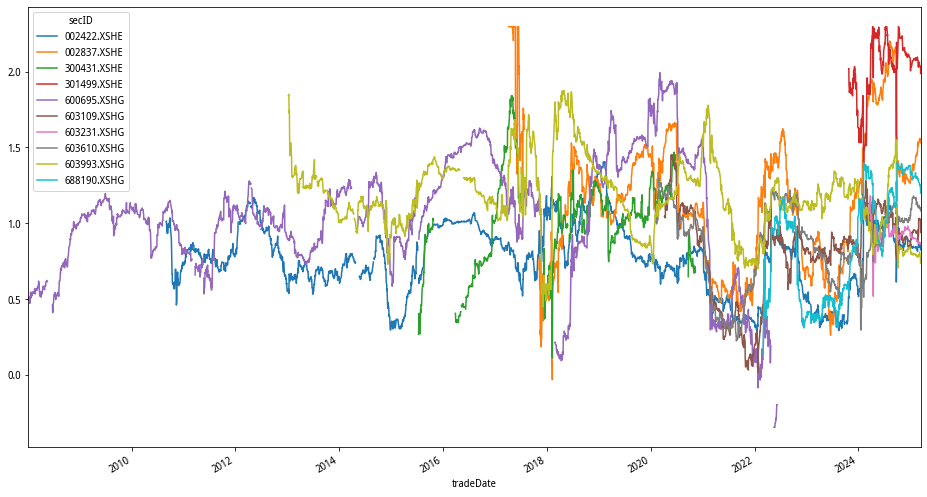

In [53]:
beta_plot.pivot(index='tradeDate', columns='secID', values='Beta252_winsor').plot()

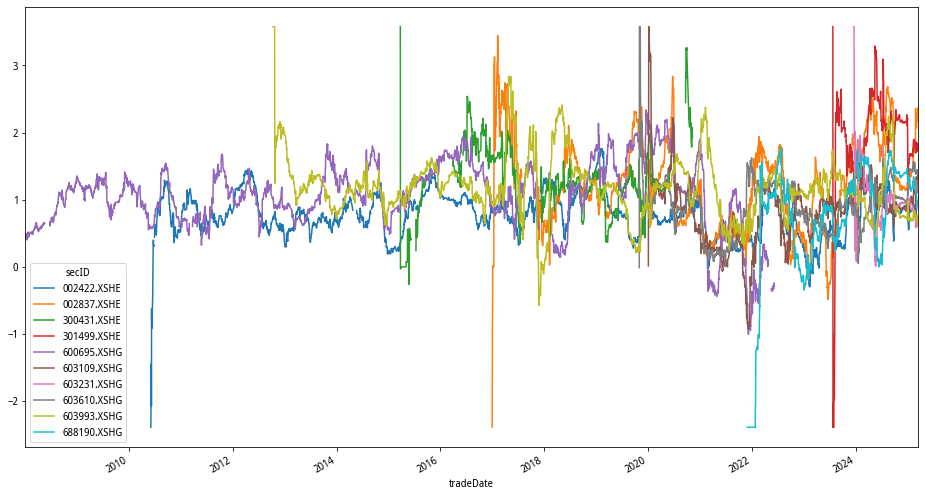

In [54]:
beta_plot.pivot(index='tradeDate', columns='secID', values='Beta60_winsor').plot()

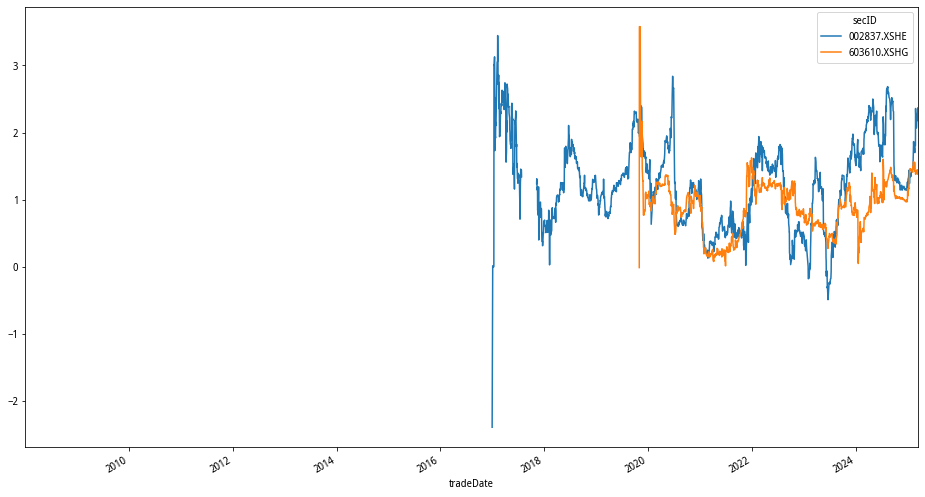

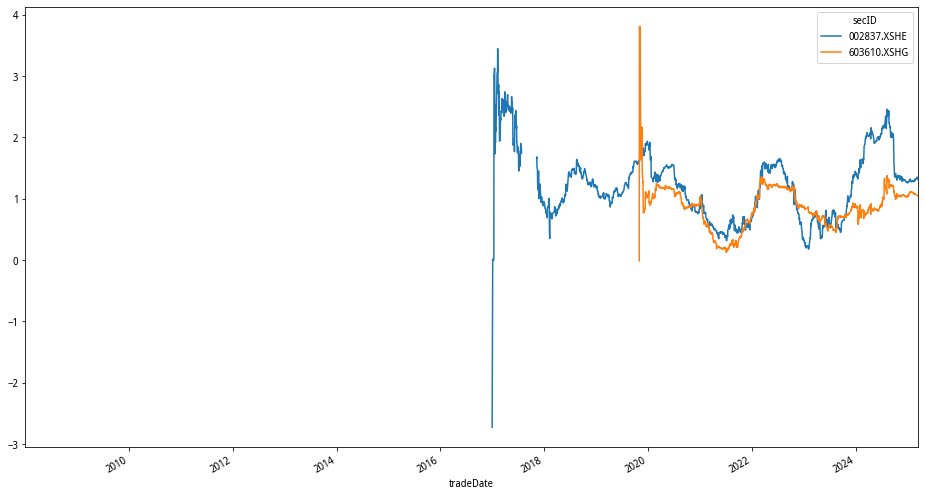

In [55]:
stk_ = np.random.choice(stk_picked,2)
beta_plot.pivot(index='tradeDate', columns='secID', values='Beta60_winsor')[[stk_[0],stk_[1]]].plot()
beta_plot.pivot(index='tradeDate', columns='secID', values='Beta120_winsor')[[stk_[0],stk_[1]]].plot()

In [56]:
beta_corr = beta_df.groupby('secID')[['Beta60','Beta120','Beta252']].corr()
beta_corr

Beta60   Beta120   Beta252
secID                                            
000001.XSHE Beta60   1.000000  0.877136  0.871366
            Beta120  0.877136  1.000000  0.947292
            Beta252  0.871366  0.947292  1.000000
000002.XSHE Beta60   1.000000  0.697874  0.677672
            Beta120  0.697874  1.000000  0.826545
            Beta252  0.677672  0.826545  1.000000
000004.XSHE Beta60   1.000000  0.786711  0.841922
            Beta120  0.786711  1.000000  0.896666
            Beta252  0.841922  0.896666  1.000000
000005.XSHE Beta60   1.000000  0.884828  0.859739
...                       ...       ...       ...
688800.XSHG Beta252  0.678852  0.880408  1.000000
688819.XSHG Beta60   1.000000  0.889607  0.895276
            Beta120  0.889607  1.000000  0.974016
            Beta252  0.895276  0.974016  1.000000
688981.XSHG Beta60   1.000000  0.843987  0.887846
            Beta120  0.843987  1.000000  0.956230
            Beta252  0.887846  0.956230  1.000000
689009.XSHG Beta60   1.000000  0.923408  0.829550
            Beta120  0.923408  1.000000  0.942723
            Beta252  0.829550  0.942723  1.000000

[16104 rows x 3 columns]

In [57]:
beta_corr['Beta252'].min()

-0.8173506329806798

In [58]:
beta_corr.loc[[beta_corr['Beta252'].idxmin()]]

Beta60   Beta120   Beta252
secID                                         
301622.XSHE Beta60     1.0  0.999975 -0.817351

In [59]:
beta_corr.loc['301622.XSHE']

Beta60   Beta120   Beta252
Beta60   1.000000  0.999975 -0.817351
Beta120  0.999975  1.000000  0.999456
Beta252 -0.817351  0.999456  1.000000

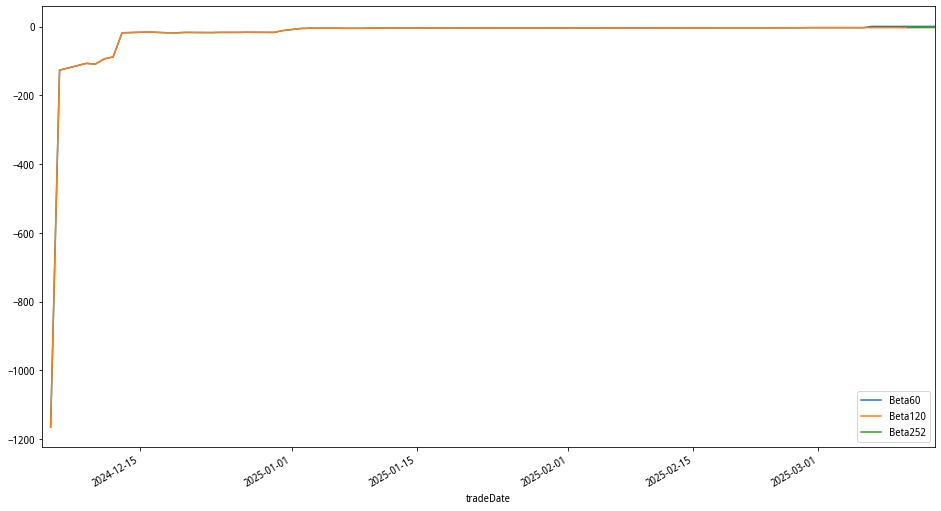

In [60]:
beta_df.loc[beta_df['secID']=='301622.XSHE',['tradeDate','Beta60','Beta120','Beta252']].set_index('tradeDate').plot()

In [61]:
beta_corr.loc['601096.XSHG']

Beta60   Beta120   Beta252
Beta60   1.000000  0.999998  0.785684
Beta120  0.999998  1.000000  0.919401
Beta252  0.785684  0.919401  1.000000

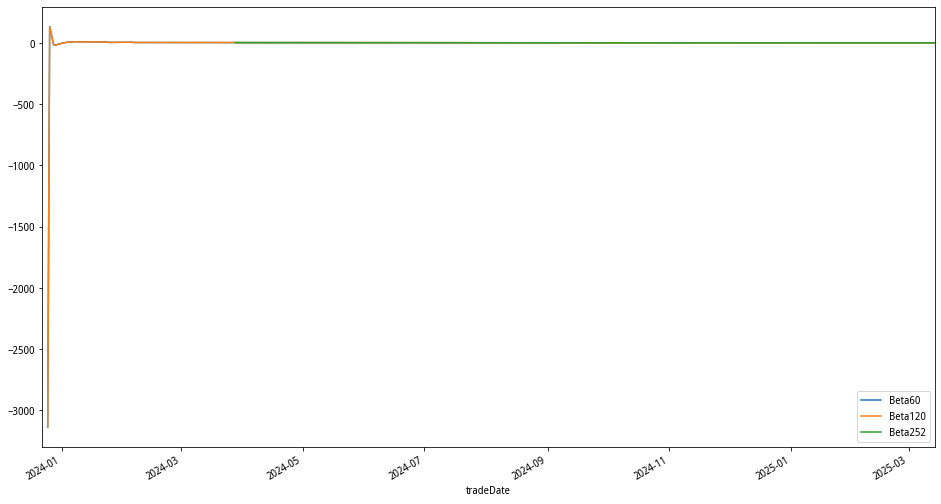

In [62]:
beta_df.loc[beta_df['secID']=='601096.XSHG',['tradeDate','Beta60','Beta120','Beta252']].set_index('tradeDate').plot()

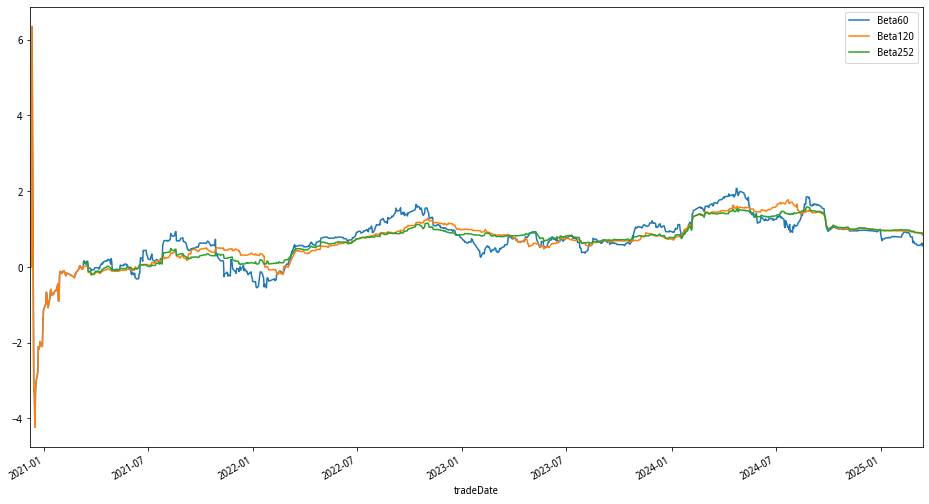

In [63]:
beta_df.loc[beta_df['secID']=='605183.XSHG',['tradeDate','Beta60','Beta120','Beta252']].set_index('tradeDate').plot()

In [64]:
beta_corr.loc[pd.IndexSlice[:,['Beta60','Beta120']],'Beta252']

secID               
000001.XSHE  Beta60     0.871366
             Beta120    0.947292
000002.XSHE  Beta60     0.677672
             Beta120    0.826545
000004.XSHE  Beta60     0.841922
             Beta120    0.896666
000005.XSHE  Beta60     0.859739
             Beta120    0.933794
000006.XSHE  Beta60     0.771954
             Beta120    0.863836
                          ...   
688799.XSHG  Beta60     0.805562
             Beta120    0.967057
688800.XSHG  Beta60     0.678852
             Beta120    0.880408
688819.XSHG  Beta60     0.895276
             Beta120    0.974016
688981.XSHG  Beta60     0.887846
             Beta120    0.956230
689009.XSHG  Beta60     0.829550
             Beta120    0.942723
Name: Beta252, Length: 10736, dtype: float64

In [65]:
beta_corr.loc[pd.IndexSlice[:,['Beta60','Beta120']],'Beta252'].mean()

0.8624135469991295

### 关于 beta 的观察总结

- 对于个股来讲，beta的时间序列变化很大，尤其是在刚上市时，因为新股发行的特殊交易规则以及聚光灯效应
- Beta60, Beta120在初始估计时方差很大
- Beta252 比其他两个估计值要更稳定

### Monthly beta

In [66]:
beta_df.groupby(['secID','ym'])['Beta252'].last()

secID        ym     
000001.XSHE  2008-01    0.9654
             2008-02    1.0292
             2008-03    1.0238
             2008-04    1.0212
             2008-05    1.0697
             2008-06    1.0672
             2008-07    1.0966
             2008-08    1.0386
             2008-09    1.1184
             2008-10    1.1991
                         ...  
689009.XSHG  2024-06    1.5890
             2024-07    1.5046
             2024-08    1.1651
             2024-09    1.0361
             2024-10    1.3022
             2024-11    1.2585
             2024-12    1.2255
             2025-01    1.1695
             2025-02    1.2526
             2025-03    1.2889
Name: Beta252, Length: 663643, dtype: float64

In [67]:
beta_m_df = beta_df.groupby(['secID','ym'],as_index=False)['Beta252'].last()

In [68]:
beta_m_df

secID       ym  Beta252
0       000001.XSHE  2008-01   0.9654
1       000001.XSHE  2008-02   1.0292
2       000001.XSHE  2008-03   1.0238
3       000001.XSHE  2008-04   1.0212
4       000001.XSHE  2008-05   1.0697
5       000001.XSHE  2008-06   1.0672
6       000001.XSHE  2008-07   1.0966
7       000001.XSHE  2008-08   1.0386
8       000001.XSHE  2008-09   1.1184
9       000001.XSHE  2008-10   1.1991
...             ...      ...      ...
663633  689009.XSHG  2024-06   1.5890
663634  689009.XSHG  2024-07   1.5046
663635  689009.XSHG  2024-08   1.1651
663636  689009.XSHG  2024-09   1.0361
663637  689009.XSHG  2024-10   1.3022
663638  689009.XSHG  2024-11   1.2585
663639  689009.XSHG  2024-12   1.2255
663640  689009.XSHG  2025-01   1.1695
663641  689009.XSHG  2025-02   1.2526
663642  689009.XSHG  2025-03   1.2889

[663643 rows x 3 columns]

## Trading data

In [69]:
# %%time
# stk_df = DataAPI.MktEqudAdjAfGet(secID=stk_id,beginDate='2008-01-01',endDate=END,
#                                            field=["secID","tradeDate",
#                                                   "closePrice",
#                                                   "negMarketValue"],pandas="1")

# stk_df.to_pickle('./data/stk_df.pkl')
# 这样下载的数据条目只有500万左右
# 大约 3min

In [70]:
# %%time
# # About 10 mins
# # # 从优矿下载股票信息，时间较长。由于优矿的限制，每次下载3年的数据

# stk_dict = {}
# begin_ = dt.datetime.strptime(START, '%Y-%m-%d').year
# end_ = dt.datetime.strptime(START, '%Y-%m-%d').year+3
# while begin_ <= 2025:
#     if begin_ == 2025:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=['secID','tradeDate','closePrice','negMarketValue'],pandas="1")
#     else:
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=['secID','tradeDate','closePrice','negMarketValue'],pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(stk_dict)):
#     stk_df = pd.DataFrame(np.vstack([_df for _df in stk_dict.values()]),columns=['secID','tradeDate','closePrice','negMarketValue'])
    
# stk_df.to_pickle('./data/stk_df.pkl')

In [71]:
stk_df = pd.read_pickle('./data/stk_df.pkl')

In [72]:
stk_df[(stk_df['secID']=='000001.XSHE') & (stk_df['tradeDate']>='2012-01-08')&(stk_df['tradeDate']<='2012-01-30')]
# 停牌时，数据被填充为跟前一日一样。这是不好的数据处理

secID   tradeDate closePrice negMarketValue
1880049  000001.XSHE  2012-01-09    651.094    4.90026e+10
1880050  000001.XSHE  2012-01-10    651.094    4.90026e+10
1880051  000001.XSHE  2012-01-11    651.094    4.90026e+10
1880052  000001.XSHE  2012-01-12    651.094    4.90026e+10
1880053  000001.XSHE  2012-01-13    651.094    4.90026e+10
1880054  000001.XSHE  2012-01-16    651.094    4.90026e+10
1880055  000001.XSHE  2012-01-17    651.094    4.90026e+10
1880056  000001.XSHE  2012-01-18    651.094    4.90026e+10
1880057  000001.XSHE  2012-01-19    651.094    4.90026e+10
1880058  000001.XSHE  2012-01-20    692.355    5.21079e+10
1880059  000001.XSHE  2012-01-30    689.466    5.18905e+10

In [73]:
# stk_df[(stk_df['secID']=='000007.XSHE') & (stk_df['tradeDate']>='2021-04-20')&(stk_df['tradeDate']<='2021-05-30')]
# 另一个检查，没有停牌日

In [74]:
stk_df

secID   tradeDate closePrice negMarketValue
0         000001.XSHE  2008-01-02    1201.88     6.6724e+10
1         000001.XSHE  2008-01-03    1181.94    6.56172e+10
2         000001.XSHE  2008-01-04    1214.22    6.74092e+10
3         000001.XSHE  2008-01-07    1239.53    6.88147e+10
4         000001.XSHE  2008-01-08    1278.14     7.0958e+10
5         000001.XSHE  2008-01-09    1300.93    7.22229e+10
6         000001.XSHE  2008-01-10    1327.51    7.36986e+10
7         000001.XSHE  2008-01-11    1394.91    7.74406e+10
8         000001.XSHE  2008-01-14    1374.97    7.63339e+10
9         000001.XSHE  2008-01-15    1330.04    7.38392e+10
...               ...         ...        ...            ...
13755115  900957.XSHG  2025-03-04      0.281     5.1336e+07
13755116  900957.XSHG  2025-03-05       0.28     5.1152e+07
13755117  900957.XSHG  2025-03-06      0.303     5.5384e+07
13755118  900957.XSHG  2025-03-07      0.295     5.3912e+07
13755119  900957.XSHG  2025-03-10      0.297      5.428e+07
13755120  900957.XSHG  2025-03-11      0.295     5.3912e+07
13755121  900957.XSHG  2025-03-12      0.295     5.3912e+07
13755122  900957.XSHG  2025-03-13       0.29     5.2992e+07
13755123  900957.XSHG  2025-03-14       0.31     5.6672e+07
13755124  900957.XSHG  2025-03-17      0.319     5.8144e+07

[13755125 rows x 4 columns]

In [75]:
stk_df['secID'].nunique()

5478

In [76]:
len(stk_id)

5542

In [77]:
stk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13755125 entries, 0 to 13755124
Data columns (total 4 columns):
secID             object
tradeDate         object
closePrice        object
negMarketValue    object
dtypes: object(4)
memory usage: 419.8+ MB


In [78]:
stk_df

secID   tradeDate closePrice negMarketValue
0         000001.XSHE  2008-01-02    1201.88     6.6724e+10
1         000001.XSHE  2008-01-03    1181.94    6.56172e+10
2         000001.XSHE  2008-01-04    1214.22    6.74092e+10
3         000001.XSHE  2008-01-07    1239.53    6.88147e+10
4         000001.XSHE  2008-01-08    1278.14     7.0958e+10
5         000001.XSHE  2008-01-09    1300.93    7.22229e+10
6         000001.XSHE  2008-01-10    1327.51    7.36986e+10
7         000001.XSHE  2008-01-11    1394.91    7.74406e+10
8         000001.XSHE  2008-01-14    1374.97    7.63339e+10
9         000001.XSHE  2008-01-15    1330.04    7.38392e+10
...               ...         ...        ...            ...
13755115  900957.XSHG  2025-03-04      0.281     5.1336e+07
13755116  900957.XSHG  2025-03-05       0.28     5.1152e+07
13755117  900957.XSHG  2025-03-06      0.303     5.5384e+07
13755118  900957.XSHG  2025-03-07      0.295     5.3912e+07
13755119  900957.XSHG  2025-03-10      0.297      5.428e+07
13755120  900957.XSHG  2025-03-11      0.295     5.3912e+07
13755121  900957.XSHG  2025-03-12      0.295     5.3912e+07
13755122  900957.XSHG  2025-03-13       0.29     5.2992e+07
13755123  900957.XSHG  2025-03-14       0.31     5.6672e+07
13755124  900957.XSHG  2025-03-17      0.319     5.8144e+07

[13755125 rows x 4 columns]

In [79]:
stk_df['closePrice'] = pd.to_numeric(stk_df['closePrice'])
stk_df['negMarketValue'] = pd.to_numeric(stk_df['negMarketValue'])

In [80]:
stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')

In [81]:
stk_df['ym'] = stk_df['tradeDate'].dt.to_period('M')

In [82]:
stk_df.sort_values(['secID','tradeDate'],inplace=True)

### Exclude ST

In [83]:
st_df

secID  tradeDate STflg
0       000004.XSHE 2008-01-02    ST
1       000004.XSHE 2008-01-03    ST
2       000004.XSHE 2008-01-04    ST
3       000004.XSHE 2008-01-07    ST
4       000004.XSHE 2008-01-08    ST
5       000004.XSHE 2008-01-09    ST
6       000004.XSHE 2008-01-10    ST
7       000004.XSHE 2008-01-11    ST
8       000004.XSHE 2008-01-14    ST
9       000004.XSHE 2008-01-15    ST
...             ...        ...   ...
562232  900955.XSHG 2022-06-01   *ST
562233  900955.XSHG 2022-06-02   *ST
562234  900955.XSHG 2022-06-06   *ST
562235  900955.XSHG 2022-06-07   *ST
562236  900955.XSHG 2022-06-08   *ST
562237  900955.XSHG 2022-06-09   *ST
562238  900955.XSHG 2022-06-10   *ST
562239  900955.XSHG 2022-06-13   *ST
562240  900955.XSHG 2022-06-14   *ST
562241  900955.XSHG 2022-06-15   *ST

[562242 rows x 3 columns]

In [84]:
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'], format='%Y-%m-%d')

In [85]:
stk_df.isna()

secID  tradeDate  closePrice  negMarketValue     ym
0         False      False       False           False  False
1         False      False       False           False  False
2         False      False       False           False  False
3         False      False       False           False  False
4         False      False       False           False  False
5         False      False       False           False  False
6         False      False       False           False  False
7         False      False       False           False  False
8         False      False       False           False  False
9         False      False       False           False  False
...         ...        ...         ...             ...    ...
13755115  False      False       False           False  False
13755116  False      False       False           False  False
13755117  False      False       False           False  False
13755118  False      False       False           False  False
13755119  False      False       False           False  False
13755120  False      False       False           False  False
13755121  False      False       False           False  False
13755122  False      False       False           False  False
13755123  False      False       False           False  False
13755124  False      False       False           False  False

[13755125 rows x 5 columns]

In [86]:
stk_df.isna().values.any()
# 是否至少有一个是 True?

False

In [87]:
stk_df.dropna().shape
# shape 是否和 stk_df 一样

(13755125, 5)

In [88]:
stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')

In [89]:
stk_df

secID  tradeDate  closePrice  negMarketValue       ym STflg
0         000001.XSHE 2008-01-02    1201.877    6.672404e+10  2008-01   NaN
1         000001.XSHE 2008-01-03    1181.940    6.561725e+10  2008-01   NaN
2         000001.XSHE 2008-01-04    1214.218    6.740920e+10  2008-01   NaN
3         000001.XSHE 2008-01-07    1239.534    6.881466e+10  2008-01   NaN
4         000001.XSHE 2008-01-08    1278.141    7.095798e+10  2008-01   NaN
5         000001.XSHE 2008-01-09    1300.926    7.222289e+10  2008-01   NaN
6         000001.XSHE 2008-01-10    1327.507    7.369862e+10  2008-01   NaN
7         000001.XSHE 2008-01-11    1394.911    7.744065e+10  2008-01   NaN
8         000001.XSHE 2008-01-14    1374.975    7.633385e+10  2008-01   NaN
9         000001.XSHE 2008-01-15    1330.039    7.383917e+10  2008-01   NaN
...               ...        ...         ...             ...      ...   ...
13755115  900957.XSHG 2025-03-04       0.281    5.133600e+07  2025-03   NaN
13755116  900957.XSHG 2025-03-05       0.280    5.115200e+07  2025-03   NaN
13755117  900957.XSHG 2025-03-06       0.303    5.538400e+07  2025-03   NaN
13755118  900957.XSHG 2025-03-07       0.295    5.391200e+07  2025-03   NaN
13755119  900957.XSHG 2025-03-10       0.297    5.428000e+07  2025-03   NaN
13755120  900957.XSHG 2025-03-11       0.295    5.391200e+07  2025-03   NaN
13755121  900957.XSHG 2025-03-12       0.295    5.391200e+07  2025-03   NaN
13755122  900957.XSHG 2025-03-13       0.290    5.299200e+07  2025-03   NaN
13755123  900957.XSHG 2025-03-14       0.310    5.667200e+07  2025-03   NaN
13755124  900957.XSHG 2025-03-17       0.319    5.814400e+07  2025-03   NaN

[13755125 rows x 6 columns]

In [90]:
stk_df = stk_df[stk_df['STflg'].isna()].copy()

In [91]:
stk_df.drop('STflg',axis=1,inplace=True)

In [92]:
stk_df.shape

(13193122, 5)

In [93]:
stk_df['secID'].nunique()

5473

### Monthly trading data

In [255]:
stk_df_m = stk_df.groupby(['secID','ym'],as_index=False).last() 
# 有些数据库会把没有当月最后一个交易日数据的股票的月收益率设为空值。这里不做此设置，只要当月任何一日有交易，
# 都可被提出。last()会把最后一个非空值提出。

In [256]:
from myutils import utils as ut
temp = ut.makeStockFrame()

In [257]:
temp

date variable     value
0  2000-01-03        A -0.137739
1  2000-01-04        A  0.596789
2  2000-01-05        A -0.453916
3  2000-01-03        B -0.610404
4  2000-01-04        B -0.404938
5  2000-01-05        B  0.303027
6  2000-01-03        C  2.349997
7  2000-01-04        C  1.248005
8  2000-01-05        C -0.177690
9  2000-01-03        D  0.812006
10 2000-01-04        D  0.762131
11 2000-01-05        D -0.150473

In [258]:
temp.loc[5,'value'] = np.nan

In [259]:
temp

date variable     value
0  2000-01-03        A -0.137739
1  2000-01-04        A  0.596789
2  2000-01-05        A -0.453916
3  2000-01-03        B -0.610404
4  2000-01-04        B -0.404938
5  2000-01-05        B       NaN
6  2000-01-03        C  2.349997
7  2000-01-04        C  1.248005
8  2000-01-05        C -0.177690
9  2000-01-03        D  0.812006
10 2000-01-04        D  0.762131
11 2000-01-05        D -0.150473

In [260]:
temp.groupby('variable').last() # 注意B组的date和value被错位了

date     value
variable                     
A        2000-01-05 -0.453916
B        2000-01-05 -0.404938
C        2000-01-05 -0.177690
D        2000-01-05 -0.150473

In [261]:
temp.groupby('variable').tail(1) # 此时没有错位

date variable     value
2  2000-01-05        A -0.453916
5  2000-01-05        B       NaN
8  2000-01-05        C -0.177690
11 2000-01-05        D -0.150473

#### Fill na months

### 停牌

- 停牌在某些时候是可以不处理的，比如计算动量的时候，停牌之后的价格和停牌前的价格计算收益率，可以作为动量的一种衡量
- 但在有的时候，停牌不处理可能会有问题。
    - 比如计算beta，市场收益率每个交易日都是有的。但个股停牌的时候没有个股收益率。此时如果设为0，直接回归会有大的偏差
    - 另外比如计算波动率，如果设为0，也有问题
    - 从收益率的角度看，如果我们关注点是月收益率，也应当去掉，因为停牌的股票无法交易，也无法调仓

In [262]:
stk_df_m[(stk_df_m['secID']=='000001.XSHE') & (stk_df_m['tradeDate']>='2010-05') & (stk_df_m['tradeDate']<='2010-10')]

secID       ym  tradeDate  closePrice  negMarketValue
28  000001.XSHE  2010-05 2010-05-31     722.475    5.120124e+10
29  000001.XSHE  2010-06 2010-06-30     722.475    5.437499e+10
30  000001.XSHE  2010-07 2010-07-30     722.475    5.437499e+10
31  000001.XSHE  2010-08 2010-08-31     722.475    5.437499e+10
32  000001.XSHE  2010-09 2010-09-30     669.249    5.036906e+10

👆过去的数据中，无交易时的数据会被留空。但现在都用同一个数值填上了。这是非常不好的数据操作！

In [263]:
# stk_df_m['tradeDate']

In [264]:
stk_df_m['ym']

0         2008-01
1         2008-02
2         2008-03
3         2008-04
4         2008-05
5         2008-06
6         2008-07
7         2008-08
8         2008-09
9         2008-10
           ...   
657630    2024-06
657631    2024-07
657632    2024-08
657633    2024-09
657634    2024-10
657635    2024-11
657636    2024-12
657637    2025-01
657638    2025-02
657639    2025-03
Name: ym, Length: 657640, dtype: period[M]

In [265]:
stk_df_m['ym'].shift()

0             NaT
1         2008-01
2         2008-02
3         2008-03
4         2008-04
5         2008-05
6         2008-06
7         2008-07
8         2008-08
9         2008-09
           ...   
657630    2024-05
657631    2024-06
657632    2024-07
657633    2024-08
657634    2024-09
657635    2024-10
657636    2024-11
657637    2024-12
657638    2025-01
657639    2025-02
Name: ym, Length: 657640, dtype: period[M]

In [266]:
stk_df_m['ym'] - stk_df_m.groupby('secID')['ym'].shift()

0                NaT
1         <MonthEnd>
2         <MonthEnd>
3         <MonthEnd>
4         <MonthEnd>
5         <MonthEnd>
6         <MonthEnd>
7         <MonthEnd>
8         <MonthEnd>
9         <MonthEnd>
             ...    
657630    <MonthEnd>
657631    <MonthEnd>
657632    <MonthEnd>
657633    <MonthEnd>
657634    <MonthEnd>
657635    <MonthEnd>
657636    <MonthEnd>
657637    <MonthEnd>
657638    <MonthEnd>
657639    <MonthEnd>
Name: ym, Length: 657640, dtype: object

In [267]:
stk_df_m['month_diff'] = stk_df_m['ym'] - stk_df_m.groupby('secID')['ym'].shift()

In [268]:
stk_df_m.groupby('secID')['month_diff'].unique()

secID
000001.XSHE                                    [NaT, <MonthEnd>]
000002.XSHE                                    [NaT, <MonthEnd>]
000004.XSHE                  [NaT, <MonthEnd>, <13 * MonthEnds>]
000005.XSHE                                    [NaT, <MonthEnd>]
000006.XSHE                                    [NaT, <MonthEnd>]
000007.XSHE    [NaT, <MonthEnd>, <15 * MonthEnds>, <14 * Mont...
000008.XSHE                                    [NaT, <MonthEnd>]
000009.XSHE                                    [NaT, <MonthEnd>]
000010.XSHE                  [NaT, <MonthEnd>, <15 * MonthEnds>]
000011.XSHE                                    [NaT, <MonthEnd>]
                                     ...                        
900947.XSHG                                    [NaT, <MonthEnd>]
900948.XSHG                                    [NaT, <MonthEnd>]
900949.XSHG                                    [NaT, <MonthEnd>]
900950.XSHG                                    [NaT, <MonthEnd>]
900951.XSHG    [NaT

In [269]:
stk_df_m.loc[stk_df_m['secID']=='000007.XSHE']

secID       ym  tradeDate  closePrice  negMarketValue  \
930   000007.XSHE  2012-05 2012-05-31     125.922    2.903956e+09   
931   000007.XSHE  2012-06 2012-06-29     119.024    2.744886e+09   
932   000007.XSHE  2012-07 2012-07-31     132.579    3.057477e+09   
933   000007.XSHE  2012-08 2012-08-31     128.087    2.953897e+09   
934   000007.XSHE  2012-09 2012-09-28     123.436    2.846617e+09   
935   000007.XSHE  2012-10 2012-10-31     128.970    2.974243e+09   
936   000007.XSHE  2012-11 2012-11-30     101.299    2.336113e+09   
937   000007.XSHE  2012-12 2012-12-31     116.057    2.674514e+09   
938   000007.XSHE  2013-01 2013-01-31     146.695    3.380571e+09   
939   000007.XSHE  2013-02 2013-02-28     157.523    3.630093e+09   
...           ...      ...        ...         ...             ...   
1048  000007.XSHE  2023-05 2023-05-04      65.568    1.683767e+09   
1049  000007.XSHE  2024-07 2024-07-31      61.237    1.572545e+09   
1050  000007.XSHE  2024-08 2024-08-30      55.702    1.430429e+09   
1051  000007.XSHE  2024-09 2024-09-30      81.448    2.091578e+09   
1052  000007.XSHE  2024-10 2024-10-31      81.689    2.097757e+09   
1053  000007.XSHE  2024-11 2024-11-29      87.343    2.515212e+09   
1054  000007.XSHE  2024-12 2024-12-31      84.576    2.435529e+09   
1055  000007.XSHE  2025-01 2025-01-27      83.614    2.407814e+09   
1056  000007.XSHE  2025-02 2025-02-28      75.072    2.161836e+09   
1057  000007.XSHE  2025-03 2025-03-14      76.395    2.199945e+09   

            month_diff  
930                NaT  
931         <MonthEnd>  
932         <MonthEnd>  
933         <MonthEnd>  
934         <MonthEnd>  
935         <MonthEnd>  
936         <MonthEnd>  
937         <MonthEnd>  
938         <MonthEnd>  
939         <MonthEnd>  
...                ...  
1048        <MonthEnd>  
1049  <14 * MonthEnds>  
1050        <MonthEnd>  
1051        <MonthEnd>  
1052        <MonthEnd>  
1053        <MonthEnd>  
1054        <MonthEnd>  
1055        <MonthEnd>  
1056        <MonthEnd>  
1057        <MonthEnd>  

[128 rows x 6 columns]

In [270]:
stk_df_m.loc[stk_df_m['secID']=='000007.XSHE'].loc[1048:1050]

secID       ym  tradeDate  closePrice  negMarketValue  \
1048  000007.XSHE  2023-05 2023-05-04      65.568    1.683767e+09   
1049  000007.XSHE  2024-07 2024-07-31      61.237    1.572545e+09   
1050  000007.XSHE  2024-08 2024-08-30      55.702    1.430429e+09   

            month_diff  
1048        <MonthEnd>  
1049  <14 * MonthEnds>  
1050        <MonthEnd>

In [271]:
cond1 = stk_df['secID']=='000007.XSHE'
cond2 = stk_df['tradeDate']>='2023-05-04'
stk_df.loc[cond1&cond2]

secID  tradeDate  closePrice  negMarketValue       ym
24409  000007.XSHE 2023-05-04      65.568    1.683767e+09  2023-05
24691  000007.XSHE 2024-07-02      62.680    1.609619e+09  2024-07
24692  000007.XSHE 2024-07-03      68.936    1.770272e+09  2024-07
24693  000007.XSHE 2024-07-04      62.079    1.594172e+09  2024-07
24694  000007.XSHE 2024-07-05      62.560    1.606530e+09  2024-07
24695  000007.XSHE 2024-07-08      65.808    1.689946e+09  2024-07
24696  000007.XSHE 2024-07-09      65.086    1.671409e+09  2024-07
24697  000007.XSHE 2024-07-10      63.643    1.634335e+09  2024-07
24698  000007.XSHE 2024-07-11      64.846    1.665230e+09  2024-07
24699  000007.XSHE 2024-07-12      64.004    1.643603e+09  2024-07
...            ...        ...         ...             ...      ...
24851  000007.XSHE 2025-03-03      76.155    2.193016e+09  2025-03
24852  000007.XSHE 2025-03-04      77.719    2.238054e+09  2025-03
24853  000007.XSHE 2025-03-05      77.117    2.220732e+09  2025-03
24854  000007.XSHE 2025-03-06      77.358    2.227661e+09  2025-03
24855  000007.XSHE 2025-03-07      76.636    2.206874e+09  2025-03
24856  000007.XSHE 2025-03-10      76.877    2.213803e+09  2025-03
24857  000007.XSHE 2025-03-11      76.395    2.199945e+09  2025-03
24858  000007.XSHE 2025-03-12      75.313    2.168764e+09  2025-03
24859  000007.XSHE 2025-03-13      74.591    2.147978e+09  2025-03
24860  000007.XSHE 2025-03-14      76.395    2.199945e+09  2025-03

[171 rows x 5 columns]

In [272]:
def fill_missing(df, full_dates, id_col='secID', date_col='ym'):
    """
    This function fills the missing dates for stocks.
    Args:
        df: The dataframe. Could be a sub-dataframe created by "groupby".
            The dataframe must be sorted on the "date_col".
        full_dates: the unique dates covering all securities in the full dataframe. 
                    Need to be sorted.
        id_col: the security id.
        date_col: the dates column for the security
    Returns:
        A dataframe with the missing dates filled with NA.
    """
    one_stk_id = df[id_col].unique()
    date_start = np.where(full_dates == df[date_col].min())[0][0] 
    date_end = np.where(full_dates == df[date_col].max())[0][0]
    dates = full_dates[date_start:date_end+1]
    idx = pd.MultiIndex.from_product([one_stk_id,dates],
                                     names=(id_col,date_col))
    df = df.set_index([id_col,date_col]).reindex(idx).reset_index()
    return df

基本逻辑：
1. 对于每一支股票，取得start和end日期
2. 生成一个日期序列 dates
3. 生成一个MultiIndex，第一列是 stk_id, 第二列是 dates
4. 利用 reindex 来扩充原 dataframe，缺失部分会自动填充 NaN

这种方式填充NaN在pandas中很快

In [273]:
full_dates = np.sort(stk_df_m['ym'].unique())

In [274]:
full_dates

array([Period('2008-01', 'M'), Period('2008-02', 'M'),
       Period('2008-03', 'M'), Period('2008-04', 'M'),
       Period('2008-05', 'M'), Period('2008-06', 'M'),
       Period('2008-07', 'M'), Period('2008-08', 'M'),
       Period('2008-09', 'M'), Period('2008-10', 'M'),
       Period('2008-11', 'M'), Period('2008-12', 'M'),
       Period('2009-01', 'M'), Period('2009-02', 'M'),
       Period('2009-03', 'M'), Period('2009-04', 'M'),
       Period('2009-05', 'M'), Period('2009-06', 'M'),
       Period('2009-07', 'M'), Period('2009-08', 'M'),
       Period('2009-09', 'M'), Period('2009-10', 'M'),
       Period('2009-11', 'M'), Period('2009-12', 'M'),
       Period('2010-01', 'M'), Period('2010-02', 'M'),
       Period('2010-03', 'M'), Period('2010-04', 'M'),
       Period('2010-05', 'M'), Period('2010-06', 'M'),
       Period('2010-07', 'M'), Period('2010-08', 'M'),
       Period('2010-09', 'M'), Period('2010-10', 'M'),
       Period('2010-11', 'M'), Period('2010-12', 'M'),
       Per

#### Example

In [275]:
x = ['a','b','c']
y = full_dates[0:3]

In [276]:
y

array([Period('2008-01', 'M'), Period('2008-02', 'M'),
       Period('2008-03', 'M')], dtype=object)

In [277]:
idx = pd.MultiIndex.from_product([x, y])
idx

MultiIndex(levels=[['a', 'b', 'c'], [2008-01, 2008-02, 2008-03]],
           codes=[[0, 0, 0, 1, 1, 1, 2, 2, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2]])

In [278]:
temp = pd.DataFrame({'x':['a','a','b','c'],'y':[full_dates[0],full_dates[1],full_dates[1],full_dates[2]],'value':[1,2,3,4]}).set_index(['x','y'])

In [279]:
temp

value
x y             
a 2008-01      1
  2008-02      2
b 2008-02      3
c 2008-03      4

In [280]:
temp.reindex(idx)

value
a 2008-01    1.0
  2008-02    2.0
  2008-03    NaN
b 2008-01    NaN
  2008-02    3.0
  2008-03    NaN
c 2008-01    NaN
  2008-02    NaN
  2008-03    4.0

In [281]:
temp.reindex(idx).reset_index()

level_0  level_1  value
0       a  2008-01    1.0
1       a  2008-02    2.0
2       a  2008-03    NaN
3       b  2008-01    NaN
4       b  2008-02    3.0
5       b  2008-03    NaN
6       c  2008-01    NaN
7       c  2008-02    NaN
8       c  2008-03    4.0

In [282]:
stk_df

secID  tradeDate  closePrice  negMarketValue       ym
0         000001.XSHE 2008-01-02    1201.877    6.672404e+10  2008-01
1         000001.XSHE 2008-01-03    1181.940    6.561725e+10  2008-01
2         000001.XSHE 2008-01-04    1214.218    6.740920e+10  2008-01
3         000001.XSHE 2008-01-07    1239.534    6.881466e+10  2008-01
4         000001.XSHE 2008-01-08    1278.141    7.095798e+10  2008-01
5         000001.XSHE 2008-01-09    1300.926    7.222289e+10  2008-01
6         000001.XSHE 2008-01-10    1327.507    7.369862e+10  2008-01
7         000001.XSHE 2008-01-11    1394.911    7.744065e+10  2008-01
8         000001.XSHE 2008-01-14    1374.975    7.633385e+10  2008-01
9         000001.XSHE 2008-01-15    1330.039    7.383917e+10  2008-01
...               ...        ...         ...             ...      ...
13755115  900957.XSHG 2025-03-04       0.281    5.133600e+07  2025-03
13755116  900957.XSHG 2025-03-05       0.280    5.115200e+07  2025-03
13755117  900957.XSHG 2025-03-06       0.303    5.538400e+07  2025-03
13755118  900957.XSHG 2025-03-07       0.295    5.391200e+07  2025-03
13755119  900957.XSHG 2025-03-10       0.297    5.428000e+07  2025-03
13755120  900957.XSHG 2025-03-11       0.295    5.391200e+07  2025-03
13755121  900957.XSHG 2025-03-12       0.295    5.391200e+07  2025-03
13755122  900957.XSHG 2025-03-13       0.290    5.299200e+07  2025-03
13755123  900957.XSHG 2025-03-14       0.310    5.667200e+07  2025-03
13755124  900957.XSHG 2025-03-17       0.319    5.814400e+07  2025-03

[13193122 rows x 5 columns]

In [283]:
temp = stk_df_m[stk_df_m['secID']=='000007.XSHE'].copy()

In [284]:
date_start = np.where(full_dates == temp['ym'].min())[0][0]
date_end = np.where(full_dates == temp['ym'].max())[0][0]

In [285]:
dates = full_dates[date_start:date_end+1]

In [286]:
np.setdiff1d(dates,temp['ym'])

array([Period('2021-05', 'M'), Period('2021-06', 'M'),
       Period('2021-07', 'M'), Period('2021-08', 'M'),
       Period('2021-09', 'M'), Period('2021-10', 'M'),
       Period('2021-11', 'M'), Period('2021-12', 'M'),
       Period('2022-01', 'M'), Period('2022-02', 'M'),
       Period('2022-03', 'M'), Period('2022-04', 'M'),
       Period('2022-05', 'M'), Period('2022-06', 'M'),
       Period('2023-06', 'M'), Period('2023-07', 'M'),
       Period('2023-08', 'M'), Period('2023-09', 'M'),
       Period('2023-10', 'M'), Period('2023-11', 'M'),
       Period('2023-12', 'M'), Period('2024-01', 'M'),
       Period('2024-02', 'M'), Period('2024-03', 'M'),
       Period('2024-04', 'M'), Period('2024-05', 'M'),
       Period('2024-06', 'M')], dtype=object)

In [287]:
one_stk_id = temp['secID'].unique()

In [288]:
idx = pd.MultiIndex.from_product([one_stk_id, dates],names=('secID','ym'))
temp = temp.set_index(['secID','ym']).reindex(idx)

In [289]:
temp

tradeDate  closePrice  negMarketValue        month_diff
secID       ym                                                              
000007.XSHE 2012-05 2012-05-31     125.922    2.903956e+09               NaT
            2012-06 2012-06-29     119.024    2.744886e+09        <MonthEnd>
            2012-07 2012-07-31     132.579    3.057477e+09        <MonthEnd>
            2012-08 2012-08-31     128.087    2.953897e+09        <MonthEnd>
            2012-09 2012-09-28     123.436    2.846617e+09        <MonthEnd>
            2012-10 2012-10-31     128.970    2.974243e+09        <MonthEnd>
            2012-11 2012-11-30     101.299    2.336113e+09        <MonthEnd>
            2012-12 2012-12-31     116.057    2.674514e+09        <MonthEnd>
            2013-01 2013-01-31     146.695    3.380571e+09        <MonthEnd>
            2013-02 2013-02-28     157.523    3.630093e+09        <MonthEnd>
...                        ...         ...             ...               ...
            2024-06        NaT         NaN             NaN               NaN
            2024-07 2024-07-31      61.237    1.572545e+09  <14 * MonthEnds>
            2024-08 2024-08-30      55.702    1.430429e+09        <MonthEnd>
            2024-09 2024-09-30      81.448    2.091578e+09        <MonthEnd>
            2024-10 2024-10-31      81.689    2.097757e+09        <MonthEnd>
            2024-11 2024-11-29      87.343    2.515212e+09        <MonthEnd>
            2024-12 2024-12-31      84.576    2.435529e+09        <MonthEnd>
            2025-01 2025-01-27      83.614    2.407814e+09        <MonthEnd>
            2025-02 2025-02-28      75.072    2.161836e+09        <MonthEnd>
            2025-03 2025-03-14      76.395    2.199945e+09        <MonthEnd>

[155 rows x 4 columns]

In [290]:
stk_df_m.drop('month_diff',axis=1,inplace=True)

#### Fill all stocks

In [291]:
%%time
stk_df_m = stk_df_m.groupby('secID').apply(fill_missing, full_dates=full_dates)

CPU times: user 51.7 s, sys: 232 ms, total: 52 s
Wall time: 51.9 s


In [292]:
stk_df_m[stk_df_m['secID'] == one_stk_id[0]]

secID       ym  tradeDate  closePrice  negMarketValue
secID                                                                       
000007.XSHE 0    000007.XSHE  2012-05 2012-05-31     125.922    2.903956e+09
            1    000007.XSHE  2012-06 2012-06-29     119.024    2.744886e+09
            2    000007.XSHE  2012-07 2012-07-31     132.579    3.057477e+09
            3    000007.XSHE  2012-08 2012-08-31     128.087    2.953897e+09
            4    000007.XSHE  2012-09 2012-09-28     123.436    2.846617e+09
            5    000007.XSHE  2012-10 2012-10-31     128.970    2.974243e+09
            6    000007.XSHE  2012-11 2012-11-30     101.299    2.336113e+09
            7    000007.XSHE  2012-12 2012-12-31     116.057    2.674514e+09
            8    000007.XSHE  2013-01 2013-01-31     146.695    3.380571e+09
            9    000007.XSHE  2013-02 2013-02-28     157.523    3.630093e+09
...                      ...      ...        ...         ...             ...
            145  000007.XSHE  2024-06        NaT         NaN             NaN
            146  000007.XSHE  2024-07 2024-07-31      61.237    1.572545e+09
            147  000007.XSHE  2024-08 2024-08-30      55.702    1.430429e+09
            148  000007.XSHE  2024-09 2024-09-30      81.448    2.091578e+09
            149  000007.XSHE  2024-10 2024-10-31      81.689    2.097757e+09
            150  000007.XSHE  2024-11 2024-11-29      87.343    2.515212e+09
            151  000007.XSHE  2024-12 2024-12-31      84.576    2.435529e+09
            152  000007.XSHE  2025-01 2025-01-27      83.614    2.407814e+09
            153  000007.XSHE  2025-02 2025-02-28      75.072    2.161836e+09
            154  000007.XSHE  2025-03 2025-03-14      76.395    2.199945e+09

[155 rows x 5 columns]

In [293]:
stk_df_m.reset_index(drop=True, inplace=True)

In [294]:
stk_df_m.drop('tradeDate',axis=1,inplace=True)

In [295]:
stk_df_m

secID       ym  closePrice  negMarketValue
0       000001.XSHE  2008-01    1053.778    5.850212e+10
1       000001.XSHE  2008-02    1049.032    5.823860e+10
2       000001.XSHE  2008-03     892.389    4.954234e+10
3       000001.XSHE  2008-04     937.325    5.203702e+10
4       000001.XSHE  2008-05     798.403    4.432458e+10
5       000001.XSHE  2008-06     611.698    4.140495e+10
6       000001.XSHE  2008-07     658.216    4.455369e+10
7       000001.XSHE  2008-08     639.229    4.326849e+10
8       000001.XSHE  2008-09     474.358    3.210865e+10
9       000001.XSHE  2008-10     345.352    2.330715e+10
...             ...      ...         ...             ...
672889  900957.XSHG  2024-06       0.174    3.183200e+07
672890  900957.XSHG  2024-07       0.188    3.440800e+07
672891  900957.XSHG  2024-08       0.270    4.931200e+07
672892  900957.XSHG  2024-09       0.354    6.458400e+07
672893  900957.XSHG  2024-10       0.401    7.323200e+07
672894  900957.XSHG  2024-11       0.392    7.157600e+07
672895  900957.XSHG  2024-12       0.316    5.777600e+07
672896  900957.XSHG  2025-01       0.340    6.200800e+07
672897  900957.XSHG  2025-02       0.286    5.225600e+07
672898  900957.XSHG  2025-03       0.319    5.814400e+07

[672899 rows x 4 columns]

In [296]:
# Example of groupby apply
import pandas.util.testing as tm

def unpivot(frame):
    N, K = frame.shape
    data = {
        "value": frame.to_numpy().ravel("F"),
        "variable": np.asarray(frame.columns).repeat(N),
        "date": np.tile(np.asarray(frame.index), K),
    }
    return pd.DataFrame(data, columns=["date", "variable", "value"])

temp = tm.makeTimeDataFrame(3)
display(temp)
temp = unpivot(temp)
display(temp)
temp.groupby('variable')['value'].apply(lambda x: x / x.shift() - 1)

A         B         C         D
2000-01-03 -0.236678  1.037989  0.077784  1.399571
2000-01-04 -0.534110 -0.009228 -0.925913 -0.501103
2000-01-05 -0.933144 -0.225518  1.221144  0.418363

date variable     value
0  2000-01-03        A -0.236678
1  2000-01-04        A -0.534110
2  2000-01-05        A -0.933144
3  2000-01-03        B  1.037989
4  2000-01-04        B -0.009228
5  2000-01-05        B -0.225518
6  2000-01-03        C  0.077784
7  2000-01-04        C -0.925913
8  2000-01-05        C  1.221144
9  2000-01-03        D  1.399571
10 2000-01-04        D -0.501103
11 2000-01-05        D  0.418363

0           NaN
1      1.256692
2      0.747100
3           NaN
4     -1.008890
5     23.438939
6           NaN
7    -12.903726
8     -2.318853
9           NaN
10    -1.358041
11    -1.834883
Name: value, dtype: float64

In [297]:
temp.groupby('variable')['value'].shift()

0          NaN
1    -0.236678
2    -0.534110
3          NaN
4     1.037989
5    -0.009228
6          NaN
7     0.077784
8    -0.925913
9          NaN
10    1.399571
11   -0.501103
Name: value, dtype: float64

In [298]:
stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)

In [299]:
stk_df_m[stk_df_m['closePrice'].isna()]

secID       ym  closePrice  negMarketValue  ret
546     000004.XSHE  2022-06         NaN             NaN  NaN
547     000004.XSHE  2022-07         NaN             NaN  NaN
548     000004.XSHE  2022-08         NaN             NaN  NaN
549     000004.XSHE  2022-09         NaN             NaN  NaN
550     000004.XSHE  2022-10         NaN             NaN  NaN
551     000004.XSHE  2022-11         NaN             NaN  NaN
552     000004.XSHE  2022-12         NaN             NaN  NaN
553     000004.XSHE  2023-01         NaN             NaN  NaN
554     000004.XSHE  2023-02         NaN             NaN  NaN
555     000004.XSHE  2023-03         NaN             NaN  NaN
...             ...      ...         ...             ...  ...
672525  900955.XSHG  2021-08         NaN             NaN  NaN
672526  900955.XSHG  2021-09         NaN             NaN  NaN
672527  900955.XSHG  2021-10         NaN             NaN  NaN
672528  900955.XSHG  2021-11         NaN             NaN  NaN
672529  900955.XSHG  2021-12         NaN             NaN  NaN
672530  900955.XSHG  2022-01         NaN             NaN  NaN
672531  900955.XSHG  2022-02         NaN             NaN  NaN
672532  900955.XSHG  2022-03         NaN             NaN  NaN
672533  900955.XSHG  2022-04         NaN             NaN  NaN
672534  900955.XSHG  2022-05         NaN             NaN  NaN

[15259 rows x 5 columns]

In [300]:
stk_df_m[stk_df_m['ret'].isna()]

secID       ym  closePrice  negMarketValue  ret
0       000001.XSHE  2008-01    1053.778    5.850212e+10  NaN
207     000002.XSHE  2008-01    1632.258    1.532632e+11  NaN
414     000004.XSHE  2011-06      83.853    1.029173e+09  NaN
546     000004.XSHE  2022-06         NaN             NaN  NaN
547     000004.XSHE  2022-07         NaN             NaN  NaN
548     000004.XSHE  2022-08         NaN             NaN  NaN
549     000004.XSHE  2022-09         NaN             NaN  NaN
550     000004.XSHE  2022-10         NaN             NaN  NaN
551     000004.XSHE  2022-11         NaN             NaN  NaN
552     000004.XSHE  2022-12         NaN             NaN  NaN
...             ...      ...         ...             ...  ...
672528  900955.XSHG  2021-11         NaN             NaN  NaN
672529  900955.XSHG  2021-12         NaN             NaN  NaN
672530  900955.XSHG  2022-01         NaN             NaN  NaN
672531  900955.XSHG  2022-02         NaN             NaN  NaN
672532  900955.XSHG  2022-03         NaN             NaN  NaN
672533  900955.XSHG  2022-04         NaN             NaN  NaN
672534  900955.XSHG  2022-05         NaN             NaN  NaN
672535  900955.XSHG  2022-06       0.076    7.260000e+06  NaN
672537  900956.XSHG  2008-01       1.155    1.321350e+08  NaN
672692  900957.XSHG  2008-01       0.614    1.120560e+08  NaN

[21446 rows x 5 columns]

In [301]:
stk_df_m

secID       ym  closePrice  negMarketValue       ret
0       000001.XSHE  2008-01    1053.778    5.850212e+10       NaN
1       000001.XSHE  2008-02    1049.032    5.823860e+10 -0.004504
2       000001.XSHE  2008-03     892.389    4.954234e+10 -0.149321
3       000001.XSHE  2008-04     937.325    5.203702e+10  0.050355
4       000001.XSHE  2008-05     798.403    4.432458e+10 -0.148211
5       000001.XSHE  2008-06     611.698    4.140495e+10 -0.233848
6       000001.XSHE  2008-07     658.216    4.455369e+10  0.076047
7       000001.XSHE  2008-08     639.229    4.326849e+10 -0.028846
8       000001.XSHE  2008-09     474.358    3.210865e+10 -0.257922
9       000001.XSHE  2008-10     345.352    2.330715e+10 -0.271959
...             ...      ...         ...             ...       ...
672889  900957.XSHG  2024-06       0.174    3.183200e+07 -0.163462
672890  900957.XSHG  2024-07       0.188    3.440800e+07  0.080460
672891  900957.XSHG  2024-08       0.270    4.931200e+07  0.436170
672892  900957.XSHG  2024-09       0.354    6.458400e+07  0.311111
672893  900957.XSHG  2024-10       0.401    7.323200e+07  0.132768
672894  900957.XSHG  2024-11       0.392    7.157600e+07 -0.022444
672895  900957.XSHG  2024-12       0.316    5.777600e+07 -0.193878
672896  900957.XSHG  2025-01       0.340    6.200800e+07  0.075949
672897  900957.XSHG  2025-02       0.286    5.225600e+07 -0.158824
672898  900957.XSHG  2025-03       0.319    5.814400e+07  0.115385

[672899 rows x 5 columns]

In [302]:
# Use last month's market cap for sorting
stk_df_m['mkt_cap'] = stk_df_m.groupby('secID')['negMarketValue'].shift()
stk_df_m['mkt_cap_month'] = stk_df_m.ym - 1

In [303]:
stk_df_m[stk_df_m['ret'].isna()]

secID       ym  closePrice  negMarketValue  ret       mkt_cap  \
0       000001.XSHE  2008-01    1053.778    5.850212e+10  NaN           NaN   
207     000002.XSHE  2008-01    1632.258    1.532632e+11  NaN           NaN   
414     000004.XSHE  2011-06      83.853    1.029173e+09  NaN           NaN   
546     000004.XSHE  2022-06         NaN             NaN  NaN  1.463441e+09   
547     000004.XSHE  2022-07         NaN             NaN  NaN           NaN   
548     000004.XSHE  2022-08         NaN             NaN  NaN           NaN   
549     000004.XSHE  2022-09         NaN             NaN  NaN           NaN   
550     000004.XSHE  2022-10         NaN             NaN  NaN           NaN   
551     000004.XSHE  2022-11         NaN             NaN  NaN           NaN   
552     000004.XSHE  2022-12         NaN             NaN  NaN           NaN   
...             ...      ...         ...             ...  ...           ...   
672528  900955.XSHG  2021-11         NaN             NaN  NaN           NaN   
672529  900955.XSHG  2021-12         NaN             NaN  NaN           NaN   
672530  900955.XSHG  2022-01         NaN             NaN  NaN           NaN   
672531  900955.XSHG  2022-02         NaN             NaN  NaN           NaN   
672532  900955.XSHG  2022-03         NaN             NaN  NaN           NaN   
672533  900955.XSHG  2022-04         NaN             NaN  NaN           NaN   
672534  900955.XSHG  2022-05         NaN             NaN  NaN           NaN   
672535  900955.XSHG  2022-06       0.076    7.260000e+06  NaN           NaN   
672537  900956.XSHG  2008-01       1.155    1.321350e+08  NaN           NaN   
672692  900957.XSHG  2008-01       0.614    1.120560e+08  NaN           NaN   

       mkt_cap_month  
0            2007-12  
207          2007-12  
414          2011-05  
546          2022-05  
547          2022-06  
548          2022-07  
549          2022-08  
550          2022-09  
551          2022-10  
552          2022-11  
...              ...  
672528       2021-10  
672529       2021-11  
672530       2021-12  
672531       2022-01  
672532       2022-02  
672533       2022-03  
672534       2022-04  
672535       2022-05  
672537       2007-12  
672692       2007-12  

[21446 rows x 7 columns]

In [304]:
stk_df_m.drop(['closePrice','negMarketValue'],axis=1,inplace=True)

In [305]:
stk_df_m.dropna(inplace=True)

In [306]:
stk_df_m

secID       ym       ret       mkt_cap mkt_cap_month
1       000001.XSHE  2008-02 -0.004504  5.850212e+10       2008-01
2       000001.XSHE  2008-03 -0.149321  5.823860e+10       2008-02
3       000001.XSHE  2008-04  0.050355  4.954234e+10       2008-03
4       000001.XSHE  2008-05 -0.148211  5.203702e+10       2008-04
5       000001.XSHE  2008-06 -0.233848  4.432458e+10       2008-05
6       000001.XSHE  2008-07  0.076047  4.140495e+10       2008-06
7       000001.XSHE  2008-08 -0.028846  4.455369e+10       2008-07
8       000001.XSHE  2008-09 -0.257922  4.326849e+10       2008-08
9       000001.XSHE  2008-10 -0.271959  3.210865e+10       2008-09
10      000001.XSHE  2008-11  0.074075  2.330715e+10       2008-10
...             ...      ...       ...           ...           ...
672889  900957.XSHG  2024-06 -0.163462  3.790400e+07       2024-05
672890  900957.XSHG  2024-07  0.080460  3.183200e+07       2024-06
672891  900957.XSHG  2024-08  0.436170  3.440800e+07       2024-07
672892  900957.XSHG  2024-09  0.311111  4.931200e+07       2024-08
672893  900957.XSHG  2024-10  0.132768  6.458400e+07       2024-09
672894  900957.XSHG  2024-11 -0.022444  7.323200e+07       2024-10
672895  900957.XSHG  2024-12 -0.193878  7.157600e+07       2024-11
672896  900957.XSHG  2025-01  0.075949  5.777600e+07       2024-12
672897  900957.XSHG  2025-02 -0.158824  6.200800e+07       2025-01
672898  900957.XSHG  2025-03  0.115385  5.225600e+07       2025-02

[651453 rows x 5 columns]

#### 新股上市后首月交易不考虑

需要考虑2008年后上市的股票。因为数据从2008开始，有一些在此之前上市的股票无需处理。

思路：找到每只股票的上市日期。用最早的数据时间跟其比较

In [307]:
list_date = stk_info[['secID','listDate']].copy()
list_date['listDate'] = pd.to_datetime(list_date['listDate'],format="%Y-%m-%d")

In [308]:
list_date

secID   listDate
0        000001.XSHE 1991-04-03
1        000002.XSHE 1991-01-29
2        000003.XSHE 1991-07-03
3        000004.XSHE 1990-12-01
4        000005.XSHE 1990-12-10
5        000006.XSHE 1992-04-27
6        000007.XSHE 1992-04-13
7        000008.XSHE 1992-05-07
8        000009.XSHE 1991-06-25
10       000010.XSHE 1995-10-27
...              ...        ...
27258    900948.XSHG 1997-08-08
27259    900949.XSHG 1997-09-23
27260    900950.XSHG 1997-10-16
27261    900951.XSHG 1997-10-21
27262    900952.XSHG 1998-05-19
27263    900953.XSHG 1998-06-24
27264    900955.XSHG 1999-01-18
27265    900956.XSHG 1999-07-15
27266    900957.XSHG 2000-07-28
32123  DY600018.XSHG 2000-07-19

[5542 rows x 2 columns]

In [309]:
list_date['listMonth'] = list_date['listDate'].dt.to_period('M')

In [310]:
list_date

secID   listDate listMonth
0        000001.XSHE 1991-04-03   1991-04
1        000002.XSHE 1991-01-29   1991-01
2        000003.XSHE 1991-07-03   1991-07
3        000004.XSHE 1990-12-01   1990-12
4        000005.XSHE 1990-12-10   1990-12
5        000006.XSHE 1992-04-27   1992-04
6        000007.XSHE 1992-04-13   1992-04
7        000008.XSHE 1992-05-07   1992-05
8        000009.XSHE 1991-06-25   1991-06
10       000010.XSHE 1995-10-27   1995-10
...              ...        ...       ...
27258    900948.XSHG 1997-08-08   1997-08
27259    900949.XSHG 1997-09-23   1997-09
27260    900950.XSHG 1997-10-16   1997-10
27261    900951.XSHG 1997-10-21   1997-10
27262    900952.XSHG 1998-05-19   1998-05
27263    900953.XSHG 1998-06-24   1998-06
27264    900955.XSHG 1999-01-18   1999-01
27265    900956.XSHG 1999-07-15   1999-07
27266    900957.XSHG 2000-07-28   2000-07
32123  DY600018.XSHG 2000-07-19   2000-07

[5542 rows x 3 columns]

In [311]:
stk_df_m = pd.merge(stk_df_m,list_date[['secID','listMonth']],on='secID')
stk_df_m

secID       ym       ret       mkt_cap mkt_cap_month listMonth
0       000001.XSHE  2008-02 -0.004504  5.850212e+10       2008-01   1991-04
1       000001.XSHE  2008-03 -0.149321  5.823860e+10       2008-02   1991-04
2       000001.XSHE  2008-04  0.050355  4.954234e+10       2008-03   1991-04
3       000001.XSHE  2008-05 -0.148211  5.203702e+10       2008-04   1991-04
4       000001.XSHE  2008-06 -0.233848  4.432458e+10       2008-05   1991-04
5       000001.XSHE  2008-07  0.076047  4.140495e+10       2008-06   1991-04
6       000001.XSHE  2008-08 -0.028846  4.455369e+10       2008-07   1991-04
7       000001.XSHE  2008-09 -0.257922  4.326849e+10       2008-08   1991-04
8       000001.XSHE  2008-10 -0.271959  3.210865e+10       2008-09   1991-04
9       000001.XSHE  2008-11  0.074075  2.330715e+10       2008-10   1991-04
...             ...      ...       ...           ...           ...       ...
651443  900957.XSHG  2024-06 -0.163462  3.790400e+07       2024-05   2000-07
651444  900957.XSHG  2024-07  0.080460  3.183200e+07       2024-06   2000-07
651445  900957.XSHG  2024-08  0.436170  3.440800e+07       2024-07   2000-07
651446  900957.XSHG  2024-09  0.311111  4.931200e+07       2024-08   2000-07
651447  900957.XSHG  2024-10  0.132768  6.458400e+07       2024-09   2000-07
651448  900957.XSHG  2024-11 -0.022444  7.323200e+07       2024-10   2000-07
651449  900957.XSHG  2024-12 -0.193878  7.157600e+07       2024-11   2000-07
651450  900957.XSHG  2025-01  0.075949  5.777600e+07       2024-12   2000-07
651451  900957.XSHG  2025-02 -0.158824  6.200800e+07       2025-01   2000-07
651452  900957.XSHG  2025-03  0.115385  5.225600e+07       2025-02   2000-07

[651453 rows x 6 columns]

In [312]:
stk_listMonth = stk_df_m.groupby('secID')[['ym','listMonth']].first()
stk_listMonth['listm_dist'] = stk_listMonth['ym'] - stk_listMonth['listMonth']

In [313]:
stk_listMonth

ym listMonth         listm_dist
secID                                            
000001.XSHE  2008-02   1991-04  <202 * MonthEnds>
000002.XSHE  2008-02   1991-01  <205 * MonthEnds>
000004.XSHE  2011-07   1990-12  <247 * MonthEnds>
000005.XSHE  2008-07   1990-12  <211 * MonthEnds>
000006.XSHE  2008-02   1992-04  <190 * MonthEnds>
000007.XSHE  2012-06   1992-04  <242 * MonthEnds>
000008.XSHE  2013-05   1992-05  <252 * MonthEnds>
000009.XSHE  2008-06   1991-06  <204 * MonthEnds>
000010.XSHE  2013-11   1995-10  <217 * MonthEnds>
000011.XSHE  2009-12   1992-03  <213 * MonthEnds>
...              ...       ...                ...
900947.XSHG  2008-02   1997-08  <126 * MonthEnds>
900948.XSHG  2008-02   1997-08  <126 * MonthEnds>
900949.XSHG  2008-02   1997-09  <125 * MonthEnds>
900950.XSHG  2008-02   1997-10  <124 * MonthEnds>
900951.XSHG  2008-02   1997-10  <124 * MonthEnds>
900952.XSHG  2008-02   1998-05  <117 * MonthEnds>
900953.XSHG  2008-02   1998-06  <116 * MonthEnds>
900955.XSHG  2008-02   1999-01  <109 * MonthEnds>
900956.XSHG  2008-02   1999-07  <103 * MonthEnds>
900957.XSHG  2008-02   2000-07   <91 * MonthEnds>

[5468 rows x 3 columns]

In [314]:
# pandas 版本太久
stk_listMonth['listm_dist'] = stk_listMonth['listm_dist'].apply(lambda x: x.n)

In [315]:
# 上市日期在样本内的新上市股票
stk_listMonth.loc[stk_listMonth['listm_dist'] < 2]

ym listMonth  listm_dist
secID                                     
000166.XSHE  2015-02   2015-01           1
000333.XSHE  2013-10   2013-09           1
001201.XSHE  2021-05   2021-04           1
001202.XSHE  2021-05   2021-04           1
001203.XSHE  2021-06   2021-05           1
001205.XSHE  2021-06   2021-05           1
001206.XSHE  2021-06   2021-05           1
001207.XSHE  2021-07   2021-06           1
001208.XSHE  2021-07   2021-06           1
001209.XSHE  2021-08   2021-07           1
...              ...       ...         ...
688787.XSHG  2021-09   2021-08           1
688788.XSHG  2020-11   2020-10           1
688789.XSHG  2021-08   2021-07           1
688793.XSHG  2021-08   2021-07           1
688798.XSHG  2021-09   2021-08           1
688799.XSHG  2021-08   2021-07           1
688800.XSHG  2021-08   2021-07           1
688819.XSHG  2021-02   2021-01           1
688981.XSHG  2020-08   2020-07           1
689009.XSHG  2020-11   2020-10           1

[3832 rows x 3 columns]

In [316]:
newlist_secID = stk_listMonth.loc[stk_listMonth['listm_dist'] < 2].index
newlist_secID

Index(['000166.XSHE', '000333.XSHE', '001201.XSHE', '001202.XSHE',
       '001203.XSHE', '001205.XSHE', '001206.XSHE', '001207.XSHE',
       '001208.XSHE', '001209.XSHE',
       ...
       '688787.XSHG', '688788.XSHG', '688789.XSHG', '688793.XSHG',
       '688798.XSHG', '688799.XSHG', '688800.XSHG', '688819.XSHG',
       '688981.XSHG', '689009.XSHG'],
      dtype='object', name='secID', length=3832)

In [317]:
stk_df_m.loc[stk_df_m['secID'].isin(newlist_secID)]

secID       ym       ret       mkt_cap mkt_cap_month listMonth
13232   000166.XSHE  2015-02 -0.064688  5.484137e+10       2015-01   2015-01
13233   000166.XSHE  2015-03  0.095178  5.129376e+10       2015-02   2015-01
13234   000166.XSHE  2015-04  0.053302  5.617579e+10       2015-03   2015-01
13235   000166.XSHE  2015-05  0.028603  5.917009e+10       2015-04   2015-01
13236   000166.XSHE  2015-06 -0.131016  6.086253e+10       2015-05   2015-01
13237   000166.XSHE  2015-07 -0.184000  5.327152e+10       2015-06   2015-01
13238   000166.XSHE  2015-08 -0.291855  4.346956e+10       2015-07   2015-01
13239   000166.XSHE  2015-09 -0.086262  3.078274e+10       2015-08   2015-01
13240   000166.XSHE  2015-10  0.132867  2.812736e+10       2015-09   2015-01
13241   000166.XSHE  2015-11  0.070988  3.186456e+10       2015-10   2015-01
...             ...      ...       ...           ...           ...       ...
641757  689009.XSHG  2024-06 -0.018664  1.933550e+10       2024-05   2020-10
641758  689009.XSHG  2024-07  0.113302  2.008689e+10       2024-06   2020-10
641759  689009.XSHG  2024-08  0.090770  2.238688e+10       2024-07   2020-10
641760  689009.XSHG  2024-09  0.078307  2.442059e+10       2024-08   2020-10
641761  689009.XSHG  2024-10 -0.080923  2.633272e+10       2024-09   2020-10
641762  689009.XSHG  2024-11  0.004506  2.420206e+10       2024-10   2020-10
641763  689009.XSHG  2024-12  0.067436  2.431436e+10       2024-11   2020-10
641764  689009.XSHG  2025-01  0.080840  2.610548e+10       2024-12   2020-10
641765  689009.XSHG  2025-02  0.113168  2.822514e+10       2025-01   2020-10
641766  689009.XSHG  2025-03  0.119855  3.141930e+10       2025-02   2020-10

[347500 rows x 6 columns]

In [318]:
# 每只股票丢掉第一个观测值
temp = stk_df_m.loc[stk_df_m['secID'].isin(newlist_secID)].groupby('secID').apply(lambda x: x.iloc[1:]).drop('secID',axis=1).reset_index().drop('level_1',axis=1)

In [319]:
stk_df_m = pd.concat([stk_df_m.loc[~stk_df_m['secID'].isin(newlist_secID)],temp],axis=0)

In [322]:
stk_df_m.drop('listMonth',axis=1,inplace=True)

In [323]:
stk_df_m

secID       ym       ret       mkt_cap mkt_cap_month
0       000001.XSHE  2008-02 -0.004504  5.850212e+10       2008-01
1       000001.XSHE  2008-03 -0.149321  5.823860e+10       2008-02
2       000001.XSHE  2008-04  0.050355  4.954234e+10       2008-03
3       000001.XSHE  2008-05 -0.148211  5.203702e+10       2008-04
4       000001.XSHE  2008-06 -0.233848  4.432458e+10       2008-05
5       000001.XSHE  2008-07  0.076047  4.140495e+10       2008-06
6       000001.XSHE  2008-08 -0.028846  4.455369e+10       2008-07
7       000001.XSHE  2008-09 -0.257922  4.326849e+10       2008-08
8       000001.XSHE  2008-10 -0.271959  3.210865e+10       2008-09
9       000001.XSHE  2008-11  0.074075  2.330715e+10       2008-10
...             ...      ...       ...           ...           ...
343658  689009.XSHG  2024-06 -0.018664  1.933550e+10       2024-05
343659  689009.XSHG  2024-07  0.113302  2.008689e+10       2024-06
343660  689009.XSHG  2024-08  0.090770  2.238688e+10       2024-07
343661  689009.XSHG  2024-09  0.078307  2.442059e+10       2024-08
343662  689009.XSHG  2024-10 -0.080923  2.633272e+10       2024-09
343663  689009.XSHG  2024-11  0.004506  2.420206e+10       2024-10
343664  689009.XSHG  2024-12  0.067436  2.431436e+10       2024-11
343665  689009.XSHG  2025-01  0.080840  2.610548e+10       2024-12
343666  689009.XSHG  2025-02  0.113168  2.822514e+10       2025-01
343667  689009.XSHG  2025-03  0.119855  3.141930e+10       2025-02

[647621 rows x 5 columns]

## Merge data

In [324]:
rf

ym        rf
0    1989-02  0.006300
1    1989-03  0.006300
2    1989-04  0.006300
3    1989-05  0.006300
4    1989-06  0.006300
5    1989-07  0.006300
6    1989-08  0.006300
7    1989-09  0.006300
8    1989-10  0.006300
9    1989-11  0.006300
..       ...       ...
423  2024-05  0.002068
424  2024-06  0.002068
425  2024-07  0.002068
426  2024-08  0.002068
427  2024-09  0.002068
428  2024-10  0.002068
429  2024-11  0.002068
430  2024-12  0.002068
431  2025-01  0.002068
432  2025-02  0.002068

[433 rows x 2 columns]

In [325]:
ret_df = pd.merge(stk_df_m, rf, on='ym')

In [326]:
ret_df['exret'] = ret_df['ret'] - ret_df['rf']

In [327]:
ret_df.sort_values(['secID','ym'],inplace=True)

In [328]:
ret_df

secID       ym       ret       mkt_cap mkt_cap_month        rf  \
0       000001.XSHE  2008-02 -0.004504  5.850212e+10       2008-01  0.003753   
1429    000001.XSHE  2008-03 -0.149321  5.823860e+10       2008-02  0.003751   
2870    000001.XSHE  2008-04  0.050355  4.954234e+10       2008-03  0.003745   
4327    000001.XSHE  2008-05 -0.148211  5.203702e+10       2008-04  0.003743   
5779    000001.XSHE  2008-06 -0.233848  4.432458e+10       2008-05  0.003732   
7249    000001.XSHE  2008-07  0.076047  4.140495e+10       2008-06  0.003682   
8750    000001.XSHE  2008-08 -0.028846  4.455369e+10       2008-07  0.003604   
10265   000001.XSHE  2008-09 -0.257922  4.326849e+10       2008-08  0.003591   
11788   000001.XSHE  2008-10 -0.271959  3.210865e+10       2008-09  0.003522   
13317   000001.XSHE  2008-11  0.074075  2.330715e+10       2008-10  0.003063   
...             ...      ...       ...           ...           ...       ...   
593469  900957.XSHG  2024-05 -0.434783  6.716000e+07       2024-04  0.002068   
598489  900957.XSHG  2024-06 -0.163462  3.790400e+07       2024-05  0.002068   
603521  900957.XSHG  2024-07  0.080460  3.183200e+07       2024-06  0.002068   
608561  900957.XSHG  2024-08  0.436170  3.440800e+07       2024-07  0.002068   
613602  900957.XSHG  2024-09  0.311111  4.931200e+07       2024-08  0.002068   
618644  900957.XSHG  2024-10  0.132768  6.458400e+07       2024-09  0.002068   
623693  900957.XSHG  2024-11 -0.022444  7.323200e+07       2024-10  0.002068   
628750  900957.XSHG  2024-12 -0.193878  7.157600e+07       2024-11  0.002068   
633811  900957.XSHG  2025-01  0.075949  5.777600e+07       2024-12  0.002068   
638876  900957.XSHG  2025-02 -0.158824  6.200800e+07       2025-01  0.002068   

           exret  
0      -0.008257  
1429   -0.153072  
2870    0.046610  
4327   -0.151954  
5779   -0.237580  
7249    0.072365  
8750   -0.032450  
10265  -0.261513  
11788  -0.275481  
13317   0.071012  
...          ...  
593469 -0.436851  
598489 -0.165530  
603521  0.078392  
608561  0.434102  
613602  0.309043  
618644  0.130700  
623693 -0.024512  
628750 -0.195946  
633811  0.073881  
638876 -0.160892  

[642540 rows x 7 columns]

In [329]:
ret_df.reset_index(drop=True,inplace=True)

In [330]:
ret_df

secID       ym       ret       mkt_cap mkt_cap_month        rf  \
0       000001.XSHE  2008-02 -0.004504  5.850212e+10       2008-01  0.003753   
1       000001.XSHE  2008-03 -0.149321  5.823860e+10       2008-02  0.003751   
2       000001.XSHE  2008-04  0.050355  4.954234e+10       2008-03  0.003745   
3       000001.XSHE  2008-05 -0.148211  5.203702e+10       2008-04  0.003743   
4       000001.XSHE  2008-06 -0.233848  4.432458e+10       2008-05  0.003732   
5       000001.XSHE  2008-07  0.076047  4.140495e+10       2008-06  0.003682   
6       000001.XSHE  2008-08 -0.028846  4.455369e+10       2008-07  0.003604   
7       000001.XSHE  2008-09 -0.257922  4.326849e+10       2008-08  0.003591   
8       000001.XSHE  2008-10 -0.271959  3.210865e+10       2008-09  0.003522   
9       000001.XSHE  2008-11  0.074075  2.330715e+10       2008-10  0.003063   
...             ...      ...       ...           ...           ...       ...   
642530  900957.XSHG  2024-05 -0.434783  6.716000e+07       2024-04  0.002068   
642531  900957.XSHG  2024-06 -0.163462  3.790400e+07       2024-05  0.002068   
642532  900957.XSHG  2024-07  0.080460  3.183200e+07       2024-06  0.002068   
642533  900957.XSHG  2024-08  0.436170  3.440800e+07       2024-07  0.002068   
642534  900957.XSHG  2024-09  0.311111  4.931200e+07       2024-08  0.002068   
642535  900957.XSHG  2024-10  0.132768  6.458400e+07       2024-09  0.002068   
642536  900957.XSHG  2024-11 -0.022444  7.323200e+07       2024-10  0.002068   
642537  900957.XSHG  2024-12 -0.193878  7.157600e+07       2024-11  0.002068   
642538  900957.XSHG  2025-01  0.075949  5.777600e+07       2024-12  0.002068   
642539  900957.XSHG  2025-02 -0.158824  6.200800e+07       2025-01  0.002068   

           exret  
0      -0.008257  
1      -0.153072  
2       0.046610  
3      -0.151954  
4      -0.237580  
5       0.072365  
6      -0.032450  
7      -0.261513  
8      -0.275481  
9       0.071012  
...          ...  
642530 -0.436851  
642531 -0.165530  
642532  0.078392  
642533  0.434102  
642534  0.309043  
642535  0.130700  
642536 -0.024512  
642537 -0.195946  
642538  0.073881  
642539 -0.160892  

[642540 rows x 7 columns]

In [331]:
beta_m_df

secID       ym  Beta252
0       000001.XSHE  2008-01   0.9654
1       000001.XSHE  2008-02   1.0292
2       000001.XSHE  2008-03   1.0238
3       000001.XSHE  2008-04   1.0212
4       000001.XSHE  2008-05   1.0697
5       000001.XSHE  2008-06   1.0672
6       000001.XSHE  2008-07   1.0966
7       000001.XSHE  2008-08   1.0386
8       000001.XSHE  2008-09   1.1184
9       000001.XSHE  2008-10   1.1991
...             ...      ...      ...
663633  689009.XSHG  2024-06   1.5890
663634  689009.XSHG  2024-07   1.5046
663635  689009.XSHG  2024-08   1.1651
663636  689009.XSHG  2024-09   1.0361
663637  689009.XSHG  2024-10   1.3022
663638  689009.XSHG  2024-11   1.2585
663639  689009.XSHG  2024-12   1.2255
663640  689009.XSHG  2025-01   1.1695
663641  689009.XSHG  2025-02   1.2526
663642  689009.XSHG  2025-03   1.2889

[663643 rows x 3 columns]

In [332]:
# Use last month's beta for grouping
ret_df = pd.merge(ret_df,beta_m_df,left_on=['secID','mkt_cap_month'],right_on=['secID','ym'])
ret_df

secID     ym_x       ret       mkt_cap mkt_cap_month        rf  \
0       000001.XSHE  2008-02 -0.004504  5.850212e+10       2008-01  0.003753   
1       000001.XSHE  2008-03 -0.149321  5.823860e+10       2008-02  0.003751   
2       000001.XSHE  2008-04  0.050355  4.954234e+10       2008-03  0.003745   
3       000001.XSHE  2008-05 -0.148211  5.203702e+10       2008-04  0.003743   
4       000001.XSHE  2008-06 -0.233848  4.432458e+10       2008-05  0.003732   
5       000001.XSHE  2008-07  0.076047  4.140495e+10       2008-06  0.003682   
6       000001.XSHE  2008-08 -0.028846  4.455369e+10       2008-07  0.003604   
7       000001.XSHE  2008-09 -0.257922  4.326849e+10       2008-08  0.003591   
8       000001.XSHE  2008-10 -0.271959  3.210865e+10       2008-09  0.003522   
9       000001.XSHE  2008-11  0.074075  2.330715e+10       2008-10  0.003063   
...             ...      ...       ...           ...           ...       ...   
623101  689009.XSHG  2024-05  0.015157  1.918086e+10       2024-04  0.002068   
623102  689009.XSHG  2024-06 -0.018664  1.933550e+10       2024-05  0.002068   
623103  689009.XSHG  2024-07  0.113302  2.008689e+10       2024-06  0.002068   
623104  689009.XSHG  2024-08  0.090770  2.238688e+10       2024-07  0.002068   
623105  689009.XSHG  2024-09  0.078307  2.442059e+10       2024-08  0.002068   
623106  689009.XSHG  2024-10 -0.080923  2.633272e+10       2024-09  0.002068   
623107  689009.XSHG  2024-11  0.004506  2.420206e+10       2024-10  0.002068   
623108  689009.XSHG  2024-12  0.067436  2.431436e+10       2024-11  0.002068   
623109  689009.XSHG  2025-01  0.080840  2.610548e+10       2024-12  0.002068   
623110  689009.XSHG  2025-02  0.113168  2.822514e+10       2025-01  0.002068   

           exret     ym_y  Beta252  
0      -0.008257  2008-01   0.9654  
1      -0.153072  2008-02   1.0292  
2       0.046610  2008-03   1.0238  
3      -0.151954  2008-04   1.0212  
4      -0.237580  2008-05   1.0697  
5       0.072365  2008-06   1.0672  
6      -0.032450  2008-07   1.0966  
7      -0.261513  2008-08   1.0386  
8      -0.275481  2008-09   1.1184  
9       0.071012  2008-10   1.1991  
...          ...      ...      ...  
623101  0.013089  2024-04   1.7081  
623102 -0.020732  2024-05   1.5877  
623103  0.111234  2024-06   1.5890  
623104  0.088702  2024-07   1.5046  
623105  0.076239  2024-08   1.1651  
623106 -0.082991  2024-09   1.0361  
623107  0.002438  2024-10   1.3022  
623108  0.065368  2024-11   1.2585  
623109  0.078772  2024-12   1.2255  
623110  0.111100  2025-01   1.1695  

[623111 rows x 9 columns]

In [333]:
ret_df.drop(['ym_y'],axis=1,inplace=True)

In [334]:
ret_df.rename(columns={'ym_x':'ret_month',
                       'mkt_cap_month':'group_month'},inplace=True)

In [335]:
ret_df

secID ret_month       ret       mkt_cap group_month        rf  \
0       000001.XSHE   2008-02 -0.004504  5.850212e+10     2008-01  0.003753   
1       000001.XSHE   2008-03 -0.149321  5.823860e+10     2008-02  0.003751   
2       000001.XSHE   2008-04  0.050355  4.954234e+10     2008-03  0.003745   
3       000001.XSHE   2008-05 -0.148211  5.203702e+10     2008-04  0.003743   
4       000001.XSHE   2008-06 -0.233848  4.432458e+10     2008-05  0.003732   
5       000001.XSHE   2008-07  0.076047  4.140495e+10     2008-06  0.003682   
6       000001.XSHE   2008-08 -0.028846  4.455369e+10     2008-07  0.003604   
7       000001.XSHE   2008-09 -0.257922  4.326849e+10     2008-08  0.003591   
8       000001.XSHE   2008-10 -0.271959  3.210865e+10     2008-09  0.003522   
9       000001.XSHE   2008-11  0.074075  2.330715e+10     2008-10  0.003063   
...             ...       ...       ...           ...         ...       ...   
623101  689009.XSHG   2024-05  0.015157  1.918086e+10     2024-04  0.002068   
623102  689009.XSHG   2024-06 -0.018664  1.933550e+10     2024-05  0.002068   
623103  689009.XSHG   2024-07  0.113302  2.008689e+10     2024-06  0.002068   
623104  689009.XSHG   2024-08  0.090770  2.238688e+10     2024-07  0.002068   
623105  689009.XSHG   2024-09  0.078307  2.442059e+10     2024-08  0.002068   
623106  689009.XSHG   2024-10 -0.080923  2.633272e+10     2024-09  0.002068   
623107  689009.XSHG   2024-11  0.004506  2.420206e+10     2024-10  0.002068   
623108  689009.XSHG   2024-12  0.067436  2.431436e+10     2024-11  0.002068   
623109  689009.XSHG   2025-01  0.080840  2.610548e+10     2024-12  0.002068   
623110  689009.XSHG   2025-02  0.113168  2.822514e+10     2025-01  0.002068   

           exret  Beta252  
0      -0.008257   0.9654  
1      -0.153072   1.0292  
2       0.046610   1.0238  
3      -0.151954   1.0212  
4      -0.237580   1.0697  
5       0.072365   1.0672  
6      -0.032450   1.0966  
7      -0.261513   1.0386  
8      -0.275481   1.1184  
9       0.071012   1.1991  
...          ...      ...  
623101  0.013089   1.7081  
623102 -0.020732   1.5877  
623103  0.111234   1.5890  
623104  0.088702   1.5046  
623105  0.076239   1.1651  
623106 -0.082991   1.0361  
623107  0.002438   1.3022  
623108  0.065368   1.2585  
623109  0.078772   1.2255  
623110  0.111100   1.1695  

[623111 rows x 8 columns]

In [336]:
ret_df = ret_df[['secID','ret_month','ret','rf','exret','group_month','mkt_cap','Beta252']]

In [337]:
ret_df

secID ret_month       ret        rf     exret group_month  \
0       000001.XSHE   2008-02 -0.004504  0.003753 -0.008257     2008-01   
1       000001.XSHE   2008-03 -0.149321  0.003751 -0.153072     2008-02   
2       000001.XSHE   2008-04  0.050355  0.003745  0.046610     2008-03   
3       000001.XSHE   2008-05 -0.148211  0.003743 -0.151954     2008-04   
4       000001.XSHE   2008-06 -0.233848  0.003732 -0.237580     2008-05   
5       000001.XSHE   2008-07  0.076047  0.003682  0.072365     2008-06   
6       000001.XSHE   2008-08 -0.028846  0.003604 -0.032450     2008-07   
7       000001.XSHE   2008-09 -0.257922  0.003591 -0.261513     2008-08   
8       000001.XSHE   2008-10 -0.271959  0.003522 -0.275481     2008-09   
9       000001.XSHE   2008-11  0.074075  0.003063  0.071012     2008-10   
...             ...       ...       ...       ...       ...         ...   
623101  689009.XSHG   2024-05  0.015157  0.002068  0.013089     2024-04   
623102  689009.XSHG   2024-06 -0.018664  0.002068 -0.020732     2024-05   
623103  689009.XSHG   2024-07  0.113302  0.002068  0.111234     2024-06   
623104  689009.XSHG   2024-08  0.090770  0.002068  0.088702     2024-07   
623105  689009.XSHG   2024-09  0.078307  0.002068  0.076239     2024-08   
623106  689009.XSHG   2024-10 -0.080923  0.002068 -0.082991     2024-09   
623107  689009.XSHG   2024-11  0.004506  0.002068  0.002438     2024-10   
623108  689009.XSHG   2024-12  0.067436  0.002068  0.065368     2024-11   
623109  689009.XSHG   2025-01  0.080840  0.002068  0.078772     2024-12   
623110  689009.XSHG   2025-02  0.113168  0.002068  0.111100     2025-01   

             mkt_cap  Beta252  
0       5.850212e+10   0.9654  
1       5.823860e+10   1.0292  
2       4.954234e+10   1.0238  
3       5.203702e+10   1.0212  
4       4.432458e+10   1.0697  
5       4.140495e+10   1.0672  
6       4.455369e+10   1.0966  
7       4.326849e+10   1.0386  
8       3.210865e+10   1.1184  
9       2.330715e+10   1.1991  
...              ...      ...  
623101  1.918086e+10   1.7081  
623102  1.933550e+10   1.5877  
623103  2.008689e+10   1.5890  
623104  2.238688e+10   1.5046  
623105  2.442059e+10   1.1651  
623106  2.633272e+10   1.0361  
623107  2.420206e+10   1.3022  
623108  2.431436e+10   1.2585  
623109  2.610548e+10   1.2255  
623110  2.822514e+10   1.1695  

[623111 rows x 8 columns]

In [338]:
gc.collect()

282

# Sorting on Beta

思路：
1. 每个月对beta分组，构成df
2. 分组的df和原df merge。会有大量重复，但这样进行后续操作几乎不费时间

In [339]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

In [340]:
q

{'q1': 0.1,
 'q2': 0.2,
 'q3': 0.30000000000000004,
 'q4': 0.4,
 'q5': 0.5,
 'q6': 0.6,
 'q7': 0.7000000000000001,
 'q8': 0.8,
 'q9': 0.9}

In [341]:
quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['group_month'])['Beta252'].quantile(value)

In [342]:
quantile_df

q1       q2       q3       q4       q5       q6       q7  \
group_month                                                                  
2008-01      0.75938  0.85516  0.90618  0.94990  0.99230  1.02788  1.06540   
2008-02      0.75450  0.85144  0.90114  0.93762  0.97200  1.00872  1.04566   
2008-03      0.81797  0.90248  0.95349  0.98810  1.02130  1.05318  1.09036   
2008-04      0.85141  0.93684  0.99125  1.02566  1.05900  1.09310  1.12423   
2008-05      0.82546  0.92364  0.97344  1.01122  1.04630  1.08104  1.11755   
2008-06      0.83318  0.95134  1.00747  1.05190  1.08715  1.12256  1.15830   
2008-07      0.81880  0.92700  0.98890  1.03450  1.07340  1.10730  1.14550   
2008-08      0.85933  0.97258  1.04083  1.08968  1.12950  1.16242  1.19858   
2008-09      0.84250  0.94910  1.01043  1.04964  1.08235  1.11432  1.14340   
2008-10      0.82260  0.93140  0.98635  1.02690  1.05905  1.08790  1.12185   
...              ...      ...      ...      ...      ...      ...      ...   
2024-04      0.74740  0.91640  1.04565  1.16320  1.27430  1.39050  1.50820   
2024-05      0.77919  0.94410  1.06591  1.18270  1.29020  1.38874  1.50033   
2024-06      0.80347  0.97170  1.08660  1.19144  1.29175  1.39382  1.49984   
2024-07      0.82880  0.98760  1.09950  1.20720  1.31450  1.41470  1.52030   
2024-08      0.81170  0.97310  1.07940  1.19280  1.30810  1.40740  1.53730   
2024-09      0.81683  0.90906  0.98687  1.05922  1.14190  1.23464  1.33780   
2024-10      0.79850  0.89160  0.96224  1.03468  1.12530  1.24460  1.38938   
2024-11      0.78294  0.87810  0.95230  1.02830  1.11860  1.23516  1.37437   
2024-12      0.76290  0.86384  0.94101  1.01664  1.10780  1.21446  1.34309   
2025-01      0.78262  0.88764  0.96690  1.04684  1.13910  1.24186  1.36462   

                  q8       q9  
group_month                    
2008-01      1.11236  1.17990  
2008-02      1.09178  1.15562  
2008-03      1.12812  1.19282  
2008-04      1.15984  1.21084  
2008-05      1.15412  1.21326  
2008-06      1.19552  1.25891  
2008-07      1.19390  1.25300  
2008-08      1.24280  1.30495  
2008-09      1.18478  1.23402  
2008-10      1.15920  1.21405  
...              ...      ...  
2024-04      1.65630  1.83945  
2024-05      1.63162  1.80802  
2024-06      1.63528  1.81783  
2024-07      1.65650  1.82240  
2024-08      1.68450  1.85790  
2024-09      1.45354  1.64004  
2024-10      1.54654  1.73492  
2024-11      1.51508  1.69979  
2024-12      1.48366  1.65928  
2025-01      1.51026  1.68278  

[205 rows x 9 columns]

In [343]:
ret_df_q = pd.merge(ret_df, quantile_df, on='group_month')

In [344]:
ret_df_q

secID ret_month       ret        rf     exret group_month  \
0       000001.XSHE   2008-02 -0.004504  0.003753 -0.008257     2008-01   
1       000002.XSHE   2008-02 -0.107485  0.003753 -0.111238     2008-01   
2       000006.XSHE   2008-02  0.014997  0.003753  0.011244     2008-01   
3       000012.XSHE   2008-02  0.252739  0.003753  0.248986     2008-01   
4       000014.XSHE   2008-02  0.068538  0.003753  0.064785     2008-01   
5       000016.XSHE   2008-02  0.056906  0.003753  0.053153     2008-01   
6       000019.XSHE   2008-02  0.172807  0.003753  0.169054     2008-01   
7       000021.XSHE   2008-02  0.014759  0.003753  0.011006     2008-01   
8       000022.XSHE   2008-02  0.051616  0.003753  0.047863     2008-01   
9       000023.XSHE   2008-02  0.082056  0.003753  0.078303     2008-01   
...             ...       ...       ...       ...       ...         ...   
623101  688787.XSHG   2025-02 -0.260637  0.002068 -0.262705     2025-01   
623102  688788.XSHG   2025-02  0.862513  0.002068  0.860445     2025-01   
623103  688789.XSHG   2025-02 -0.008657  0.002068 -0.010725     2025-01   
623104  688793.XSHG   2025-02  0.122370  0.002068  0.120302     2025-01   
623105  688798.XSHG   2025-02  0.032959  0.002068  0.030891     2025-01   
623106  688799.XSHG   2025-02 -0.047997  0.002068 -0.050065     2025-01   
623107  688800.XSHG   2025-02 -0.241236  0.002068 -0.243304     2025-01   
623108  688819.XSHG   2025-02  0.080032  0.002068  0.077964     2025-01   
623109  688981.XSHG   2025-02  0.040984  0.002068  0.038916     2025-01   
623110  689009.XSHG   2025-02  0.113168  0.002068  0.111100     2025-01   

             mkt_cap  Beta252       q1       q2       q3       q4      q5  \
0       5.850212e+10   0.9654  0.75938  0.85516  0.90618  0.94990  0.9923   
1       1.532632e+11   1.0823  0.75938  0.85516  0.90618  0.94990  0.9923   
2       6.013791e+09   1.0654  0.75938  0.85516  0.90618  0.94990  0.9923   
3       7.047869e+09   1.1439  0.75938  0.85516  0.90618  0.94990  0.9923   
4       1.403297e+09   0.4627  0.75938  0.85516  0.90618  0.94990  0.9923   
5       2.412905e+09   0.8504  0.75938  0.85516  0.90618  0.94990  0.9923   
6       1.196602e+09   0.7957  0.75938  0.85516  0.90618  0.94990  0.9923   
7       6.228621e+09   0.9856  0.75938  0.85516  0.90618  0.94990  0.9923   
8       2.543496e+09   0.9005  0.75938  0.85516  0.90618  0.94990  0.9923   
9       6.326007e+08   1.0612  0.75938  0.85516  0.90618  0.94990  0.9923   
...              ...      ...      ...      ...      ...      ...     ...   
623101  8.082370e+09   1.9190  0.78262  0.88764  0.96690  1.04684  1.1391   
623102  3.383933e+09   1.4162  0.78262  0.88764  0.96690  1.04684  1.1391   
623103  1.243598e+10   1.3512  0.78262  0.88764  0.96690  1.04684  1.1391   
623104  2.247472e+09   1.2820  0.78262  0.88764  0.96690  1.04684  1.1391   
623105  9.768850e+09   1.6557  0.78262  0.88764  0.96690  1.04684  1.1391   
623106  3.929282e+09   1.0245  0.78262  0.88764  0.96690  1.04684  1.1391   
623107  1.071077e+10   1.7329  0.78262  0.88764  0.96690  1.04684  1.1391   
623108  2.576065e+10   1.3536  0.78262  0.88764  0.96690  1.04684  1.1391   
623109  1.867865e+11   1.4862  0.78262  0.88764  0.96690  1.04684  1.1391   
623110  2.822514e+10   1.1695  0.78262  0.88764  0.96690  1.04684  1.1391   

             q6       q7       q8       q9  
0       1.02788  1.06540  1.11236  1.17990  
1       1.02788  1.06540  1.11236  1.17990  
2       1.02788  1.06540  1.11236  1.17990  
3       1.02788  1.06540  1.11236  1.17990  
4       1.02788  1.06540  1.11236  1.17990  
5       1.02788  1.06540  1.11236  1.17990  
6       1.02788  1.06540  1.11236  1.17990  
7       1.02788  1.06540  1.11236  1.17990  
8       1.02788  1.06540  1.11236  1.17990  
9       1.02788  1.06540  1.11236  1.17990  
...         ...      ...      ...      ...  
623101  1.24186  1.36462  1.51026  1.68278  
623102  1.24186  1.36462  1.51026  1.68278  
623103  1.24186  1.36462  1.51026  1.6

In [345]:
portfolios = dict()

portfolios['p1'] = ret_df_q.loc[ret_df_q['Beta252'] <= ret_df_q['q1'],['secID','group_month','Beta252','mkt_cap','ret_month','ret','exret']].copy()
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['Beta252']) & (ret_df_q['Beta252'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx,['secID','group_month','Beta252','mkt_cap','ret_month','ret','exret']].copy()
portfolios['p10'] = ret_df_q.loc[ret_df_q['Beta252'] >= ret_df_q['q9'],['secID','group_month','Beta252','mkt_cap','ret_month','ret','exret']].copy()

In [346]:
portfolios['p1']

secID group_month  Beta252       mkt_cap ret_month       ret  \
4       000014.XSHE     2008-01   0.4627  1.403297e+09   2008-02  0.068538   
11      000025.XSHE     2008-01   0.6821  6.126209e+08   2008-02  0.012529   
24      000043.XSHE     2008-01   0.6951  1.923207e+09   2008-02 -0.030003   
33      000061.XSHE     2008-01   0.6451  7.853670e+09   2008-02  0.013429   
35      000063.XSHE     2008-01   0.6956  3.810920e+10   2008-02 -0.042427   
38      000068.XSHE     2008-01   0.6435  2.470696e+09   2008-02 -0.055886   
40      000070.XSHE     2008-01   0.6400  1.359064e+09   2008-02  0.025286   
55      000400.XSHE     2008-01   0.5563  6.912566e+09   2008-02  0.000000   
65      000418.XSHE     2008-01   0.6245  2.920138e+09   2008-02 -0.094069   
70      000423.XSHE     2008-01   0.6953  1.207210e+10   2008-02  0.075998   
...             ...         ...      ...           ...       ...       ...   
622468  605169.XSHG     2025-01   0.6607  2.857088e+09   2025-02 -0.029732   
622470  605178.XSHG     2025-01   0.4866  1.643606e+09   2025-02  0.077922   
622486  605259.XSHG     2025-01   0.7612  2.730358e+09   2025-02 -0.001268   
622488  605268.XSHG     2025-01   0.7207  3.496720e+09   2025-02  0.038652   
622500  605318.XSHG     2025-01   0.3562  2.527153e+09   2025-02  0.055693   
622510  605368.XSHG     2025-01   0.5164  7.412676e+09   2025-02 -0.061401   
622520  605499.XSHG     2025-01   0.5701  1.264412e+11   2025-02 -0.090150   
622527  605580.XSHG     2025-01   0.5927  3.074400e+09   2025-02 -0.026404   
622531  605599.XSHG     2025-01   0.7679  8.742222e+09   2025-02  0.021369   
623086  688726.XSHG     2025-01  -0.9686  1.416719e+09   2025-02  0.190476   

           exret  
4       0.064785  
11      0.008776  
24     -0.033756  
33      0.009676  
35     -0.046180  
38     -0.059639  
40      0.021533  
55     -0.003753  
65     -0.097822  
70      0.072245  
...          ...  
622468 -0.031800  
622470  0.075854  
622486 -0.003336  
622488  0.036584  
622500  0.053625  
622510 -0.063469  
622520 -0.092218  
622527 -0.028472  
622531  0.019301  
623086  0.188408  

[60597 rows x 7 columns]

## return by portfolios

In [347]:
portfolios['p1'].groupby(['ret_month'])['exret'].mean()

ret_month
2008-02    0.046955
2008-03   -0.180018
2008-04   -0.043442
2008-05   -0.022074
2008-06   -0.220459
2008-07    0.074915
2008-08   -0.223679
2008-09   -0.088377
2008-10   -0.222593
2008-11    0.129340
             ...   
2024-05    0.003283
2024-06   -0.071538
2024-07   -0.020675
2024-08   -0.046811
2024-09    0.176725
2024-10    0.042188
2024-11    0.015682
2024-12   -0.031386
2025-01   -0.033885
2025-02    0.012636
Freq: M, Name: exret, Length: 205, dtype: float64

In [348]:
for k in portfolios.keys():
    print(portfolios[k].groupby(['ret_month'])['exret'].mean().mean())

0.002709571486818333
0.006700743131890955
0.008276709888929548
0.009152374339273284
0.009154640244396812
0.010100712357129829
0.009227621719509133
0.008178268991953916
0.006389374833067775
0.0024237352839275674


In [349]:
# crs: cross-sectional
portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_month'])['exret'].mean()

In [350]:
portfolios_crs_mean['p1']

ret_month
2008-02    0.046955
2008-03   -0.180018
2008-04   -0.043442
2008-05   -0.022074
2008-06   -0.220459
2008-07    0.074915
2008-08   -0.223679
2008-09   -0.088377
2008-10   -0.222593
2008-11    0.129340
             ...   
2024-05    0.003283
2024-06   -0.071538
2024-07   -0.020675
2024-08   -0.046811
2024-09    0.176725
2024-10    0.042188
2024-11    0.015682
2024-12   -0.031386
2025-01   -0.033885
2025-02    0.012636
Freq: M, Name: exret, Length: 205, dtype: float64

每月的weight计算：

对于每个组循环：

    1. 每月计算各组内的总市值
    2. 与每月的portfolio分组合并
    3. 每只股票计算自己的weight
    4. 计算每只股票的 weighted return
    5. 求和即是每个portfolio在每个月的 value-weighted return

In [351]:
portfolios_vw_crs_mean = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ret_month')['mkt_cap'].agg({'mkt_cap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ret_month')
    portfolios[pf]['weight'] = portfolios[pf]['mkt_cap'] / portfolios[pf]['mkt_cap_sum']
    portfolios[pf]['weighted_exret'] = portfolios[pf]['exret'] * portfolios[pf]['weight']
    portfolios_vw_crs_mean[pf] = portfolios[pf].groupby('ret_month')['weighted_exret'].sum()

In [352]:
portfolios_vw_crs_mean['p1']

ret_month
2008-02    0.026056
2008-03   -0.157093
2008-04    0.006189
2008-05   -0.049118
2008-06   -0.159291
2008-07    0.027982
2008-08   -0.172583
2008-09   -0.082773
2008-10   -0.212344
2008-11    0.097354
             ...   
2024-05    0.013434
2024-06    0.003137
2024-07   -0.012188
2024-08   -0.020649
2024-09    0.100903
2024-10   -0.048085
2024-11   -0.001266
2024-12    0.051920
2025-01   -0.029118
2025-02   -0.021848
Freq: M, Name: weighted_exret, Length: 205, dtype: float64

In [353]:
portfolios_vw_crs_mean['p2']

ret_month
2008-02    0.034150
2008-03   -0.201477
2008-04   -0.018192
2008-05   -0.087352
2008-06   -0.190028
2008-07    0.004793
2008-08   -0.176811
2008-09   -0.066398
2008-10   -0.267289
2008-11    0.154391
             ...   
2024-05   -0.015655
2024-06   -0.060794
2024-07   -0.003330
2024-08   -0.021233
2024-09    0.189294
2024-10   -0.014603
2024-11    0.006071
2024-12   -0.001043
2025-01   -0.017456
2025-02    0.004801
Freq: M, Name: weighted_exret, Length: 205, dtype: float64

### More robust by adjusting Newey-West Errors

In [354]:
y = portfolios_crs_mean['p1']
const = np.full(shape=len(y),fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)

In [355]:
y.mean()

0.002709571486818333

In [356]:
reg.params

array([0.00270957])

In [357]:
reg.tvalues

array([0.45349533])

In [358]:
mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

In [359]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.002710  0.006701  0.008277  0.009152  0.009155  0.010101  0.009228   
t-value  0.453495  1.114225  1.331597  1.457854  1.405339  1.540256  1.383604   

               p8        p9       p10    p10-p1  
mean     0.008178  0.006389  0.002424 -0.000286  
t-value  1.264724  0.955871  0.345650 -0.090403

In [360]:
mean_values = {}
t_values = {}
for k in portfolios_vw_crs_mean.keys():
    y = portfolios_vw_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_vw_crs_mean['p10'] - portfolios_vw_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]
display(pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys()))

p1        p2        p3        p4        p5        p6        p7  \
mean    -0.000069  0.002931  0.005741  0.004929  0.005096  0.004781  0.004561   
t-value -0.014205  0.495356  0.977344  0.830973  0.807591  0.790627  0.738057   

               p8        p9       p10    p10-p1  
mean     0.006085  0.002665  0.001101  0.001170  
t-value  0.962062  0.398535  0.151070  0.256167

In [361]:
portfolios_vw_crs_mean
portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vw_crs_mean.values()])).T
portfolios_vwret_df.index = portfolios_vw_crs_mean['p1'].index
portfolios_vwret_df.columns = portfolios_vw_crs_mean.keys()

In [362]:
portfolios_vwret_df

p1        p2        p3        p4        p5        p6  \
ret_month                                                               
2008-02    0.026056  0.034150  0.062108  0.025436  0.028125  0.056598   
2008-03   -0.157093 -0.201477 -0.197565 -0.199671 -0.200250 -0.161464   
2008-04    0.006189 -0.018192  0.014323  0.058528 -0.026010 -0.024386   
2008-05   -0.049118 -0.087352 -0.101996 -0.113585 -0.022069 -0.043940   
2008-06   -0.159291 -0.190028 -0.237095 -0.209979 -0.232328 -0.248072   
2008-07    0.027982  0.004793 -0.008353  0.010232  0.071748  0.034136   
2008-08   -0.172583 -0.176811 -0.086463 -0.155040 -0.201002 -0.201665   
2008-09   -0.082773 -0.066398 -0.097909 -0.115410 -0.074082 -0.054090   
2008-10   -0.212344 -0.267289 -0.309442 -0.265420 -0.263848 -0.287447   
2008-11    0.097354  0.154391  0.142152  0.163616  0.157292  0.093239   
...             ...       ...       ...       ...       ...       ...   
2024-05    0.013434 -0.015655 -0.012040 -0.000083 -0.023108 -0.019388   
2024-06    0.003137 -0.060794 -0.064974 -0.066261 -0.056009 -0.070207   
2024-07   -0.012188 -0.003330 -0.000779 -0.002968  0.006891  0.013358   
2024-08   -0.020649 -0.021233 -0.034242 -0.031466 -0.024865 -0.037302   
2024-09    0.100903  0.189294  0.206874  0.202420  0.243781  0.264880   
2024-10   -0.048085 -0.014603 -0.003919 -0.012414  0.024251 -0.024312   
2024-11   -0.001266  0.006071  0.008522  0.010155  0.011123  0.005462   
2024-12    0.051920 -0.001043 -0.018356 -0.025307 -0.013444 -0.026737   
2025-01   -0.029118 -0.017456 -0.028210 -0.031486 -0.018458 -0.019097   
2025-02   -0.021848  0.004801  0.020972  0.052159  0.034640  0.053034   

                 p7        p8        p9       p10  
ret_month                                          
2008-02    0.044377  0.008464  0.017778  0.043671  
2008-03   -0.201506 -0.182197 -0.205337 -0.243920  
2008-04    0.079000  0.125514  0.012585  0.026951  
2008-05   -0.096952 -0.071604 -0.087663 -0.091215  
2008-06   -0.270353 -0.250820 -0.287109 -0.267467  
2008-07    0.053433  0.099800  0.036180  0.037539  
2008-08   -0.146033 -0.231568 -0.259629 -0.225942  
2008-09   -0.053727 -0.065451  0.022501 -0.033261  
2008-10   -0.259901 -0.275927 -0.284440 -0.299291  
2008-11    0.237530  0.109419  0.158315  0.109291  
...             ...       ...       ...       ...  
2024-05   -0.011834 -0.023113 -0.037594 -0.037896  
2024-06   -0.059075 -0.068544 -0.075948 -0.044800  
2024-07    0.017951  0.009903 -0.000498  0.003112  
2024-08   -0.054537 -0.044699 -0.065945 -0.079581  
2024-09    0.248826  0.276532  0.278310  0.288661  
2024-10    0.032967  0.033926  0.034854  0.089340  
2024-11    0.009124  0.018997  0.039549  0.037518  
2024-12   -0.042467 -0.048245 -0.038944 -0.058666  
2025-01   -0.041285 -0.029156 -0.027575 -0.025844  
2025-02    0.054191  0.073586  0.099045  0.103639  

[205 rows x 10 columns]

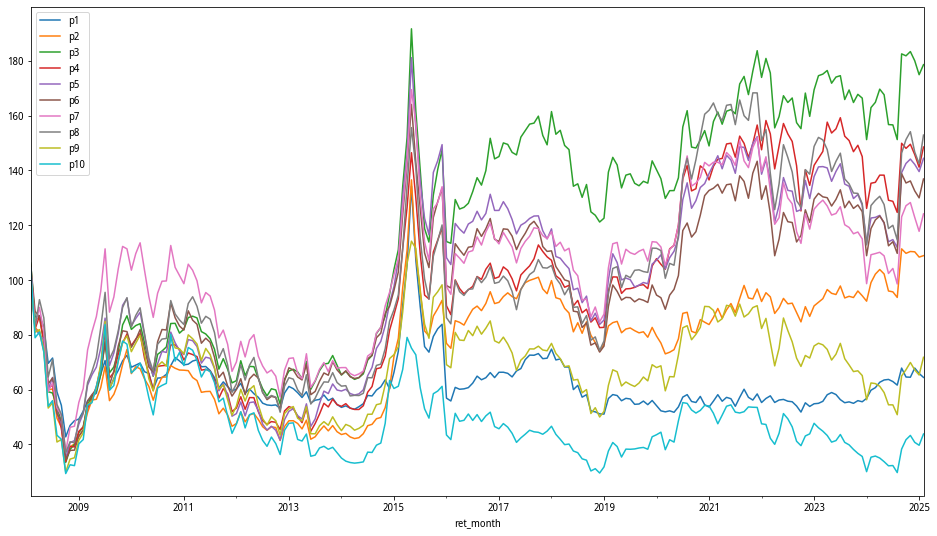

In [363]:
((1 + portfolios_vwret_df).cumprod()*100).plot()

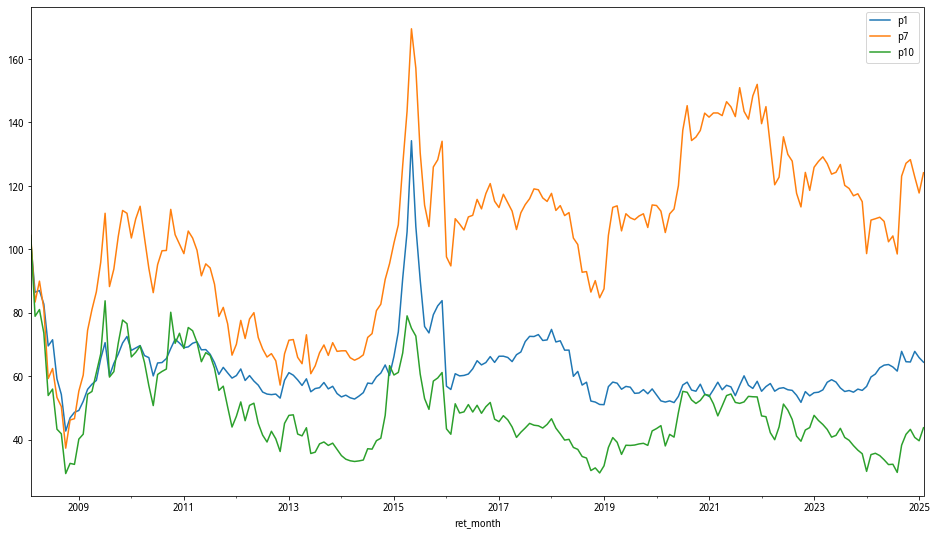

In [364]:
((1 + portfolios_vwret_df[['p1','p7','p10']]).cumprod()*100).plot()

- p1, p10 收益率较接近
- p2, p9 收益率较接近
- p3~p8 收益率较接近

## Portfolio characteristics other than return

In [365]:
portfolios['p1']

secID group_month  Beta252       mkt_cap ret_month       ret  \
0      000014.XSHE     2008-01   0.4627  1.403297e+09   2008-02  0.068538   
1      000025.XSHE     2008-01   0.6821  6.126209e+08   2008-02  0.012529   
2      000043.XSHE     2008-01   0.6951  1.923207e+09   2008-02 -0.030003   
3      000061.XSHE     2008-01   0.6451  7.853670e+09   2008-02  0.013429   
4      000063.XSHE     2008-01   0.6956  3.810920e+10   2008-02 -0.042427   
5      000068.XSHE     2008-01   0.6435  2.470696e+09   2008-02 -0.055886   
6      000070.XSHE     2008-01   0.6400  1.359064e+09   2008-02  0.025286   
7      000400.XSHE     2008-01   0.5563  6.912566e+09   2008-02  0.000000   
8      000418.XSHE     2008-01   0.6245  2.920138e+09   2008-02 -0.094069   
9      000423.XSHE     2008-01   0.6953  1.207210e+10   2008-02  0.075998   
...            ...         ...      ...           ...       ...       ...   
60587  605169.XSHG     2025-01   0.6607  2.857088e+09   2025-02 -0.029732   
60588  605178.XSHG     2025-01   0.4866  1.643606e+09   2025-02  0.077922   
60589  605259.XSHG     2025-01   0.7612  2.730358e+09   2025-02 -0.001268   
60590  605268.XSHG     2025-01   0.7207  3.496720e+09   2025-02  0.038652   
60591  605318.XSHG     2025-01   0.3562  2.527153e+09   2025-02  0.055693   
60592  605368.XSHG     2025-01   0.5164  7.412676e+09   2025-02 -0.061401   
60593  605499.XSHG     2025-01   0.5701  1.264412e+11   2025-02 -0.090150   
60594  605580.XSHG     2025-01   0.5927  3.074400e+09   2025-02 -0.026404   
60595  605599.XSHG     2025-01   0.7679  8.742222e+09   2025-02  0.021369   
60596  688726.XSHG     2025-01  -0.9686  1.416719e+09   2025-02  0.190476   

          exret   mkt_cap_sum    weight  weighted_exret  
0      0.064785  7.725054e+11  0.001817    1.176845e-04  
1      0.008776  7.725054e+11  0.000793    6.959337e-06  
2     -0.033756  7.725054e+11  0.002490   -8.403915e-05  
3      0.009676  7.725054e+11  0.010166    9.836644e-05  
4     -0.046180  7.725054e+11  0.049332   -2.278161e-03  
5     -0.059639  7.725054e+11  0.003198   -1.907432e-04  
6      0.021533  7.725054e+11  0.001759    3.788338e-05  
7     -0.003753  7.725054e+11  0.008948   -3.358276e-05  
8     -0.097822  7.725054e+11  0.003780   -3.697767e-04  
9      0.072245  7.725054e+11  0.015627    1.128986e-03  
...         ...           ...       ...             ...  
60587 -0.031800  2.194892e+13  0.000130   -4.139461e-06  
60588  0.075854  2.194892e+13  0.000075    5.680157e-06  
60589 -0.003336  2.194892e+13  0.000124   -4.150161e-07  
60590  0.036584  2.194892e+13  0.000159    5.828225e-06  
60591  0.053625  2.194892e+13  0.000115    6.174251e-06  
60592 -0.063469  2.194892e+13  0.000338   -2.143510e-05  
60593 -0.092218  2.194892e+13  0.005761   -5.312393e-04  
60594 -0.028472  2.194892e+13  0.000140   -3.988115e-06  
60595  0.019301  2.194892e+13  0.000398    7.687506e-06  
60596  0.188408  2.194892e+13  0.000065    1.216103e-05  

[60597 rows x 10 columns]

In [366]:
# average beta in each portfolio
for key in portfolios.keys():
    print(portfolios[key].groupby('group_month')['Beta252'].mean().mean())  

0.4608610508577476
0.6919615617884579
0.7897118920818266
0.8609090855711198
0.923035262972178
0.9831539446980601
1.0465306080683217
1.1194870887636243
1.2165063839426051
1.4313277153249542


In [367]:
portfolios['p1'].groupby('group_month')['secID'].nunique()

group_month
2008-01    129
2008-02    129
2008-03    131
2008-04    131
2008-05    134
2008-06    137
2008-07    139
2008-08    140
2008-09    143
2008-10    142
          ... 
2024-04    492
2024-05    492
2024-06    495
2024-07    496
2024-08    496
2024-09    496
2024-10    497
2024-11    497
2024-12    498
2025-01    498
Freq: M, Name: secID, Length: 205, dtype: int64

p1   p2   p3   p4   p5   p6   p7   p8   p9  p10
group_month                                                  
2008-01      129  129  128  130  130  130  130  130  129  129
2008-02      129  129  129  129  129  131  129  129  129  129
2008-03      131  131  131  132  132  131  131  131  131  131
2008-04      131  131  131  131  131  132  132  131  131  131
2008-05      134  134  134  134  134  134  134  134  134  134
2008-06      137  137  137  138  139  137  138  138  137  137
2008-07      139  139  139  138  139  139  139  139  140  139
2008-08      140  140  140  139  140  140  139  141  141  140
2008-09      143  142  141  141  141  141  142  142  141  142
2008-10      142  142  142  142  142  142  142  142  142  142
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2024-04      492  492  492  492  492  492  493  492  492  492
2024-05      492  494  493  493  495  494  492  492  492  492
2024-06      495  496  497  495  495  495  494  495  495  495
2024-07      496  496  496  495  496  497  496  496  496  496
2024-08      496  496  496  498  496  497  497  496  496  496
2024-09      496  495  495  496  495  495  497  496  495  496
2024-10      497  498  498  496  497  496  496  496  496  496
2024-11      497  497  498  496  497  496  496  496  496  497
2024-12      498  496  497  496  497  497  496  497  497  497
2025-01      498  497  498  499  498  499  498  497  497  498

[205 rows x 10 columns]

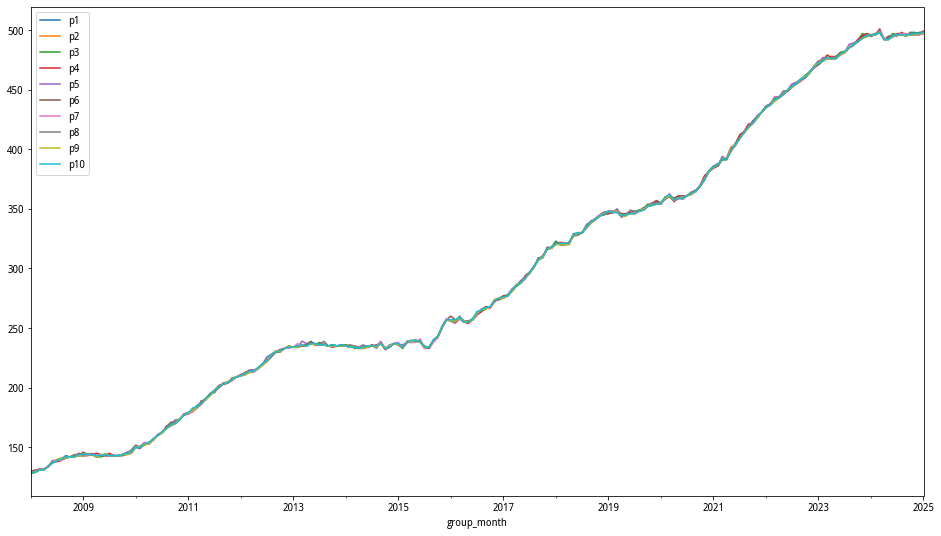

In [368]:
pf_n_stks = pd.DataFrame()
for key, value in portfolios.items():
    pf_n_stks[key] = portfolios[key].groupby('group_month')['secID'].nunique()

display(pf_n_stks)

pf_n_stks.plot()

In [369]:
portfolios['p1'].groupby('group_month')['mkt_cap'].mean()

group_month
2008-01    5.988414e+09
2008-02    6.071667e+09
2008-03    7.076361e+09
2008-04    7.849329e+09
2008-05    7.669383e+09
2008-06    7.154119e+09
2008-07    6.520907e+09
2008-08    6.432081e+09
2008-09    4.571608e+09
2008-10    3.605990e+09
               ...     
2024-04    4.162092e+10
2024-05    4.357053e+10
2024-06    4.662101e+10
2024-07    4.140044e+10
2024-08    3.987719e+10
2024-09    4.351429e+10
2024-10    4.255183e+10
2024-11    4.248589e+10
2024-12    4.245510e+10
2025-01    4.407415e+10
Freq: M, Name: mkt_cap, Length: 205, dtype: float64

p1            p2            p3            p4  \
group_month                                                           
2008-01      5.988414e+09  5.306428e+09  4.535321e+09  7.362864e+09   
2008-02      6.071667e+09  6.313570e+09  4.450242e+09  3.349407e+09   
2008-03      7.076361e+09  3.808170e+09  4.911187e+09  7.796002e+09   
2008-04      7.849329e+09  8.625458e+09  5.638841e+09  8.013270e+09   
2008-05      7.669383e+09  5.750247e+09  6.431120e+09  6.858780e+09   
2008-06      7.154119e+09  4.890143e+09  5.751949e+09  5.419566e+09   
2008-07      6.520907e+09  4.565857e+09  5.766865e+09  4.164652e+09   
2008-08      6.432081e+09  5.239007e+09  6.930824e+09  2.574558e+09   
2008-09      4.571608e+09  5.188747e+09  3.513861e+09  3.308462e+09   
2008-10      3.605990e+09  2.821275e+09  2.080784e+09  2.390822e+09   
...                   ...           ...           ...           ...   
2024-04      4.162092e+10  1.560820e+10  1.242538e+10  1.024660e+10   
2024-05      4.357053e+10  1.533917e+10  1.025297e+10  1.205798e+10   
2024-06      4.662101e+10  1.078560e+10  9.837461e+09  1.121072e+10   
2024-07      4.140044e+10  1.349619e+10  9.303565e+09  9.333083e+09   
2024-08      3.987719e+10  1.304240e+10  9.982006e+09  7.873391e+09   
2024-09      4.351429e+10  1.255275e+10  1.097226e+10  1.144528e+10   
2024-10      4.255183e+10  1.201264e+10  1.072462e+10  1.523881e+10   
2024-11      4.248589e+10  1.211026e+10  1.413234e+10  1.226477e+10   
2024-12      4.245510e+10  1.260505e+10  1.107244e+10  1.625016e+10   
2025-01      4.407415e+10  1.228974e+10  1.402895e+10  1.099233e+10   

                       p5            p6            p7            p8  \
group_month                                                           
2008-01      4.275197e+09  4.570363e+09  5.207295e+09  8.224317e+09   
2008-02      7.121173e+09  9.663643e+09  5.606236e+09  7.073906e+09   
2008-03      5.353836e+09  4.150682e+09  5.239776e+09  5.254682e+09   
2008-04      3.559938e+09  3.569421e+09  4.492496e+09  4.272782e+09   
2008-05      5.188246e+09  3.067216e+09  3.345305e+09  3.895424e+09   
2008-06      2.603376e+09  2.736068e+09  2.563974e+09  2.300939e+09   
2008-07      2.960881e+09  3.456644e+09  3.949624e+09  2.483859e+09   
2008-08      3.009162e+09  1.882631e+09  1.785952e+09  1.684172e+09   
2008-09      3.348617e+09  1.635335e+09  3.225654e+09  2.304676e+09   
2008-10      1.753199e+09  2.899854e+09  1.347567e+09  2.054163e+09   
...                   ...           ...           ...           ...   
2024-04      9.493786e+09  1.024901e+10  9.604638e+09  1.113230e+10   
2024-05      9.077545e+09  1.034249e+10  8.282712e+09  1.164610e+10   
2024-06      7.197305e+09  1.040541e+10  7.533992e+09  1.032263e+10   
2024-07      1.031424e+10  1.170598e+10  7.331947e+09  8.905684e+09   
2024-08      9.654660e+09  1.181505e+10  9.193809e+09  7.417346e+09   
2024-09      1.176853e+10  1.580062e+10  1.367405e+10  9.209635e+09   
2024-10      1.658813e+10  1.459385e+10  1.345661e+10  8.398194e+09   
2024-11      1.266708e+10  1.759312e+10  1.284857e+10  1.006257e+10   
2024-12      1.026824e+10  1.626454e+10  1.465393e+10  9.610194e+09   
2025-01      1.032358e+10  1.510365e+10  1.402370e+10  1.068700e+10   

                       p9           p10  
group_month                              
2008-01      6.124010e+09  7.866920e+09  
2008-02      8.515568e+09  8.749623e+09  
2008-03      3.647224e+09  6.548070e+09  
2008-04      4.945515e+09  5.261438e+09  
2008-05      5.420263e+09  5.255256e+09  
2008-06      3.446538e+09  3.539366e+09  
2008-07      3.167746e+09  4.715199e+09  
2008-08      3.373499e+09  2.407156e+09  
2008-09      1.979873e+09  3.899405e+09  
2008-10      1.964777e+09  3.581047e+09  
...                   ...           ...  
2024-04      9.036532e+09  1.050532e+10  
2024-05      8.236870e+09  1.002374e+10  
2024-06      8.090460e+09  1.014898e+10  
2024-07      9.523034e+09  1.020811e+10  
2024-08      8.775257e+09  9.483788e+09  

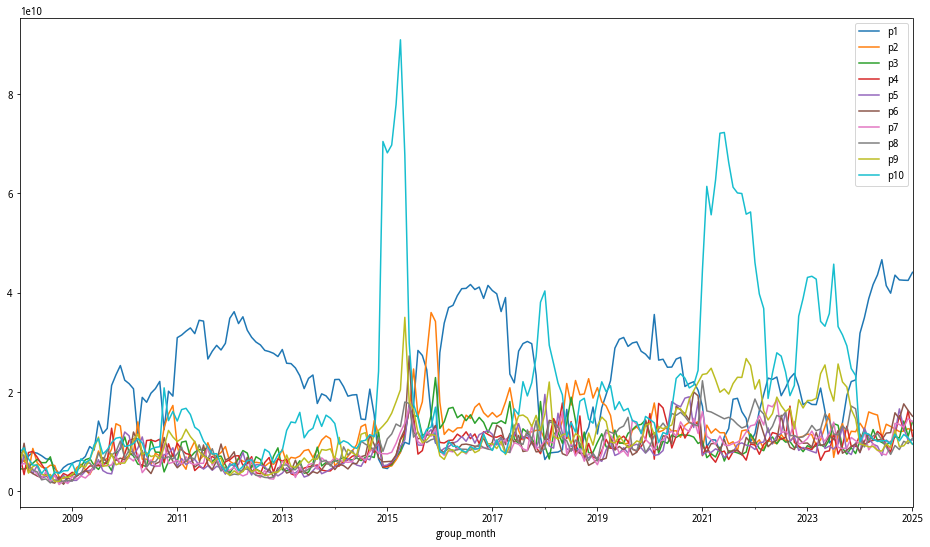

In [370]:
pf_mktcap = pd.DataFrame()
for key, value in portfolios.items():
    pf_mktcap[key] = portfolios[key].groupby('group_month')['mkt_cap'].mean()

display(pf_mktcap)

pf_mktcap.plot()

- p1 是小beta股票，市值在某些时候和其他组很不一样
- p10 是高beta股票，在2015, 2021前后有大起大落
- 其他的股票在这段时间里波动不大
- 沪深300指数的制定就是围绕p9, p10

In [371]:
pf_mktcap = pf_mktcap / 1e10
for i in range(10):
    print(pf_mktcap.mean()[i])

2.1970289102885316
1.103796799801871
0.9055359059813348
0.8578342254730904
0.8128239505335122
0.835239278995747
0.8320310021473433
0.9286744328690734
1.1232733113113056
1.9257120500959595


## beta 单排结论

排序方法：按照上月末 beta252 分十组，考察下月各组合简单平均收益率、市值加权收益率

结论：
- 各组合日收益率没有明显区别: CAPM 在中国市场也不成立
- p1, p10 累积收益率较接近
- p2, p9 累积收益率较接近
- p3~p8 累积收益率较接近
- 最小beta组合市值较大，最大beta组合市值较大
- 指数的起落不一定是全市场的变化，有时在个股（或分组）层面存在严重的分化
- 按beta分组的市值画图：
    - p1 是小beta股票，市值在某些时候和其他组很不一样
    - p9, p10 是高beta股票，在2015, 2021前后有大起大落
    - 其他的股票在这段时间里波动不大
    - 沪深300指数的制定就是围绕p9, p10

# Sorting on Market Capitalization

## The Size Effect

size-effect 指的是小市值股票的收益率比大市值股票更好. Fama and French (1992, 1993) 是最著名的两篇文章. 但这个现象更早就被发现了, 例如 Banz (1981), Shapiro (1986). Fama and French (2012) 说在全球市场都有类似的现象.

FF (1992) 总结了这个现象的已有文献并进一步做了检验, FF(1993)在此基础上构建了SMB因子, 并发现所谓Fama French 3 因子模型比 CAPM 表现更好.

FF 的市值是这样计算的: t年6月底的股价 * t年6月底的股本数, 也即: 

$$MktCap_{i,t}^{FF} = \frac{ShareOut_{i, June} \times Price_{i, June}}{1000}$$

作为t年至t+1年的市值分类标准. 这样做是为了避免价格的频繁变动本身带来的市值和收益率之间的相关性.

对于美国数据, ShareOut是按照1000股来衡量的, 上式再除以1000, 则$MktCap$的量纲就是"百万美元".

另外一种算法更直接:

$$MktCap_{i,t} = \frac{ShareOut_{i, t} \times Price_{i, t}}{1000}$$

对于美国市场, 两种算法得到的结果差别不大.

在做回归分析的时候, 一般还会把$MktCap$取log, 因为一般来讲会有一小部分股票有极大的市值, 而大部分股票的市值与其相比很小. 回归会收到这个影响. 而排序不会.

我们在中国市场看看小市值股票是否比大市值股票表现更好. 简单起见, 我们用后一种MktCap算法.

## Distribution of Market Capitalization

In [372]:
ret_df['mkt_cap'] = ret_df['mkt_cap'] / 1e6

In [373]:
ret_df['size'] = np.log(ret_df['mkt_cap'])

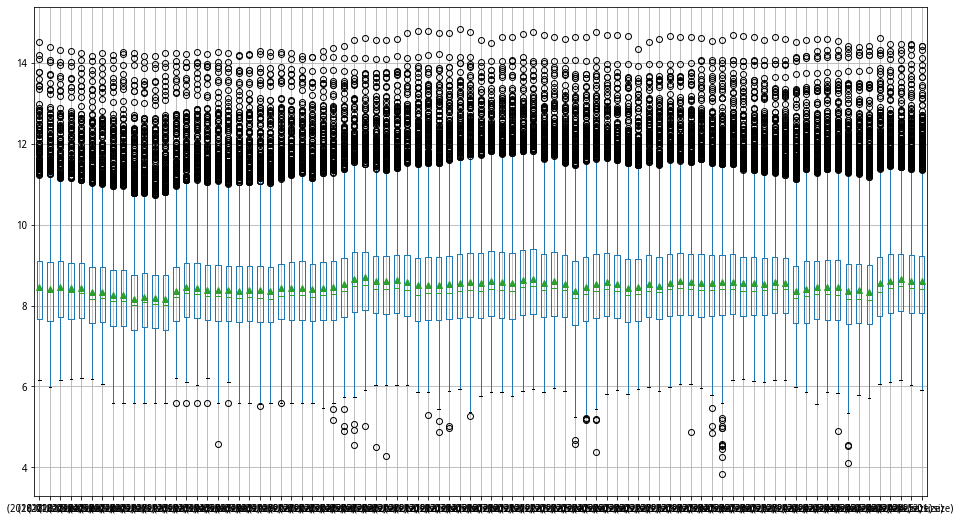

In [374]:
mktcap_group = ret_df.loc[ret_df['group_month'] >= '2018',['group_month','size']].groupby('group_month')

mktcap_group.boxplot(subplots=False, showmeans=True)

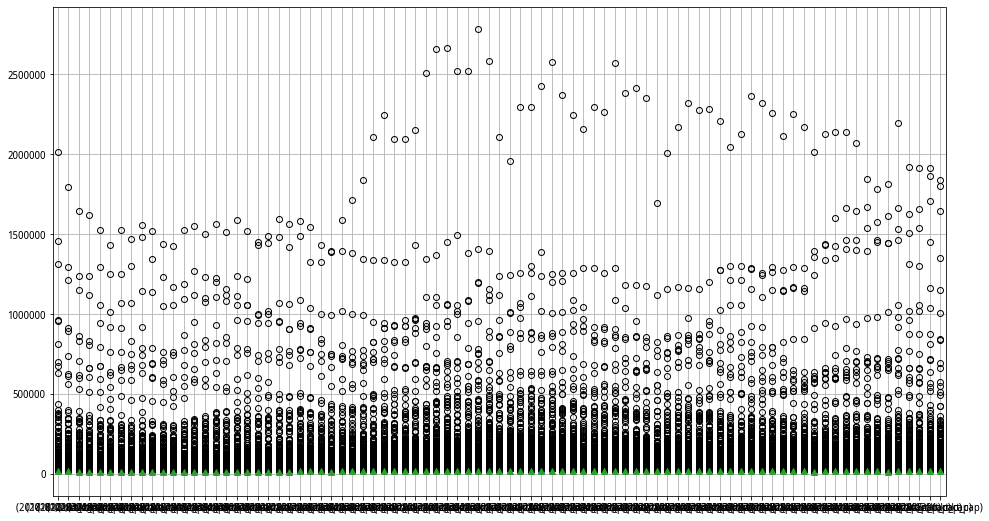

In [375]:
mktcap_group = ret_df.loc[ret_df['group_month'] >= '2018',['group_month','mkt_cap']].groupby('group_month')

mktcap_group.boxplot(subplots=False, showmeans=True)

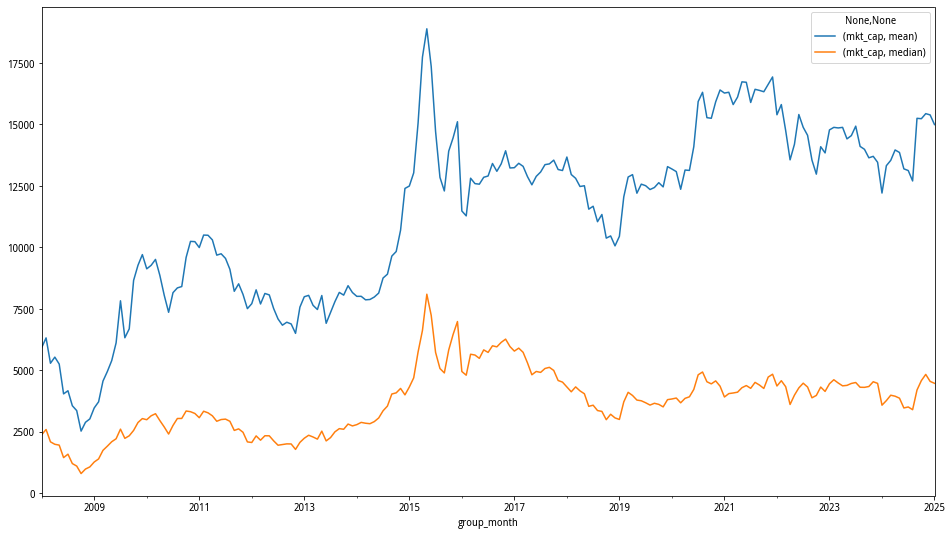

In [376]:
mktcap_group = ret_df.loc[:,['group_month','mkt_cap']].groupby('group_month')

mktcap_group.agg([np.mean, np.median]).plot()

## Average return of porfolios sorted by market cap

In [377]:
q = dict()
keys = ['q'+str(i) for i in range(1, 10)]
values = np.arange(0.1, 1.0, 0.1)
q.update(zip(keys,values))

quantile_df = pd.DataFrame()
for key, value in q.items():
    quantile_df[key] = ret_df.groupby(['group_month'])['mkt_cap'].quantile(value)

display(quantile_df)

ret_df_q = pd.merge(ret_df, quantile_df, on='group_month')

display(ret_df_q)

portfolios = dict()

portfolios['p1'] = ret_df_q.loc[ret_df_q['mkt_cap'] <= ret_df_q['q1'],['secID','group_month','mkt_cap','Beta252','ret_month','exret']].copy()
for i in range(2,10):
    idx = (ret_df_q[f'q{i-1}'] <= ret_df_q['mkt_cap']) & (ret_df_q['mkt_cap'] <= ret_df_q[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q.loc[idx,['secID','group_month','mkt_cap','Beta252','ret_month','exret']].copy()
portfolios['p10'] = ret_df_q.loc[ret_df_q['mkt_cap'] >= ret_df_q['q9'],['secID','group_month','mkt_cap','Beta252','ret_month','exret']].copy()

for k in portfolios.keys():
    print(portfolios[k].groupby(['ret_month'])['exret'].mean().mean())

q1           q2           q3           q4           q5  \
group_month                                                                    
2008-01       795.016590  1100.014062  1410.548482  1878.758934  2384.214165   
2008-02       872.850607  1204.255760  1552.685411  2101.593779  2595.159247   
2008-03       711.697043   998.235360  1299.349361  1698.617128  2092.110302   
2008-04       637.394100   905.255189  1211.306111  1599.444372  1992.281850   
2008-05       622.593900   889.219117  1182.169438  1568.628125  1959.328190   
2008-06       452.390040   656.423955   864.537026  1119.328375  1450.418727   
2008-07       504.671749   722.676103   941.735865  1226.745414  1589.948028   
2008-08       395.825556   553.534657   732.363863   927.617798  1208.196646   
2008-09       346.650881   512.730198   668.349766   858.126452  1106.588629   
2008-10       259.401270   381.201963   496.388209   634.393956   801.926753   
...                  ...          ...          ...          ...          ...   
2024-04      1146.956589  1800.360000  2393.326900  3084.453960  3948.041580   
2024-05      1182.308240  1806.904774  2367.053268  3035.159062  3867.630286   
2024-06      1101.785493  1636.318506  2150.880961  2731.846925  3469.894645   
2024-07      1132.780349  1663.144512  2190.123950  2749.724439  3510.381109   
2024-08      1112.337642  1644.724851  2143.728124  2684.769886  3399.007766   
2024-09      1378.111325  2019.177620  2640.280788  3331.132762  4198.616688   
2024-10      1484.035346  2130.934578  2812.274340  3611.604196  4583.212890   
2024-11      1583.196579  2269.900306  2983.672636  3814.090671  4834.473576   
2024-12      1471.635938  2163.222812  2827.065487  3633.208732  4550.547562   
2025-01      1475.160976  2131.501557  2758.675085  3519.686082  4472.754740   

                      q6           q7            q8            q9  
group_month                                                        
2008-01      3071.055078  4182.518956   6379.121434  11186.622957  
2008-02      3352.125880  4488.085941   6756.867451  11932.996059  
2008-03      2667.207844  3540.940603   5366.008436   9524.576012  
2008-04      2642.766074  3587.041918   5509.465235   9823.073376  
2008-05      2549.822583  3485.260162   5070.686413   9077.040000  
2008-06      1845.107546  2547.898260   3760.302045   7005.268157  
2008-07      2006.315713  2747.926214   4068.660566   7175.172625  
2008-08      1552.956829  2104.754855   3056.290269   5483.726048  
2008-09      1428.500471  1959.735025   3015.529848   5589.700794  
2008-10      1054.841103  1431.647191   2235.573578   3980.357860  
...                  ...          ...           ...           ...  
2024-04      5173.081290  7496.702304  12055.672197  23742.032536  
2024-05      5110.686847  7365.044694  11757.145473  23328.052132  
2024-06      4595.758699  6702.478890  10913.630820  21764.251557  
2024-07      4624.256424  6731.480112  10848.992352  21577.101768  
2024-08      4473.167029  6381.507780  10379.372988  20693.423593  
2024-09      5581.514834  7952.049324  12784.829066  25033.938369  
2024-10      6082.942756  8492.344614  13363.643311  25524.765840  
2024-11      6326.423597  8718.007562  13680.321673  25620.748151  
2024-12      6021.970711  8416.412053  13097.544732  25165.567185  
2025-01      5908.176960  8277.598078  12819.719374  24558.931356  

[205 rows x 9 columns]

secID ret_month       ret        rf     exret group_month  \
0       000001.XSHE   2008-02 -0.004504  0.003753 -0.008257     2008-01   
1       000002.XSHE   2008-02 -0.107485  0.003753 -0.111238     2008-01   
2       000006.XSHE   2008-02  0.014997  0.003753  0.011244     2008-01   
3       000012.XSHE   2008-02  0.252739  0.003753  0.248986     2008-01   
4       000014.XSHE   2008-02  0.068538  0.003753  0.064785     2008-01   
5       000016.XSHE   2008-02  0.056906  0.003753  0.053153     2008-01   
6       000019.XSHE   2008-02  0.172807  0.003753  0.169054     2008-01   
7       000021.XSHE   2008-02  0.014759  0.003753  0.011006     2008-01   
8       000022.XSHE   2008-02  0.051616  0.003753  0.047863     2008-01   
9       000023.XSHE   2008-02  0.082056  0.003753  0.078303     2008-01   
...             ...       ...       ...       ...       ...         ...   
623101  688787.XSHG   2025-02 -0.260637  0.002068 -0.262705     2025-01   
623102  688788.XSHG   2025-02  0.862513  0.002068  0.860445     2025-01   
623103  688789.XSHG   2025-02 -0.008657  0.002068 -0.010725     2025-01   
623104  688793.XSHG   2025-02  0.122370  0.002068  0.120302     2025-01   
623105  688798.XSHG   2025-02  0.032959  0.002068  0.030891     2025-01   
623106  688799.XSHG   2025-02 -0.047997  0.002068 -0.050065     2025-01   
623107  688800.XSHG   2025-02 -0.241236  0.002068 -0.243304     2025-01   
623108  688819.XSHG   2025-02  0.080032  0.002068  0.077964     2025-01   
623109  688981.XSHG   2025-02  0.040984  0.002068  0.038916     2025-01   
623110  689009.XSHG   2025-02  0.113168  0.002068  0.111100     2025-01   

              mkt_cap  Beta252       size           q1           q2  \
0        58502.124282   0.9654  10.976818   795.016590  1100.014062   
1       153263.245763   1.0823  11.939912   795.016590  1100.014062   
2         6013.791342   1.0654   8.701811   795.016590  1100.014062   
3         7047.868859   1.1439   8.860481   795.016590  1100.014062   
4         1403.297367   0.4627   7.246580   795.016590  1100.014062   
5         2412.904611   0.8504   7.788587   795.016590  1100.014062   
6         1196.602082   0.7957   7.087241   795.016590  1100.014062   
7         6228.621320   0.9856   8.736910   795.016590  1100.014062   
8         2543.495539   0.9005   7.841295   795.016590  1100.014062   
9          632.600660   1.0612   6.449839   795.016590  1100.014062   
...               ...      ...        ...          ...          ...   
623101    8082.370296   1.9190   8.997440  1475.160976  2131.501557   
623102    3383.932800   1.4162   8.126794  1475.160976  2131.501557   
623103   12435.975090   1.3512   9.428349  1475.160976  2131.501557   
623104    2247.472210   1.2820   7.717561  1475.160976  2131.501557   
623105    9768.850419   1.6557   9.186954  1475.160976  2131.501557   
623106    3929.282000   1.0245   8.276212  1475.160976  2131.501557   
623107   10710.769439   1.7329   9.279005  1475.160976  2131.501557   
623108   25760.650000   1.3536  10.156603  1475.160976  2131.501557   
623109  186786.453854   1.4862  12.137721  1475.160976  2131.501557   
623110   28225.140460   1.1695  10.247968  1475.160976  2131.501557   

                 q3           q4           q5           q6           q7  \
0       1410.548482  1878.758934  2384.214165  3071.055078  4182.518956   
1       1410.548482  1878.758934  2384.214165  3071.055078  4182.518956   
2       1410.548482  1878.758934  2384.214165  3071.055078  4182.518956   
3       1410.548482  1878.758934  2384.214165  3071.055078  4182.518956   
4       1410.548482  1878.758934  2384.214165  3071.055078  4182.518956   
5       1410.548482  1878.758934  2384.214165  3071.055078  4182.518956   
6       1410.548482  1878.758934  2384.214165  3071.055078  4182.518956   
7       1410.548482  1878.758934  2384.214165  3071.055078  4182.518956   
8       1410.548482  1878.758934  2384.214165  3071.055078  4182.518956   
9       1410.548482  1878.758934  2384.214165  307

0.01620504808929847
0.014749148531295579
0.013480095598143246
0.01017587199763356
0.006563638230063193
0.004691207424768661
0.0033215492442680407
0.0026815064731480977
0.0010361632945337321
0.0002581174653960262


### More robust by adjusting Newey-West errors

In [378]:
portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_month'])['exret'].mean()

In [379]:
portfolios_crs_mean['p1']

ret_month
2008-02    0.087235
2008-03   -0.171130
2008-04   -0.084828
2008-05   -0.029536
2008-06   -0.229648
2008-07    0.120577
2008-08   -0.223030
2008-09   -0.117506
2008-10   -0.239415
2008-11    0.235873
             ...   
2024-05    0.025915
2024-06   -0.064163
2024-07    0.005691
2024-08   -0.041327
2024-09    0.207723
2024-10    0.058864
2024-11    0.068529
2024-12   -0.060769
2025-01   -0.003548
2025-02    0.089427
Freq: M, Name: exret, Length: 205, dtype: float64

In [380]:
mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]

In [381]:
mean_values

{'p1': 0.016205048089298475,
 'p2': 0.014749148531295567,
 'p3': 0.013480095598143248,
 'p4': 0.010175871997633557,
 'p5': 0.006563638230063195,
 'p6': 0.004691207424768658,
 'p7': 0.003321549244268039,
 'p8': 0.002681506473148097,
 'p9': 0.0010361632945337326,
 'p10': 0.00025811746539602725,
 'p10-p1': -0.015946930623902456}

In [382]:
t_values

{'p1': 2.1008218272818993,
 'p2': 2.0395750463059104,
 'p3': 1.9463528728826547,
 'p4': 1.5317364442917483,
 'p5': 1.016012332455728,
 'p6': 0.7047674614532008,
 'p7': 0.5166246520544792,
 'p8': 0.42349546272763666,
 'p9': 0.1684355791756016,
 'p10': 0.043436764209578434,
 'p10-p1': -2.899937140292741}

In [383]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.016205  0.014749  0.013480  0.010176  0.006564  0.004691  0.003322   
t-value  2.100822  2.039575  1.946353  1.531736  1.016012  0.704767  0.516625   

               p8        p9       p10    p10-p1  
mean     0.002682  0.001036  0.000258 -0.015947  
t-value  0.423495  0.168436  0.043437 -2.899937

## Portfolio characteristics other than return

In [384]:
# average mktcap in each portfolio
for key in portfolios.keys():
    print(portfolios[key].groupby('group_month')['mkt_cap'].mean().mean())  

851.1794727274313
1479.156947166611
2042.4943267539816
2625.866298045977
3307.6769874795186
4211.534407160654
5567.442386098475
7938.289067030683
13239.975623038636
71634.87002611127


In [385]:
portfolios['p1'].groupby('group_month')['secID'].nunique()

group_month
2008-01    134
2008-02    135
2008-03    137
2008-04    136
2008-05    138
2008-06    141
2008-07    142
2008-08    143
2008-09    144
2008-10    144
          ... 
2024-04    494
2024-05    494
2024-06    496
2024-07    496
2024-08    497
2024-09    497
2024-10    498
2024-11    498
2024-12    499
2025-01    499
Freq: M, Name: secID, Length: 205, dtype: int64

In [386]:
pf_n_stks = pd.DataFrame()
for key, value in portfolios.items():
    pf_n_stks[key] = portfolios[key].groupby('group_month')['secID'].nunique()

In [387]:
pf_n_stks

p1   p2   p3   p4   p5   p6   p7   p8   p9  p10
group_month                                                  
2008-01      134  134  134  134  134  134  134  134  134  134
2008-02      135  135  135  134  135  135  134  135  135  135
2008-03      137  136  136  136  136  136  136  136  136  137
2008-04      136  136  136  135  136  136  135  136  136  136
2008-05      138  137  138  137  138  138  137  138  137  138
2008-06      141  140  141  140  141  141  140  141  140  141
2008-07      142  142  142  142  142  142  142  142  142  142
2008-08      143  143  142  143  143  143  143  142  143  143
2008-09      144  143  143  143  144  144  143  143  143  144
2008-10      144  144  144  143  144  144  143  144  144  144
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2024-04      494  494  494  493  494  494  494  494  494  494
2024-05      494  493  494  493  494  494  493  494  493  494
2024-06      496  496  496  496  496  496  496  496  496  496
2024-07      496  496  496  496  496  496  496  496  496  496
2024-08      497  496  496  496  497  497  496  496  496  497
2024-09      497  497  496  497  497  497  497  496  497  497
2024-10      498  497  498  497  498  498  497  498  497  498
2024-11      498  498  498  498  498  498  498  498  498  498
2024-12      499  498  498  498  499  499  498  498  498  499
2025-01      499  499  499  499  499  499  499  499  499  499

[205 rows x 10 columns]

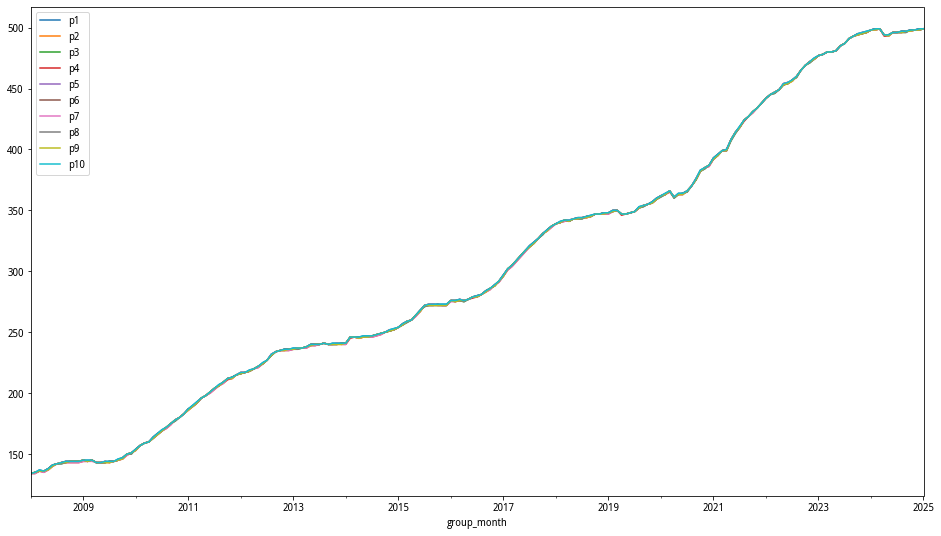

In [388]:
pf_n_stks.plot()

In [389]:
portfolios['p1']

secID group_month      mkt_cap  Beta252 ret_month     exret
9       000023.XSHE     2008-01   632.600660   1.0612   2008-02  0.078303
11      000025.XSHE     2008-01   612.620870   0.6821   2008-02  0.008776
25      000045.XSHE     2008-01   407.635472   0.9257   2008-02  0.051406
27      000049.XSHE     2008-01   723.852394   0.9499   2008-02  0.044037
96      000526.XSHE     2008-01   514.548830   0.8734   2008-02  0.073032
141     000591.XSHE     2008-01   724.063061   0.8757   2008-02  0.049395
165     000626.XSHE     2008-01   606.544000   0.9976   2008-02  0.200978
173     000639.XSHE     2008-01   787.216061   0.6699   2008-02 -0.003753
185     000669.XSHE     2008-01   475.115916   0.9260   2008-02  0.185157
186     000671.XSHE     2008-01   739.554371      NaN   2008-02 -0.003753
...             ...         ...          ...      ...       ...       ...
623049  688671.XSHG     2025-01   787.505152   1.7812   2025-02  0.075504
623053  688679.XSHG     2025-01  1290.559060   1.3151   2025-02  0.075389
623055  688681.XSHG     2025-01  1238.246100   1.2192   2025-02  0.063909
623065  688693.XSHG     2025-01  1152.796190   2.1497   2025-02  0.067129
623066  688695.XSHG     2025-01   562.616040   1.8769   2025-02  0.109482
623072  688701.XSHG     2025-01   581.532922   1.5277   2025-02  0.064576
623077  688710.XSHG     2025-01   889.964024   1.2403   2025-02  0.128962
623084  688721.XSHG     2025-01  1258.529295   1.5095   2025-02  0.054163
623086  688726.XSHG     2025-01  1416.718800  -0.9686   2025-02  0.188408
623089  688737.XSHG     2025-01  1146.524122   1.4771   2025-02  0.125799

[62398 rows x 6 columns]

In [390]:
pf_beta = pd.DataFrame()
for key, value in portfolios.items():
    pf_beta[key] = portfolios[key].groupby('group_month')['Beta252'].mean()

In [391]:
for col in pf_beta.columns:
    print(pf_beta.loc[:,col].mean())

0.949410358295842
0.9352041527186242
0.9269793229313863
0.9288582941462372
0.9343479728679062
0.9479679540925281
0.9567032822915198
0.9677356322528876
0.9789624927433236
0.9930954894996449


## Market Capitalization 单排结论

排序方法：上月末市值按大小分成10组，考察下月收益率

- 收益率随市值增大减小
- p1, p2, p3收益率显著大于0
- 各组之间beta无显著区别

### Different time periods

In [401]:
ret_df_q_ = ret_df_q[(ret_df_q['group_month']>='2015') & (ret_df_q['group_month']<='2024')].copy()

In [399]:
ret_df_q_ = ret_df_q[(ret_df_q['group_month']>='2008') & (ret_df_q['group_month']<='2014')].copy()

In [402]:
portfolios = dict()

portfolios['p1'] = ret_df_q_.loc[ret_df_q_['mkt_cap'] <= ret_df_q_['q1'],['secID','group_month','mkt_cap','Beta252','ret_month','exret']].copy()
for i in range(2,10):
    idx = (ret_df_q_[f'q{i-1}'] <= ret_df_q_['mkt_cap']) & (ret_df_q_['mkt_cap'] <= ret_df_q_[f'q{i}'])
    portfolios[f'p{i}'] = ret_df_q_.loc[idx,['secID','group_month','mkt_cap','Beta252','ret_month','exret']].copy()
portfolios['p10'] = ret_df_q_.loc[ret_df_q_['mkt_cap'] >= ret_df_q_['q9'],['secID','group_month','mkt_cap','Beta252','ret_month','exret']].copy()
portfolios_crs_mean = dict()
for k in portfolios.keys():
    portfolios_crs_mean[k] = portfolios[k].groupby(['ret_month'])['exret'].mean()
mean_values = {}
t_values = {}
for k in portfolios_crs_mean.keys():
    y = portfolios_crs_mean[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]
# Portfolio 10-1
y = portfolios_crs_mean['p10'] - portfolios_crs_mean['p1']
const = np.full(shape=len(y), fill_value=1)
reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
mean_values['p10-p1'] = reg.params[0]
t_values['p10-p1'] = reg.tvalues[0]
pd.DataFrame([mean_values.values(),t_values.values()],index=['mean','t-value'],
             columns=mean_values.keys())

p1        p2        p3        p4        p5        p6        p7  \
mean     0.012277  0.010769  0.009896  0.006693  0.003599  0.000988 -0.000618   
t-value  1.304850  1.237981  1.272287  0.932652  0.517676  0.140255 -0.097384   

               p8        p9       p10    p10-p1  
mean     0.000709 -0.000235  0.000473 -0.011805  
t-value  0.108063 -0.038720  0.086803 -1.340700

In [403]:
del ret_df_q_
gc.collect()

253

In [404]:
stk_info[stk_info['secShortName']=='贵州茅台']

secID  ticker secShortName cnSpell exchangeCD assetClass  \
10861  600519.XSHG  600519         贵州茅台    GZMT       XSHG          E   

      listStatusCD    listDate transCurrCD          ISIN  partyID delistDate  
10861            L  2001-08-27         CNY  CNE0000018R8   1033.0        NaN

In [405]:
portfolios['p10'][portfolios['p10']['secID']=='600519.XSHG']

secID group_month       mkt_cap  Beta252 ret_month     exret
166019  600519.XSHG     2015-01  2.023392e+05   0.6428   2015-02  0.074196
168571  600519.XSHG     2015-02  2.181787e+05   0.6230   2015-03  0.021617
171148  600519.XSHG     2015-03  2.237859e+05   0.6383   2015-04  0.283313
173737  600519.XSHG     2015-04  2.880462e+05   0.7858   2015-05  0.043175
176357  600519.XSHG     2015-05  3.012933e+05   0.8677   2015-06 -0.025948
179012  600519.XSHG     2015-06  2.942358e+05   0.7722   2015-07 -0.103989
181717  600519.XSHG     2015-07  2.598194e+05   0.7062   2015-08 -0.058000
184440  600519.XSHG     2015-08  2.454234e+05   0.6397   2015-09 -0.028501
187164  600519.XSHG     2015-09  2.390670e+05   0.5981   2015-10  0.121128
189887  600519.XSHG     2015-10  2.686505e+05   0.5984   2015-11 -0.000430
...             ...         ...           ...      ...       ...       ...
517543  600519.XSHG     2023-04  2.211561e+06   1.0940   2023-05 -0.076690
522337  600519.XSHG     2023-05  2.046221e+06   1.0295   2023-06  0.052267
527176  600519.XSHG     2023-06  2.124230e+06   1.0377   2023-07  0.110347
532034  600519.XSHG     2023-07  2.362380e+06   1.0596   2023-08 -0.019564
536925  600519.XSHG     2023-08  2.320197e+06   0.9934   2023-09 -0.028039
541845  600519.XSHG     2023-09  2.259335e+06   1.0304   2023-10 -0.065313
546781  600519.XSHG     2023-10  2.116166e+06   1.0730   2023-11  0.061426
551731  600519.XSHG     2023-11  2.250478e+06   0.9928   2023-12 -0.027513
556688  600519.XSHG     2023-12  2.168197e+06   1.0418   2024-01 -0.072224
561658  600519.XSHG     2024-01  2.016084e+06   0.9656   2024-02  0.054066

[109 rows x 6 columns]

# Double Sorting on Beta and Market Capitalization

我们做 independent sort, mktcap 分2组，beta 分3组。mktcap的分位点是0.5，beta的分位点是0.3，0.7

In [406]:
q_mktcap = dict()
keys = ['q_mktcap_1']
values = [0.5]
q_mktcap.update(zip(keys,values))

q_beta = dict()
keys = ['q_beta_1','q_beta_2']
values = [0.3, 0.7]
q_beta.update(zip(keys,values))

q_mktcap_df = pd.DataFrame()
for key, value in q_mktcap.items():
    q_mktcap_df[key] = ret_df.groupby(['group_month'])['mkt_cap'].quantile(value)

q_beta_df = pd.DataFrame()
for key, value in q_beta.items():
    q_beta_df[key] = ret_df.groupby(['group_month'])['Beta252'].quantile(value)

In [407]:
q_mktcap_df

q_mktcap_1
group_month             
2008-01      2384.214165
2008-02      2595.159247
2008-03      2092.110302
2008-04      1992.281850
2008-05      1959.328190
2008-06      1450.418727
2008-07      1589.948028
2008-08      1208.196646
2008-09      1106.588629
2008-10       801.926753
...                  ...
2024-04      3948.041580
2024-05      3867.630286
2024-06      3469.894645
2024-07      3510.381109
2024-08      3399.007766
2024-09      4198.616688
2024-10      4583.212890
2024-11      4834.473576
2024-12      4550.547562
2025-01      4472.754740

[205 rows x 1 columns]

In [408]:
q_beta_df

q_beta_1  q_beta_2
group_month                    
2008-01       0.90618   1.06540
2008-02       0.90114   1.04566
2008-03       0.95349   1.09036
2008-04       0.99125   1.12423
2008-05       0.97344   1.11755
2008-06       1.00747   1.15830
2008-07       0.98890   1.14550
2008-08       1.04083   1.19858
2008-09       1.01043   1.14340
2008-10       0.98635   1.12185
...               ...       ...
2024-04       1.04565   1.50820
2024-05       1.06591   1.50033
2024-06       1.08660   1.49984
2024-07       1.09950   1.52030
2024-08       1.07940   1.53730
2024-09       0.98687   1.33780
2024-10       0.96224   1.38938
2024-11       0.95230   1.37437
2024-12       0.94101   1.34309
2025-01       0.96690   1.36462

[205 rows x 2 columns]

In [409]:
ret_df_q = pd.merge(ret_df, q_mktcap_df, on='group_month')
ret_df_q = pd.merge(ret_df_q, q_beta_df, on='group_month')

In [410]:
ret_df_q

secID ret_month       ret        rf     exret group_month  \
0       000001.XSHE   2008-02 -0.004504  0.003753 -0.008257     2008-01   
1       000002.XSHE   2008-02 -0.107485  0.003753 -0.111238     2008-01   
2       000006.XSHE   2008-02  0.014997  0.003753  0.011244     2008-01   
3       000012.XSHE   2008-02  0.252739  0.003753  0.248986     2008-01   
4       000014.XSHE   2008-02  0.068538  0.003753  0.064785     2008-01   
5       000016.XSHE   2008-02  0.056906  0.003753  0.053153     2008-01   
6       000019.XSHE   2008-02  0.172807  0.003753  0.169054     2008-01   
7       000021.XSHE   2008-02  0.014759  0.003753  0.011006     2008-01   
8       000022.XSHE   2008-02  0.051616  0.003753  0.047863     2008-01   
9       000023.XSHE   2008-02  0.082056  0.003753  0.078303     2008-01   
...             ...       ...       ...       ...       ...         ...   
623101  688787.XSHG   2025-02 -0.260637  0.002068 -0.262705     2025-01   
623102  688788.XSHG   2025-02  0.862513  0.002068  0.860445     2025-01   
623103  688789.XSHG   2025-02 -0.008657  0.002068 -0.010725     2025-01   
623104  688793.XSHG   2025-02  0.122370  0.002068  0.120302     2025-01   
623105  688798.XSHG   2025-02  0.032959  0.002068  0.030891     2025-01   
623106  688799.XSHG   2025-02 -0.047997  0.002068 -0.050065     2025-01   
623107  688800.XSHG   2025-02 -0.241236  0.002068 -0.243304     2025-01   
623108  688819.XSHG   2025-02  0.080032  0.002068  0.077964     2025-01   
623109  688981.XSHG   2025-02  0.040984  0.002068  0.038916     2025-01   
623110  689009.XSHG   2025-02  0.113168  0.002068  0.111100     2025-01   

              mkt_cap  Beta252       size   q_mktcap_1  q_beta_1  q_beta_2  
0        58502.124282   0.9654  10.976818  2384.214165   0.90618   1.06540  
1       153263.245763   1.0823  11.939912  2384.214165   0.90618   1.06540  
2         6013.791342   1.0654   8.701811  2384.214165   0.90618   1.06540  
3         7047.868859   1.1439   8.860481  2384.214165   0.90618   1.06540  
4         1403.297367   0.4627   7.246580  2384.214165   0.90618   1.06540  
5         2412.904611   0.8504   7.788587  2384.214165   0.90618   1.06540  
6         1196.602082   0.7957   7.087241  2384.214165   0.90618   1.06540  
7         6228.621320   0.9856   8.736910  2384.214165   0.90618   1.06540  
8         2543.495539   0.9005   7.841295  2384.214165   0.90618   1.06540  
9          632.600660   1.0612   6.449839  2384.214165   0.90618   1.06540  
...               ...      ...        ...          ...       ...       ...  
623101    8082.370296   1.9190   8.997440  4472.754740   0.96690   1.36462  
623102    3383.932800   1.4162   8.126794  4472.754740   0.96690   1.36462  
623103   12435.975090   1.3512   9.428349  4472.754740   0.96690   1.36462  
623104    2247.472210   1.2820   7.717561  4472.754740   0.96690   1.36462  
623105    9768.850419   1.6557   9.186954  4472.754740   0.96690   1.36462  
623106    3929.282000   1.0245   8.276212  4472.754740   0.96690   1.36462  
623107   10710.769439   1.7329   9.279005  4472.754740   0.96690   1.36462  
623108   25760.650000   1.3536  10.156603  4472.754740   0.96690   1.36462  
623109  186786.453854   1.4862  12.137721  4472.754740   0.96690   1.36462  
623110   28225.140460   1.1695  10.247968  4472.754740   0.96690   1.36462  

[623111 rows x 12 columns]

In [411]:
portfolios_mktcap = dict()
portfolios_mktcap['mktcap1'] = ret_df_q.loc[ret_df_q['mkt_cap'] <= ret_df_q['q_mktcap_1'],
                                           ['secID','group_month','ret_month','exret','mkt_cap']]
portfolios_mktcap['mktcap2'] = ret_df_q.loc[ret_df_q['mkt_cap'] >= ret_df_q['q_mktcap_1'],
                                           ['secID','group_month','ret_month','exret','mkt_cap']]

portfolios_beta = dict()
portfolios_beta['beta1'] = ret_df_q.loc[ret_df_q['Beta252'] <= ret_df_q['q_beta_1'],
                                           ['secID','group_month','ret_month','exret','Beta252']]
portfolios_beta['beta2'] = ret_df_q.loc[(ret_df_q['Beta252'] >= ret_df_q['q_beta_1']) & \
                                           (ret_df_q['Beta252'] <= ret_df_q['q_beta_2']),
                                           ['secID','group_month','ret_month','exret','Beta252']]
portfolios_beta['beta3'] = ret_df_q.loc[ret_df_q['Beta252'] >= ret_df_q['q_beta_2'],
                                           ['secID','group_month','ret_month','exret','Beta252']]

In [412]:
portfolios_mktcap

{'mktcap1':               secID group_month ret_month     exret      mkt_cap
 4       000014.XSHE     2008-01   2008-02  0.064785  1403.297367
 6       000019.XSHE     2008-01   2008-02  0.169054  1196.602082
 9       000023.XSHE     2008-01   2008-02  0.078303   632.600660
 11      000025.XSHE     2008-01   2008-02  0.008776   612.620870
 12      000026.XSHE     2008-01   2008-02  0.132926  1140.703607
 14      000028.XSHE     2008-01   2008-02  0.111910  2309.831755
 15      000029.XSHE     2008-01   2008-02  0.001609  1993.416810
 17      000032.XSHE     2008-01   2008-02  0.149756  1318.539623
 18      000033.XSHE     2008-01   2008-02  0.120837  1041.647321
 20      000037.XSHE     2008-01   2008-02  0.087993  1379.135174
 ...             ...         ...       ...       ...          ...
 623086  688726.XSHG     2025-01   2025-02  0.188408  1416.718800
 623088  688733.XSHG     2025-01   2025-02  0.046331  2992.565432
 623089  688737.XSHG     2025-01   2025-02  0.125799  1146.524122

In [413]:
portfolios_beta

{'beta1':               secID group_month ret_month     exret  Beta252
 4       000014.XSHE     2008-01   2008-02  0.064785   0.4627
 5       000016.XSHE     2008-01   2008-02  0.053153   0.8504
 6       000019.XSHE     2008-01   2008-02  0.169054   0.7957
 8       000022.XSHE     2008-01   2008-02  0.047863   0.9005
 11      000025.XSHE     2008-01   2008-02  0.008776   0.6821
 12      000026.XSHE     2008-01   2008-02  0.132926   0.7877
 24      000043.XSHE     2008-01   2008-02 -0.033756   0.6951
 30      000056.XSHE     2008-01   2008-02  0.015788   0.8563
 33      000061.XSHE     2008-01   2008-02  0.009676   0.6451
 35      000063.XSHE     2008-01   2008-02 -0.046180   0.6956
 ...             ...         ...       ...       ...      ...
 622717  688211.XSHG     2025-01   2025-02  0.106519   0.9462
 622739  688235.XSHG     2025-01   2025-02  0.248181   0.9568
 622851  688370.XSHG     2025-01   2025-02  0.026184   0.9239
 622876  688399.XSHG     2025-01   2025-02  0.038300   0.9214

In [414]:
portfolios = dict()
for beta_group in portfolios_beta.keys():
    for mktcap_group in portfolios_mktcap.keys():
        portfolios[f'{beta_group}_{mktcap_group}'] = pd.merge(portfolios_mktcap[mktcap_group],
                                                              portfolios_beta[beta_group][['secID','ret_month','Beta252']],
                                                              on=['secID','ret_month'])

In [415]:
portfolios

{'beta1_mktcap1':              secID group_month ret_month     exret      mkt_cap  Beta252
 0      000014.XSHE     2008-01   2008-02  0.064785  1403.297367   0.4627
 1      000019.XSHE     2008-01   2008-02  0.169054  1196.602082   0.7957
 2      000025.XSHE     2008-01   2008-02  0.008776   612.620870   0.6821
 3      000026.XSHE     2008-01   2008-02  0.132926  1140.703607   0.7877
 4      000043.XSHE     2008-01   2008-02 -0.033756  1923.206880   0.6951
 5      000056.XSHE     2008-01   2008-02  0.015788  1259.337541   0.8563
 6      000070.XSHE     2008-01   2008-02  0.021533  1359.063743   0.6400
 7      000521.XSHE     2008-01   2008-02  0.077650  1262.829099   0.8828
 8      000526.XSHE     2008-01   2008-02  0.073032   514.548830   0.8734
 9      000582.XSHE     2008-01   2008-02  0.166250  1057.056000   0.6815
 ...            ...         ...       ...       ...          ...      ...
 92817  605567.XSHG     2025-01   2025-02  0.016672  1708.000000   0.9334
 92818  605580.XSHG  

In [416]:
mean_portfolios_ret = dict()
for pf in portfolios.keys():
    mean_portfolios_ret[pf] = portfolios[pf].groupby('ret_month')['exret'].mean()
    print(mean_portfolios_ret[pf].shape) # print 看一下会不会存在某个月份上beta和mktcap分组没有任何交叉

(205,)
(205,)
(205,)
(205,)
(205,)
(205,)


In [417]:
mean_portfolios_ret

{'beta1_mktcap1': ret_month
 2008-02    0.089254
 2008-03   -0.171510
 2008-04   -0.085431
 2008-05   -0.027857
 2008-06   -0.233274
 2008-07    0.106779
 2008-08   -0.224615
 2008-09   -0.127642
 2008-10   -0.249196
 2008-11    0.194027
              ...   
 2024-05   -0.015553
 2024-06   -0.104844
 2024-07    0.013832
 2024-08   -0.028660
 2024-09    0.210135
 2024-10    0.091913
 2024-11    0.083382
 2024-12   -0.054584
 2025-01   -0.016012
 2025-02    0.047410
 Freq: M, Name: exret, Length: 205, dtype: float64, 'beta1_mktcap2': ret_month
 2008-02    0.047216
 2008-03   -0.199518
 2008-04   -0.017488
 2008-05   -0.038669
 2008-06   -0.213045
 2008-07    0.040198
 2008-08   -0.211974
 2008-09   -0.057898
 2008-10   -0.238582
 2008-11    0.142467
              ...   
 2024-05    0.002312
 2024-06   -0.071562
 2024-07   -0.013368
 2024-08   -0.046117
 2024-09    0.172677
 2024-10    0.012484
 2024-11   -0.000191
 2024-12   -0.021963
 2025-01   -0.032673
 2025-02    0.010508
 Freq: M, N

In [418]:
# Fast merge by stacking
mean_portfolios_ret_df = pd.DataFrame(np.vstack([pf for pf in mean_portfolios_ret.values()])).T
mean_portfolios_ret_df.columns = mean_portfolios_ret.keys()
mean_portfolios_ret_df.index = mean_portfolios_ret['beta1_mktcap1'].index

In [419]:
mean_portfolios_ret_df

beta1_mktcap1  beta1_mktcap2  beta2_mktcap1  beta2_mktcap2  \
ret_month                                                               
2008-02         0.089254       0.047216       0.123954       0.064146   
2008-03        -0.171510      -0.199518      -0.177374      -0.208328   
2008-04        -0.085431      -0.017488      -0.077147      -0.026549   
2008-05        -0.027857      -0.038669      -0.015372      -0.056582   
2008-06        -0.233274      -0.213045      -0.265254      -0.250592   
2008-07         0.106779       0.040198       0.112049       0.062139   
2008-08        -0.224615      -0.211974      -0.223995      -0.213455   
2008-09        -0.127642      -0.057898      -0.088142      -0.065532   
2008-10        -0.249196      -0.238582      -0.241095      -0.282946   
2008-11         0.194027       0.142467       0.236834       0.193487   
...                  ...            ...            ...            ...   
2024-05        -0.015553       0.002312      -0.000857      -0.019935   
2024-06        -0.104844      -0.071562      -0.083924      -0.089439   
2024-07         0.013832      -0.013368       0.005076       0.003998   
2024-08        -0.028660      -0.046117      -0.022786      -0.047260   
2024-09         0.210135       0.172677       0.223610       0.233846   
2024-10         0.091913       0.012484       0.073773       0.042203   
2024-11         0.083382      -0.000191       0.071761       0.022090   
2024-12        -0.054584      -0.021963      -0.047081      -0.038135   
2025-01        -0.016012      -0.032673      -0.005824      -0.020922   
2025-02         0.047410       0.010508       0.081189       0.071392   

           beta3_mktcap1  beta3_mktcap2  
ret_month                                
2008-02         0.115677       0.052546  
2008-03        -0.189994      -0.225103  
2008-04        -0.071519       0.002685  
2008-05        -0.018001      -0.067035  
2008-06        -0.258430      -0.267996  
2008-07         0.124836       0.068334  
2008-08        -0.237190      -0.258766  
2008-09        -0.065543      -0.058412  
2008-10        -0.257248      -0.292816  
2008-11         0.213888       0.174340  
...                  ...            ...  
2024-05         0.001121      -0.030662  
2024-06        -0.080111      -0.079580  
2024-07         0.001091       0.005431  
2024-08        -0.051252      -0.057863  
2024-09         0.270232       0.276143  
2024-10         0.085969       0.096298  
2024-11         0.065364       0.024384  
2024-12        -0.060654      -0.056122  
2025-01        -0.014988      -0.018111  
2025-02         0.115530       0.118511  

[205 rows x 6 columns]

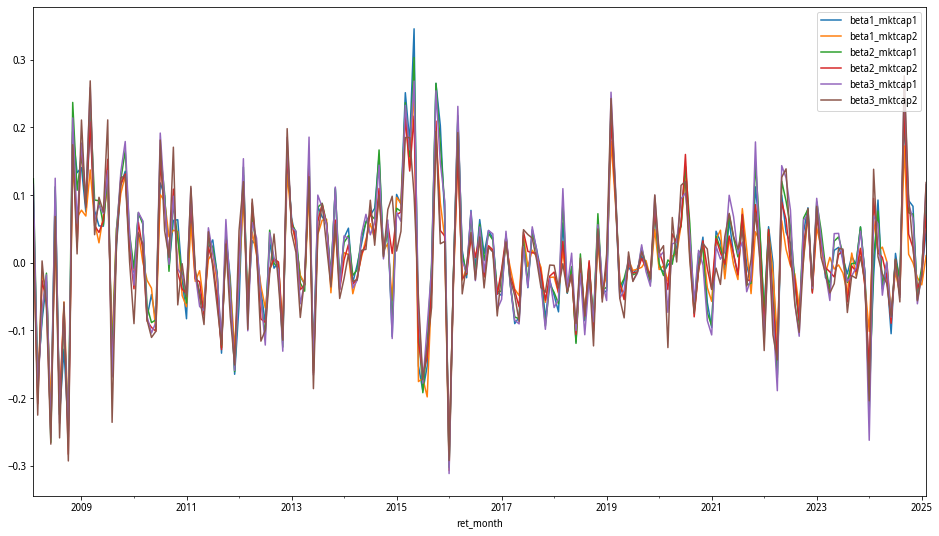

In [420]:
mean_portfolios_ret_df.plot()

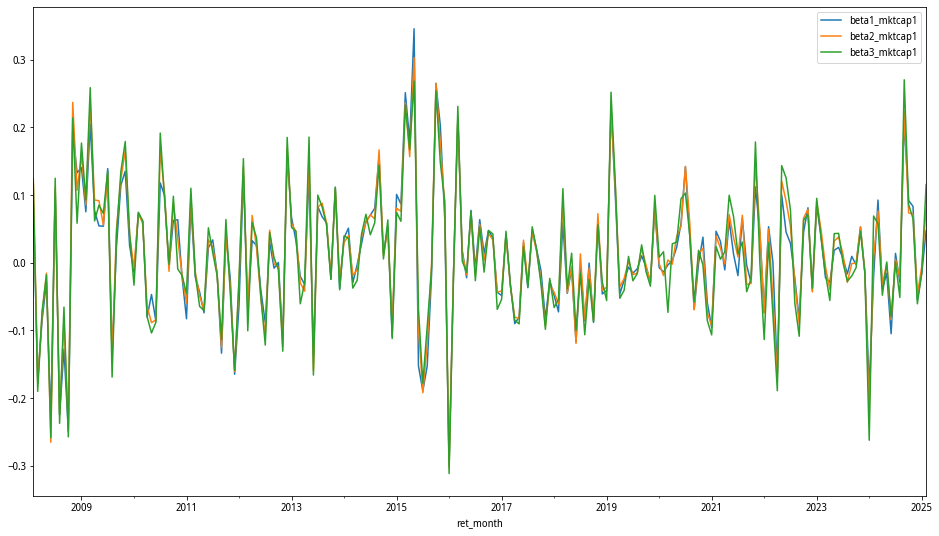

In [421]:
# Within mktcap1, any difference in beta groups?
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[-7:] == 'mktcap1'])
mean_portfolios_ret_df[cols].plot()

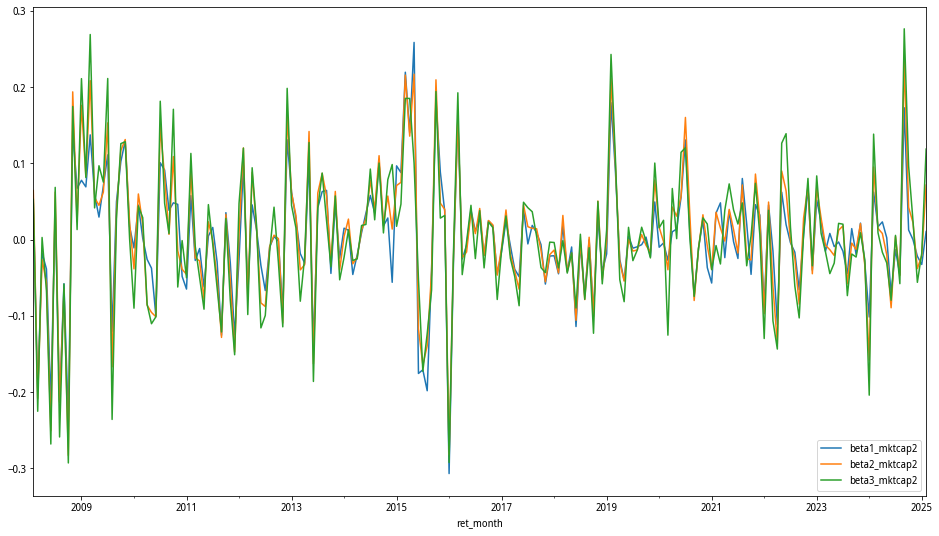

In [422]:
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[-7:] == 'mktcap2'])
mean_portfolios_ret_df[cols].plot()

没有明显区别。下面看看在beta组内，不同的market cap有没有什么区别

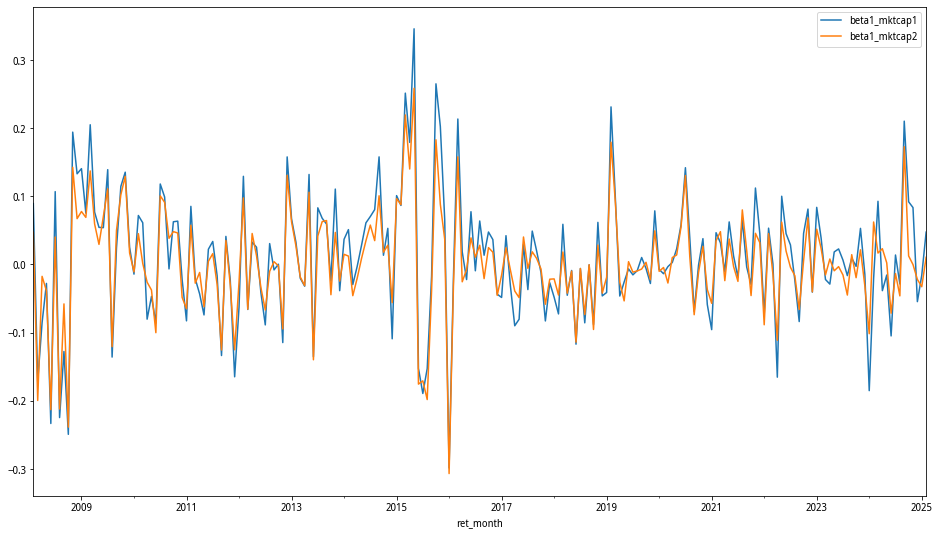

In [423]:
# Within beta1, any difference in mktcap groups?
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[:5] == 'beta1'])
mean_portfolios_ret_df[cols].plot()

小盘股上涨多，下跌也多

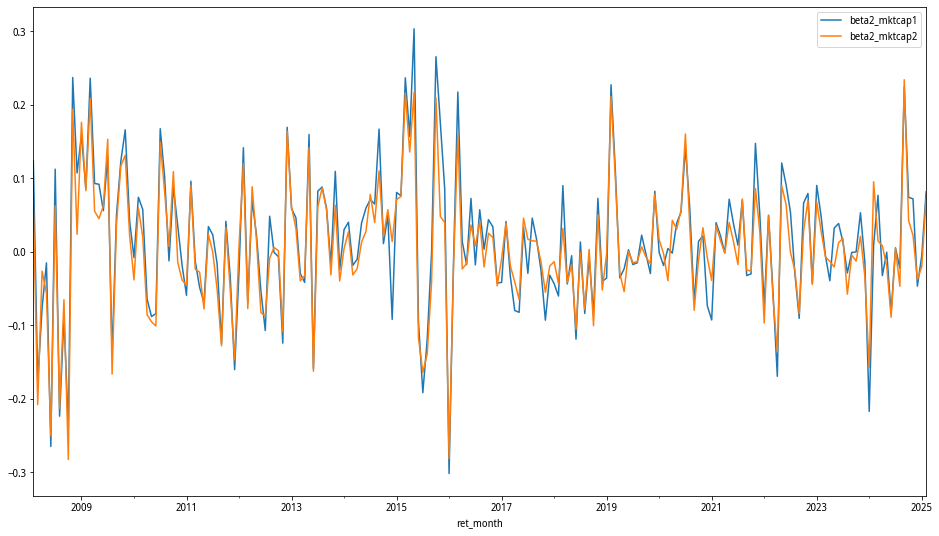

In [424]:
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[:5] == 'beta2'])
mean_portfolios_ret_df[cols].plot()

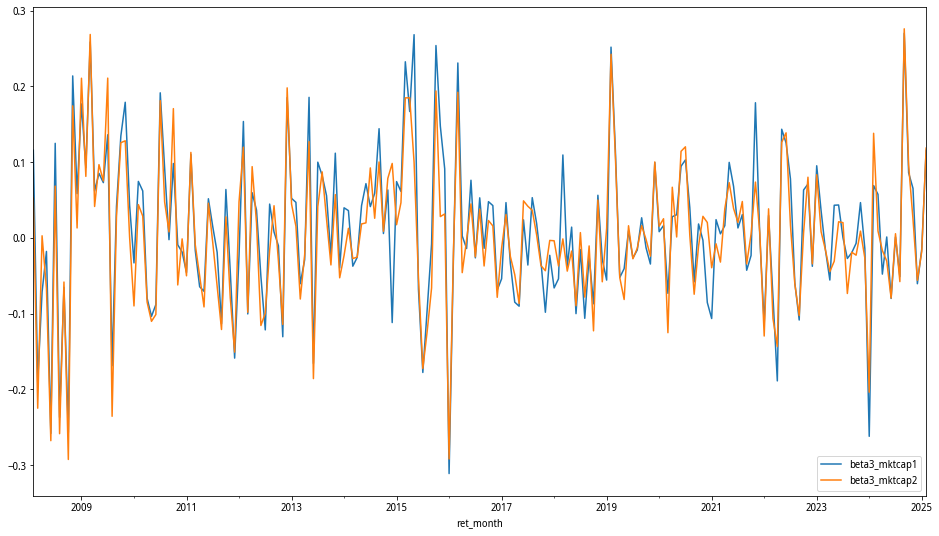

In [425]:
pfs = mean_portfolios_ret_df.columns
cols = list(pfs[pfs.str[:5] == 'beta3'])
mean_portfolios_ret_df[cols].plot()

In [426]:
# Newey-West adjustment
mean_values = {}
t_values = {}
for k in mean_portfolios_ret.keys():
    y = mean_portfolios_ret[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=4)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

In [427]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

beta1_mktcap1  beta1_mktcap2  beta2_mktcap1  beta2_mktcap2  \
ret_mean       0.010019       0.001355       0.013394       0.004581   
t_values       1.479140       0.242042       1.960942       0.731858   

          beta3_mktcap1  beta3_mktcap2  
ret_mean       0.010932       0.002443  
t_values       1.584504       0.358248

### Beta, Market cap 双排结论

- Beta组内，小盘股平均收益高于大盘股
- 从图上看，小盘股上涨多，下跌也多

# Fama-MacBeth regression

In [428]:
ret_df['exret100'] = ret_df['exret'] * 100

In [429]:
def fm_reg(df):
    df_  = df.dropna()
    if df_.shape[0] < 15:
        return None
    reg = LinearRegression().fit(y=df_.loc[:,'exret'], X=df_.loc[:,['Beta252','size']])
    return np.insert(reg.coef_, 0, reg.intercept_)

In [430]:
temp = ret_df.loc[ret_df['ret_month'] == '2008-07'].copy()

In [431]:
temp = temp.dropna()
reg = LinearRegression().fit(y=temp.loc[:,'exret'],X=temp.loc[:,['Beta252','size']])

In [432]:
reg.coef_

array([ 0.02833565, -0.03122107])

In [433]:
reg.intercept_

0.28702244401822385

In [434]:
np.insert(reg.coef_, 0, reg.intercept_)

array([ 0.28702244,  0.02833565, -0.03122107])

In [435]:
# ?np.insert

## Without winsorization

In [449]:
temp = ret_df.groupby('ret_month').apply(fm_reg)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept', 'beta_coef', 'size_coef']

In [450]:
reg_result_df

intercept  beta_coef  size_coef
ret_month                                 
2008-02     0.255990   0.054602  -0.028651
2008-03    -0.035781  -0.066708  -0.011918
2008-04    -0.390699   0.059988   0.036494
2008-05     0.144333  -0.030911  -0.019252
2008-06    -0.220643  -0.070664   0.005619
2008-07     0.287022   0.028336  -0.031221
2008-08    -0.226490  -0.049257   0.006656
2008-09    -0.285134   0.061234   0.019550
2008-10    -0.074817  -0.106386  -0.010100
2008-11     0.299876   0.095590  -0.029778
...              ...        ...        ...
2024-05     0.052510  -0.013277  -0.005477
2024-06    -0.159125   0.005217   0.007985
2024-07     0.012998   0.007667  -0.002367
2024-08     0.029639  -0.017841  -0.005643
2024-09     0.136482   0.079476  -0.001181
2024-10     0.173532   0.053199  -0.019838
2024-11     0.234493   0.002203  -0.022394
2024-12    -0.110898  -0.025752   0.011047
2025-01     0.028061   0.004253  -0.005903
2025-02     0.179441   0.015358  -0.014405

[205 rows x 3 columns]

In [451]:
reg_result_df_ = reg_result_df.loc["2008":].copy()

reg_result_df_

intercept  beta_coef  size_coef
ret_month                                 
2008-02     0.255990   0.054602  -0.028651
2008-03    -0.035781  -0.066708  -0.011918
2008-04    -0.390699   0.059988   0.036494
2008-05     0.144333  -0.030911  -0.019252
2008-06    -0.220643  -0.070664   0.005619
2008-07     0.287022   0.028336  -0.031221
2008-08    -0.226490  -0.049257   0.006656
2008-09    -0.285134   0.061234   0.019550
2008-10    -0.074817  -0.106386  -0.010100
2008-11     0.299876   0.095590  -0.029778
...              ...        ...        ...
2024-05     0.052510  -0.013277  -0.005477
2024-06    -0.159125   0.005217   0.007985
2024-07     0.012998   0.007667  -0.002367
2024-08     0.029639  -0.017841  -0.005643
2024-09     0.136482   0.079476  -0.001181
2024-10     0.173532   0.053199  -0.019838
2024-11     0.234493   0.002203  -0.022394
2024-12    -0.110898  -0.025752   0.011047
2025-01     0.028061   0.004253  -0.005903
2025-02     0.179441   0.015358  -0.014405

[205 rows x 3 columns]

In [452]:
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df_.columns:
    y = reg_result_df_[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

In [453]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept  beta_coef  size_coef
ret_mean   0.036335   0.003296  -0.004020
t_values   2.549852   0.984876  -2.935823

## With winsorization

In [454]:
winsor_top = ret_df.groupby(['ret_month'])[['Beta252','size']].quantile(0.995)
winsor_bottom = ret_df.groupby(['ret_month'])[['Beta252','size']].quantile(0.005)
winsor_top.columns = ['beta_q995','size_q995']
winsor_bottom.columns = ['beta_q005','size_q005']

ret_df_q = pd.merge(ret_df, winsor_top, on='ret_month')

ret_df_q = pd.merge(ret_df_q, winsor_bottom, on='ret_month')

ret_df_q.loc[ret_df_q['Beta252'] > ret_df_q['beta_q995'],'Beta252'] = ret_df_q['beta_q995']
ret_df_q.loc[ret_df_q['Beta252'] < ret_df_q['beta_q005'],'Beta252'] = ret_df_q['beta_q005']
ret_df_q.loc[ret_df_q['size'] > ret_df_q['size_q995'],'size'] = ret_df_q['size_q995']
ret_df_q.loc[ret_df_q['size'] < ret_df_q['size_q005'],'size'] = ret_df_q['size_q005']

In [455]:
ret_df_q

secID ret_month       ret        rf     exret group_month  \
0       000001.XSHE   2008-02 -0.004504  0.003753 -0.008257     2008-01   
1       000002.XSHE   2008-02 -0.107485  0.003753 -0.111238     2008-01   
2       000006.XSHE   2008-02  0.014997  0.003753  0.011244     2008-01   
3       000012.XSHE   2008-02  0.252739  0.003753  0.248986     2008-01   
4       000014.XSHE   2008-02  0.068538  0.003753  0.064785     2008-01   
5       000016.XSHE   2008-02  0.056906  0.003753  0.053153     2008-01   
6       000019.XSHE   2008-02  0.172807  0.003753  0.169054     2008-01   
7       000021.XSHE   2008-02  0.014759  0.003753  0.011006     2008-01   
8       000022.XSHE   2008-02  0.051616  0.003753  0.047863     2008-01   
9       000023.XSHE   2008-02  0.082056  0.003753  0.078303     2008-01   
...             ...       ...       ...       ...       ...         ...   
623101  688787.XSHG   2025-02 -0.260637  0.002068 -0.262705     2025-01   
623102  688788.XSHG   2025-02  0.862513  0.002068  0.860445     2025-01   
623103  688789.XSHG   2025-02 -0.008657  0.002068 -0.010725     2025-01   
623104  688793.XSHG   2025-02  0.122370  0.002068  0.120302     2025-01   
623105  688798.XSHG   2025-02  0.032959  0.002068  0.030891     2025-01   
623106  688799.XSHG   2025-02 -0.047997  0.002068 -0.050065     2025-01   
623107  688800.XSHG   2025-02 -0.241236  0.002068 -0.243304     2025-01   
623108  688819.XSHG   2025-02  0.080032  0.002068  0.077964     2025-01   
623109  688981.XSHG   2025-02  0.040984  0.002068  0.038916     2025-01   
623110  689009.XSHG   2025-02  0.113168  0.002068  0.111100     2025-01   

              mkt_cap  Beta252       size   exret100  beta_q995  size_q995  \
0        58502.124282   0.9654  10.976818  -0.825679   1.364302  11.548802   
1       153263.245763   1.0823  11.548802 -11.123846   1.364302  11.548802   
2         6013.791342   1.0654   8.701811   1.124357   1.364302  11.548802   
3         7047.868859   1.1439   8.860481  24.898632   1.364302  11.548802   
4         1403.297367   0.4627   7.246580   6.478452   1.364302  11.548802   
5         2412.904611   0.8504   7.788587   5.315278   1.364302  11.548802   
6         1196.602082   0.7957   7.087241  16.905434   1.364302  11.548802   
7         6228.621320   0.9856   8.736910   1.100602   1.364302  11.548802   
8         2543.495539   0.9005   7.841295   4.786250   1.364302  11.548802   
9          632.600660   1.0612   6.449839   7.830267   1.364302  11.548802   
...               ...      ...        ...        ...        ...        ...   
623101    8082.370296   1.9190   8.997440 -26.270506   2.128275  12.549443   
623102    3383.932800   1.4162   8.126794  86.044512   2.128275  12.549443   
623103   12435.975090   1.3512   9.428349  -1.072462   2.128275  12.549443   
623104    2247.472210   1.2820   7.717561  12.030237   2.128275  12.549443   
623105    9768.850419   1.6557   9.186954   3.089081   2.128275  12.549443   
623106    3929.282000   1.0245   8.276212  -5.006478   2.128275  12.549443   
623107   10710.769439   1.7329   9.279005 -24.330393   2.128275  12.549443   
623108   25760.650000   1.3536  10.156603   7.796425   2.128275  12.549443   
623109  186786.453854   1.4862  12.137721   3.891561   2.128275  12.549443   
623110   28225.140460   1.1695  10.247968  11.109977   2.128275  12.549443   

        beta_q005  size_q005  
0        0.400960   5.790750  
1        0.400960   5.790750  
2        0.400960   5.790750  
3        0.400960   5.790750  
4        0.400960   5.790750  
5        0.400960   5.790750  
6        0.400960   5.790750  
7        0.400960   5.790750  
8        0.400960   5.790750  
9        0.400960   5.790750  
...           ...        ...  
623101   0.361965   6.413089  
623102   0.361965   6.413089  
623103   0.361965   6.413089  
623104   0.361965   6.413089  
623105   0.361965   6.413089  
623106   0.361965   6.413089  
623107   0.361965   6.413089  
623108   0.361965   6.413089  
623109   0.361965   6.4130

In [456]:
temp = ret_df_q.groupby('ret_month').apply(fm_reg)
reg_result_df = pd.DataFrame(temp.values.tolist())
reg_result_df.index=temp.index
reg_result_df.columns = ['intercept', 'beta_coef', 'size_coef']

In [457]:
# Mean of coefs with NW adjustment
mean_values = {}
t_values = {}
for k in reg_result_df.columns:
    y = reg_result_df[k]
    const = np.full(shape=len(y),fill_value=1)
    reg = sm.OLS(y, const).fit().get_robustcov_results(cov_type='HAC', maxlags=6)
    mean_values[k] = reg.params[0]
    t_values[k] = reg.tvalues[0]

In [458]:
pd.DataFrame([mean_values.values(),t_values.values()],index=['ret_mean','t_values'],columns=mean_values.keys())

intercept  beta_coef  size_coef
ret_mean   0.036411   0.003496  -0.004082
t_values   2.522219   0.992831  -2.921121

# 结论

样本：2008:01-2025:02, 全部A股

单排、双排、FM回归结论一致：
- 小市值股比大市值股表现更好
- Beta不同，横截面上股票收益率无明显差异